In [118]:
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', 0)

from os import path
from PIL import Image
import os

from collections import Counter

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score, silhouette_samples, silhouette_score
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans

from pprint import pprint

import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer, word_tokenize
from nltk.stem.porter import PorterStemmer as PS

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from wordcloud import WordCloud, ImageColorGenerator

[nltk_data] Downloading package stopwords to /Users/coxem/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## EDA

In [2]:
texts = pd.read_csv('data/dataset.csv')
texts.head(10)

text  \
0  Joe biden rules out 2020 bid: 'guys, i'm not running'                                   
1  Watch: darvish gave hitter whiplash with slow pitch                                     
2  What do you call a turtle without its shell? dead.                                      
3  5 reasons the 2016 election feels so personal                                           
4  Pasco police shot mexican migrant from behind, new autopsy shows                        
5  Martha stewart tweets hideous food photo, twitter responds accordingly                  
6  What is a pokemon master's favorite kind of pasta? wartortellini!                       
7  Why do native americans hate it when it rains in april? because it brings mayflowers.   
8  Obama's climate change legacy is impressive, imperfect and vulnerable                   
9  My family tree is a cactus, we're all pricks.                                           

   humor  
0  False  
1  False  
2  True   
3  False  
4  False  
5  False  
6  True   
7  True   
8  False  
9  True

In [3]:
texts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    200000 non-null  object
 1   humor   200000 non-null  bool  
dtypes: bool(1), object(1)
memory usage: 1.7+ MB


In [4]:
texts.humor.unique()

array([False,  True])

In [5]:
texts.humor.value_counts()

True     100000
False    100000
Name: humor, dtype: int64

In [6]:
texts.text[0]

"Joe biden rules out 2020 bid: 'guys, i'm not running'"

In [7]:
texts_humor = texts[texts['humor'] == True]
texts_humor.head()

text  \
2   What do you call a turtle without its shell? dead.                                      
6   What is a pokemon master's favorite kind of pasta? wartortellini!                       
7   Why do native americans hate it when it rains in april? because it brings mayflowers.   
9   My family tree is a cactus, we're all pricks.                                           
13  How are music and candy similar? we throw away the rappers.                             

    humor  
2   True   
6   True   
7   True   
9   True   
13  True

In [8]:
texts_serious = texts[texts['humor'] == False]
texts_serious.head()

text  \
0  Joe biden rules out 2020 bid: 'guys, i'm not running'                    
1  Watch: darvish gave hitter whiplash with slow pitch                      
3  5 reasons the 2016 election feels so personal                            
4  Pasco police shot mexican migrant from behind, new autopsy shows         
5  Martha stewart tweets hideous food photo, twitter responds accordingly   

   humor  
0  False  
1  False  
3  False  
4  False  
5  False

## Train, Test, Split

In [9]:
X = texts['text']

In [10]:
y = texts['humor']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, stratify=y)

In [12]:
X_train

172770    I have a step ladder i never met my real ladder.                              
71124     What do you call a gay dinosaur? a very soar arse                             
135380    What do you call a paraplegic with an incurable std? roll-aids.               
30845     What are the unspoken rules of sign language? all of them                     
73643     5 genius wedding registry tips from giada de laurentiis                       
                                   ...                                                  
95649     Vatican issues first comments on trump's immigration ban                      
63575     If atlas supported the world on his shoulders who supported atlas ? his wife !
15529     What's one thing you hated as a kid but love as an adult? molestation.        
19674     Gop hopeful on budget: cut porno-watching gov't employees                     
89107     Lebron james once gained 7 pounds in a single nba playoff game                
Name: text, Length: 1

## Developing Corpus Cleaning Pipeline

> * For my Naive Bayes model, I wanted to try to use a stemmed corpus prior to fit_transforming the tfidf vectorizer, because without it, there were a lot of duplicated words in various forms (e.g. charged, charge, charges, etc.). In order to do this, I had to write a function to which would stem the corpus, and I just went ahead and cleaned the text up (removed punctuation, stopwords, and used porter stemmer) then put it back in the raw corpus format (list of strings).
> * This ended up resulting in a lower accuracy, but worked really well for making my wordcloud

In [13]:
# texts_list = [text.lower() for text in X]
# texts_list

In [14]:
# tokenizer = RegexpTokenizer("[\w']+")

In [15]:
# tokens = list(map(tokenizer.tokenize, texts_list))
# tokens

In [16]:
# punc = set(string.punctuation)
# tokens_no_punc = [[word for word in words if word not in punc]
#         for words in tokens]
# tokens_no_punc

In [17]:
# s_words = set(stopwords.words('english'))
# tokens_no_sw = [[word for word in words if word not in s_words]
#         for words in tokens_no_punc]
# tokens_no_sw

In [18]:
# porter = PS()
# texts_ps = [[porter.stem(word) for word in text] for text in tokens_no_sw]
# texts_ps

In [19]:
# texts_ps_joined = [' '.join(word) for word in texts_ps]
# texts_ps_joined

In [20]:
def clean_corpus(X):
    '''
    Takes in a series or list of strings.
    Returns one string of cleaned text.
    '''
    # lowercase the strings
    corpus = [text.lower() for text in X] 

    # declare regular expression tokenizer
    # split strings into words while keeping contractions together
    tokenizer = RegexpTokenizer("[\w']+")
    tokens = list(map(tokenizer.tokenize, corpus)) 
    
    # remove punctuation
    punc = set(string.punctuation)
    tokens_no_punc = [[word for word in words if word not in punc]
        for words in tokens]
   
    # remove stopwords
    s_words = set(stopwords.words('english'))
    tokens_no_sw = [[word for word in words if word not in s_words]
        for words in tokens_no_punc]
    
    # stem the words to get rid of multiple forms of the same word
    porter = PS()
    tokens_stemmed = [[porter.stem(word) for word in text] for text in tokens_no_sw]
    
    # join all words into one string
    cleaned_corpus = [' '.join(word) for word in tokens_stemmed]
    
    return cleaned_corpus

In [56]:
def old_clean_corpus(X):
    '''
    Takes in a series or list of strings.
    Returns one string of cleaned text.
    '''
    # lowercase the strings
    corpus = [text.lower() for text in X] 

    # declare regular expression tokenizer
    # split strings into words while keeping contractions together
    tokens = list(map(word_tokenize, corpus)) 
    
    # remove punctuation
    punc = set(string.punctuation)
    tokens_no_punc = [[word for word in words if word not in punc]
        for words in tokens]
   
    # remove stopwords
    s_words = set(stopwords.words('english'))
    tokens_no_sw = [[word for word in words if word not in s_words]
        for words in tokens_no_punc]
    
    # stem the words to get rid of multiple forms of the same word
    porter = PS()
    tokens_stemmed = [[porter.stem(word) for word in text] for text in tokens_no_sw]
    
    # join all words into one string
    cleaned_corpus = [' '.join(word) for word in tokens_stemmed]
    
    return cleaned_corpus

## Humor Word Cloud and Serious Word Cloud

In [21]:
#https://amueller.github.io/word_cloud/auto_examples/masked.html#sphx-glr-auto-examples-masked-py

# Define path
path_ = path.dirname(__file__) if "__file__" in locals() else os.getcwd()

# read the mask / color image taken from
laugh_emoji = np.array(Image.open(path.join(path_, "images/rolling-on-the-floor-laughing.png")))
straight_face_emoji = np.array(Image.open(path.join(path_, "images/expressionless-face.png")))

# create coloring from image
humor_image_colors = ImageColorGenerator(laugh_emoji)
serious_image_colors = ImageColorGenerator(straight_face_emoji)

In [57]:
# def old_word_cloud(corpus, wordcloud_obj):
#     cleaned_corpus = ' '.join(old_clean_corpus(corpus))
#     word_cloud = wordcloud_obj
#     word_cloud.generate(cleaned_corpus)
#     return word_cloud

In [58]:
# wc_humor_old = WordCloud(background_color="black", relative_scaling=0.5, max_words=None, mask=laugh_emoji, max_font_size=50)

In [61]:
# old_word_cloud_humor = old_word_cloud(texts_humor.text, wc_humor_old)

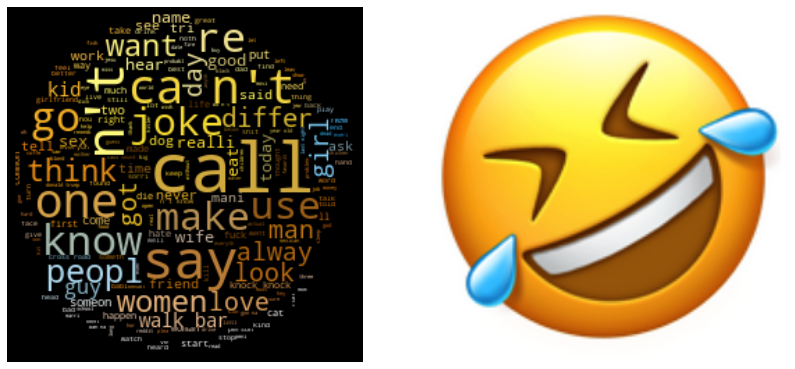

In [62]:
# fig, axes = plt.subplots(1, 2, figsize=(14,10))
# axes[0].imshow(old_word_cloud_humor.recolor(color_func=humor_image_colors), interpolation="bilinear")
# axes[1].imshow(laugh_emoji, cmap=plt.cm.gray, interpolation="bilinear")

# for ax in axes:
#     ax.set_axis_off()

In [22]:
def make_word_cloud(corpus, wordcloud_obj):
    cleaned_corpus = ' '.join(clean_corpus(corpus))
    word_cloud = wordcloud_obj
    word_cloud.generate(cleaned_corpus)
    return word_cloud

In [23]:
wc_humor = WordCloud(background_color="black", relative_scaling=0.5, max_words=None, mask=laugh_emoji, max_font_size=50)

In [24]:
word_cloud_humor = make_word_cloud(texts_humor.text, wc_humor)

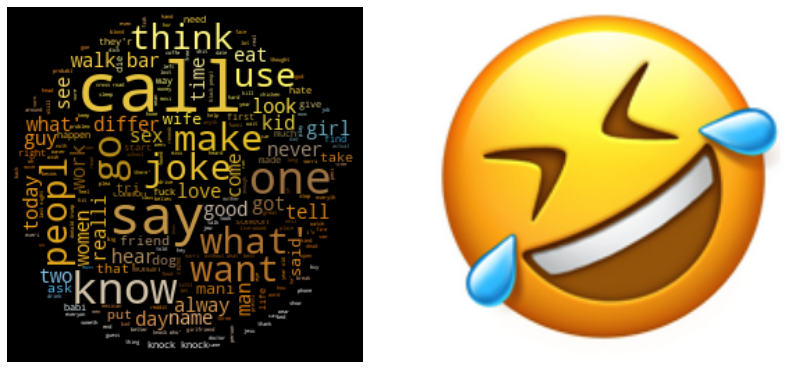

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(14,10))
axes[0].imshow(word_cloud_humor.recolor(color_func=humor_image_colors), interpolation="bilinear")
axes[1].imshow(laugh_emoji, cmap=plt.cm.gray, interpolation="bilinear")

for ax in axes:
    ax.set_axis_off()
    
#plt.savefig('wc_humor.png')

In [26]:
def get_top_words(word_cloud, num_words=10):
    word_list = list(word_cloud.words_)
    top_words = word_list[:num_words]
    return f'The top {num_words} words are: {", ".join(top_words)}'

In [27]:
get_top_words(word_cloud_humor)

"The top 10 words are: call, say, one, know, go, make, what', joke, peopl, want"

In [28]:
wc_serious = WordCloud(background_color="black", relative_scaling=0.5, max_words=None, mask=straight_face_emoji, max_font_size=50)

In [29]:
word_cloud_serious = make_word_cloud(texts_serious.text, wc_serious)

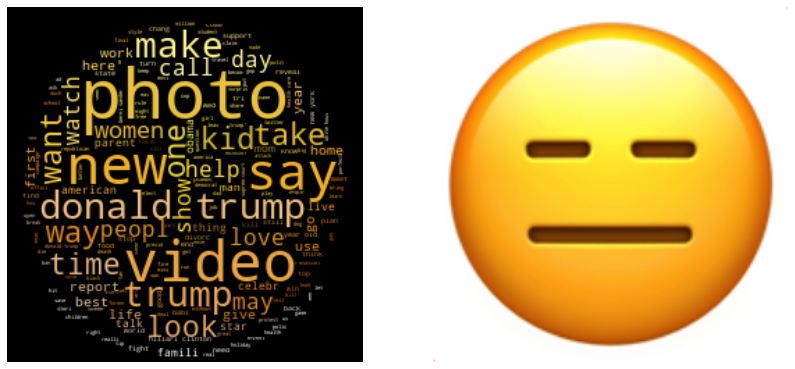

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(14,10))
axes[0].imshow(wc_serious.recolor(color_func=serious_image_colors), interpolation="bilinear")
axes[1].imshow(straight_face_emoji, cmap=plt.cm.gray, interpolation="bilinear")
for ax in axes:
    ax.set_axis_off()

#plt.savefig('wc_serious.png')

In [33]:
get_top_words(word_cloud_serious)

'The top 10 words are: photo, video, new, say, donald trump, trump, make, one, kid, take'

## Featurizing the Text

In [34]:
# tfid = TfidfVectorizer(max_features=1000)
# text_train = tfid.fit_transform(X_train_clean)
# feature_names = tfid.get_feature_names()
# feature_names

In [35]:
# tfid = TfidfVectorizer(stop_words='english', max_features=1000)
# text_train = tfid.fit_transform(X_train)
# feature_names = tfid.get_feature_names()
# feature_names

In [36]:
# len(feature_names)

In [37]:
# text_train_df = pd.DataFrame(text_train.todense(), columns = tfid.vocabulary_)
# text_train_df.head()

In [38]:
#text_train_df.call.unique()

In [39]:
# X_text_train = text_train.toarray()
# X_text_train

In [40]:
# X_text_train.shape

## Fitting the Naive Bayes models

> * From sklearn: Multinomial implements the naive Bayes algorithm for multinomially distributed data, and is one of the two classic naive Bayes variants used in text classification (where the data are typically represented as word vector counts, although tf-idf vectors are also known to work well in practice).
> * Seems like the uncleaned model performs better than the cleaned model


> * From sklearn: BernoulliNB implements the naive Bayes training and classification algorithms for data that is distributed according to multivariate Bernoulli distributions; i.e., there may be multiple features but each one is assumed to be a binary-valued (Bernoulli, boolean) variable. In the case of text classification, word occurrence vectors (rather than word count vectors) may be used to train and use this classifier. BernoulliNB might perform better on some datasets, especially those with shorter documents. It is advisable to evaluate both models, if time permits.
> * Seems like BernoulliNB performs slightly better than MultinomialNB



In [41]:
X_train_clean = clean_corpus(X_train)

In [42]:
X_test_clean = clean_corpus(X_test)

#### MultinomialNB

In [43]:
def fit_predict_model_accuracy(pipeline, X_train, y_train, X_test, y_test):
    pipeline.fit(X_train, y_train)
    predicted = pipeline.predict(X_test)
    accuracy = np.mean(predicted == y_test)
    print("\nThe accuracy on the test set is {0:0.3f}.".format(accuracy))
    return predicted

In [44]:
mnb_pipeline = Pipeline([('tfidf', TfidfVectorizer()),
                        ('model', MultinomialNB())])

mnb_pipeline_clean = Pipeline([('tfidf', TfidfVectorizer()),
                        ('model', MultinomialNB())]) 

In [45]:
mnb_predicted = fit_predict_model_accuracy(mnb_pipeline, X_train, y_train, X_test, y_test)


The accuracy on the test set is 0.916.


In [46]:
mnb_predicted_clean = fit_predict_model_accuracy(mnb_pipeline_clean, X_train_clean, y_train, X_test_clean, y_test)


The accuracy on the test set is 0.893.


#### BernoulliNB

In [47]:
bnb_pipeline = Pipeline([('tfidf', TfidfVectorizer()),
                        ('model', BernoulliNB())])

bnb_pipeline_clean = Pipeline([('tfidf', TfidfVectorizer()),
                        ('model', BernoulliNB())])

In [48]:
bnb_predicted = fit_predict_model_accuracy(bnb_pipeline, X_train, y_train, X_test, y_test)


The accuracy on the test set is 0.921.


In [49]:
bnb_predicted_clean = fit_predict_model_accuracy(bnb_pipeline_clean, X_train_clean, y_train, X_test_clean, y_test)


The accuracy on the test set is 0.895.


## Confusion Matrices

> * Accuracy - How often does the model predict correctly, overall?
> * Precision - When the model predicts the positive result, how often is it correct?
> * Recall - When it is actually the positive result, how often does it predict correctly?

> * The model with the best scores overall is the Bernoulli Naive Bayes using the uncleaned data.

> * Is it more "dangerous" to believe something meant to be humorous is serious (false negative), or to believe something meant to be serious is humorous (false positive)? Orson Welles "The War of the Worlds" panic vs potentially neglecting someone in need (boy who cried wolf - or guy who got stuck in an ATM). 
> * Personally, I think it's more dangerous to believe something meant to be serious is humorous (false positive in this case)

> * I want to figure out what words it is having trouble with

In [107]:
def create_confusion_matrix(y_test, predicted, targets, ax):
    cm = confusion_matrix(y_test, predicted)
    sns.set(font_scale=1.7)
    sns.heatmap(cm.T, square = True, annot = True, fmt = 'd', cmap='magma',
            xticklabels = targets, yticklabels = targets, ax=ax)

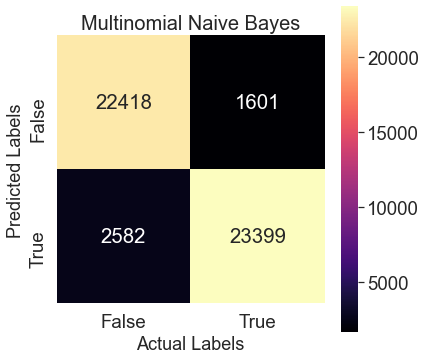

In [108]:
fig, ax = plt.subplots(figsize=(6,6))
create_confusion_matrix(y_test, mnb_predicted, y.unique(), ax=ax)
ax.set_xlabel('Actual Labels', fontsize=18)
ax.set_ylabel('Predicted Labels', fontsize=18)
ax.set_title('Multinomial Naive Bayes', fontsize=20);

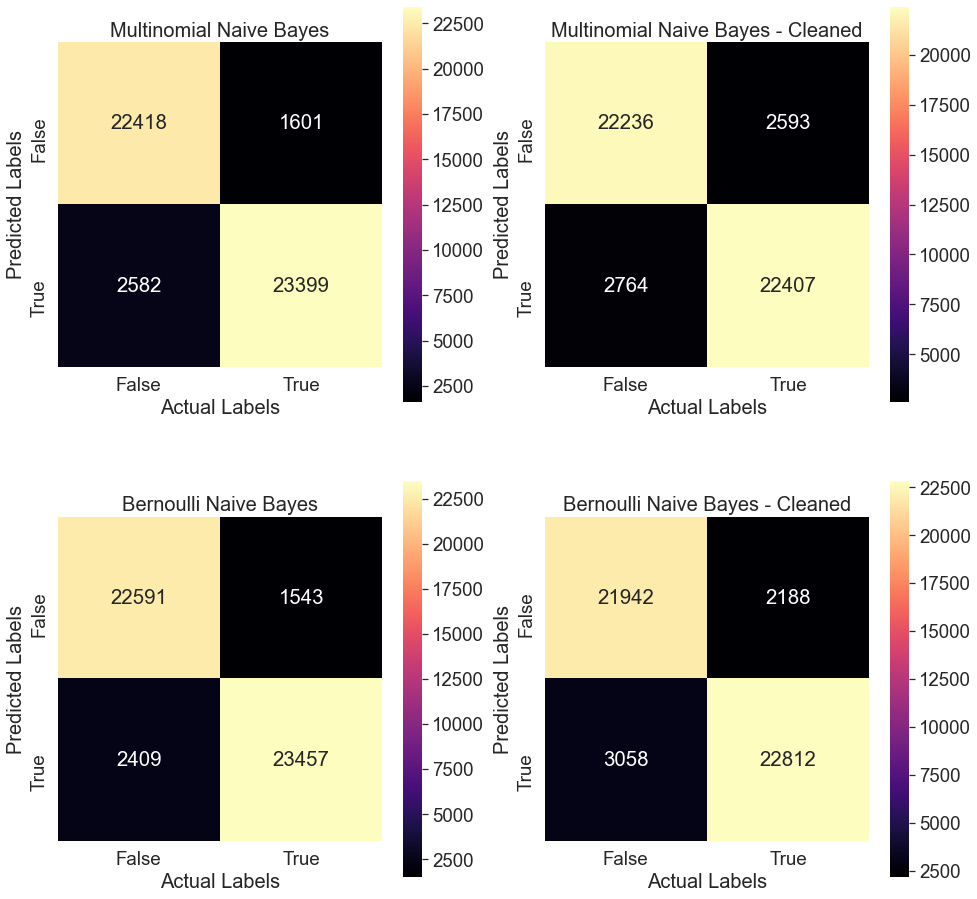

In [110]:
fig, axs = plt.subplots(2, 2, figsize=(16,16))
preds = [mnb_predicted, mnb_predicted_clean, bnb_predicted, bnb_predicted_clean]
titles = ['Multinomial Naive Bayes', 'Multinomial Naive Bayes - Cleaned', 'Bernoulli Naive Bayes', 'Bernoulli Naive Bayes - Cleaned']
i = 0
for pred, ax in zip(preds, axs.flatten()):
    create_confusion_matrix(y_test, pred, y.unique(), ax=ax)
    ax.set_xlabel('Actual Labels', fontsize=20)
    ax.set_ylabel('Predicted Labels', fontsize=20)
    ax.set_title(titles[i], fontsize=20)
    i += 1
    
#plt.savefig('confusion_matrices.png')

In [53]:
preds = [mnb_predicted, mnb_predicted_clean, bnb_predicted, bnb_predicted_clean]
titles = ['Multinomial Naive Bayes', 'Multinomial Naive Bayes - Cleaned', 'Bernoulli Naive Bayes', 'Bernoulli Naive Bayes - Cleaned']
accs = []
precs = []
recs = []
for idx, pred in enumerate(preds):
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    accs.append(accuracy)
    precs.append(precision)
    recs.append(recall)
    print(f'\nModel: {titles[idx]}')
    print("The accuracy on the test set is {0:0.3f}.".format(accuracy))
    print("The precision on the test set is {0:0.3f}.".format(precision))
    print("The recall on the test set is {0:0.3f}.".format(recall))

print(f'\nThe model with the highest accuracy: {titles[int(np.where(accs == np.max(accs))[0])]}')
print(f'The model with the highest precision: {titles[int(np.where(precs == np.max(precs))[0])]}')
print(f'The model with the highest recall: {titles[int(np.where(recs == np.max(recs))[0])]}')


Model: Multinomial Naive Bayes
The accuracy on the test set is 0.916.
The precision on the test set is 0.901.
The recall on the test set is 0.936.

Model: Multinomial Naive Bayes - Cleaned
The accuracy on the test set is 0.893.
The precision on the test set is 0.890.
The recall on the test set is 0.896.

Model: Bernoulli Naive Bayes
The accuracy on the test set is 0.921.
The precision on the test set is 0.907.
The recall on the test set is 0.938.

Model: Bernoulli Naive Bayes - Cleaned
The accuracy on the test set is 0.895.
The precision on the test set is 0.882.
The recall on the test set is 0.912.

The model with the highest accuracy: Bernoulli Naive Bayes
The model with the highest precision: Bernoulli Naive Bayes
The model with the highest recall: Bernoulli Naive Bayes


In [111]:
# conf_mat_clean = confusion_matrix(y_test, predicted_clean)
# tn, fp, fn, tp = conf_mat_clean.ravel()
# tn, fp, fn, tp #making sure the confusion matrix is outputting the correct information

In [112]:
# cm_display = ConfusionMatrixDisplay(conf_mat).plot()

## Testing the model(s) on new (made up) data

In [53]:
def get_predictions(text, pipeline):
    prediction = pipeline.predict([text])
    return prediction

In [54]:
# humorous - https://www.fatherly.com/play/best-coronavirus-jokes/
# serious - https://www.cdc.gov/coronavirus/2019-ncov/prevent-getting-sick/prevention.html
# text_humorous_1 = 'My mom always told me I wouldn’t accomplish anything by lying in bed all day. But look at me now, ma! I’m saving the world!'
# text_humorous_2 = 'If I keep stress-eating at this level, the buttons on my shirt will start socially distancing from each other.'
# text_serious_1 = 'To help prevent the spread of COVID-19, everyone should wear a mask in public.'
# text_serious_2 = 'Avoid close contact with people who are sick.'

In [194]:
def get_multiple_predictions(text_list, label_list, pipeline):
    for idx, text in enumerate(text_list):
        if get_predictions(text=text, pipeline=pipeline)[0] == True:
            pred = 'Humorous'
        else: pred = 'Serious'
        print(f'Text: {text}\nPrediction: {pred}\nLabel: {label_list[idx]}\n')

In [202]:
google_form_responses = pd.read_csv('data/google_form_responses.csv')

In [203]:
google_form_responses.rename(columns={'Short Text:': 'text', 'True or False - The text is humorous.': 'humor'}, inplace=True)
google_form_responses

Timestamp Your Name:  \
0  12/3/2020 9:34:39   Heather     
1  12/3/2020 9:35:55   Heather     
2  12/3/2020 9:43:14   George      
3  12/3/2020 10:20:32  nico        
4  12/3/2020 11:27:47  Mario       
5  12/3/2020 11:56:25  Erin        
6  12/3/2020 11:56:42  Erin        
7  12/3/2020 11:56:56  Erin        
8  12/3/2020 11:57:13  Erin        

                                                                                                                                       text  \
0  When the prosecuting attorney asked Gucci Mane if he was guilty he said, 'bitch I might be.'                                               
1  Camus says that when you wish yourself into the future you commit suicide by wishing yourself closer to your death.                        
2  How did the random variable get into the club? By showing a fake i.i.d.                                                                    
3  Laugh it up! Humor is universal across human cultures — and fuels psychological research on everything from social perception to emotion   
4  Saddest 6 word story: "Soup of the Day: No Soup."                                                                                          
5  My mom always told me I wouldn’t accomplish anything by lying in bed all day. But look at me now, ma! I’m saving the world!                
6  If I keep stress-eating at this level, the buttons on my shirt will start socially distancing from each other.                             
7  To help prevent the spread of COVID-19, everyone should wear a mask in public.                                                             
8  Avoid close contact with people who are sick.                                                                                              

   humor  
0  True   
1  False  
2  True   
3  False  
4  True   
5  True   
6  True   
7  False  
8  False

In [204]:
X_new = google_form_responses.copy()
X_new

Timestamp Your Name:  \
0  12/3/2020 9:34:39   Heather     
1  12/3/2020 9:35:55   Heather     
2  12/3/2020 9:43:14   George      
3  12/3/2020 10:20:32  nico        
4  12/3/2020 11:27:47  Mario       
5  12/3/2020 11:56:25  Erin        
6  12/3/2020 11:56:42  Erin        
7  12/3/2020 11:56:56  Erin        
8  12/3/2020 11:57:13  Erin        

                                                                                                                                       text  \
0  When the prosecuting attorney asked Gucci Mane if he was guilty he said, 'bitch I might be.'                                               
1  Camus says that when you wish yourself into the future you commit suicide by wishing yourself closer to your death.                        
2  How did the random variable get into the club? By showing a fake i.i.d.                                                                    
3  Laugh it up! Humor is universal across human cultures — and fuels psychological research on everything from social perception to emotion   
4  Saddest 6 word story: "Soup of the Day: No Soup."                                                                                          
5  My mom always told me I wouldn’t accomplish anything by lying in bed all day. But look at me now, ma! I’m saving the world!                
6  If I keep stress-eating at this level, the buttons on my shirt will start socially distancing from each other.                             
7  To help prevent the spread of COVID-19, everyone should wear a mask in public.                                                             
8  Avoid close contact with people who are sick.                                                                                              

   humor  
0  True   
1  False  
2  True   
3  False  
4  True   
5  True   
6  True   
7  False  
8  False

In [205]:
google_form_responses.loc[(google_form_responses.humor == True), 'humor'] = 'Humorous'

In [206]:
google_form_responses.loc[(google_form_responses.humor == False), 'humor'] = 'Serious'

In [207]:
text_list = list(google_form_responses.text)
label_list = list(google_form_responses.humor)
get_multiple_predictions(text_list=text_list, label_list=label_list, pipeline=bnb_pipeline)

Text: When the prosecuting attorney asked Gucci Mane if he was guilty he said, 'bitch I might be.'
Prediction: Humorous
Label: Humorous

Text: Camus says that when you wish yourself into the future you commit suicide by wishing yourself closer to your death.
Prediction: Humorous
Label: Serious

Text: How did the random variable get into the club? By showing a fake i.i.d.
Prediction: Humorous
Label: Humorous

Text: Laugh it up! Humor is universal across human cultures — and fuels psychological research on everything from social perception to emotion
Prediction: Serious
Label: Serious

Text: Saddest 6 word story: "Soup of the Day: No Soup."
Prediction: Humorous
Label: Humorous

Text: My mom always told me I wouldn’t accomplish anything by lying in bed all day. But look at me now, ma! I’m saving the world!
Prediction: Humorous
Label: Humorous

Text: If I keep stress-eating at this level, the buttons on my shirt will start socially distancing from each other.
Prediction: Humorous
Label: Hu

In [209]:
X_test_new = X_new['text']
y_test_new = X_new['humor']

In [210]:
bnb_predicted_new = bnb_pipeline.predict(X_test_new)

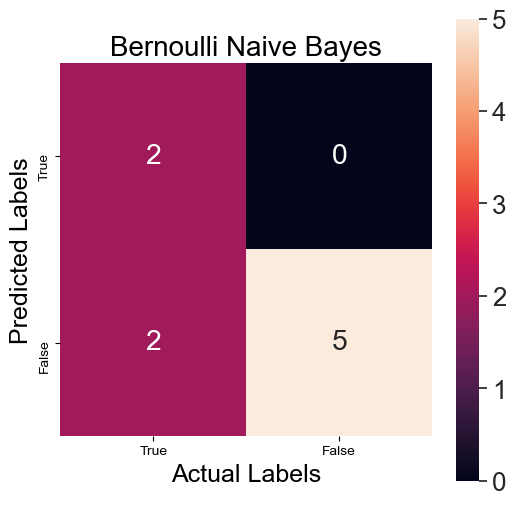

In [211]:
fig, ax = plt.subplots(figsize=(6,6))
create_confusion_matrix(y_test_new, bnb_predicted_new, y_test_new.unique(), ax=ax)
ax.set_xlabel('Actual Labels', fontsize=18)
ax.set_ylabel('Predicted Labels', fontsize=18)
ax.set_title('Bernoulli Naive Bayes', fontsize=20);

In [212]:
accuracy_new = accuracy_score(y_test_new, bnb_predicted_new)
precision_new = precision_score(y_test_new, bnb_predicted_new)
recall_new = recall_score(y_test_new, bnb_predicted_new)

print("The accuracy on the test set is {0:0.3f}.".format(accuracy_new))
print("The precision on the test set is {0:0.3f}.".format(precision_new))
print("The recall on the test set is {0:0.3f}.".format(recall_new))

The accuracy on the test set is 0.778.
The precision on the test set is 0.714.
The recall on the test set is 1.000.


## ROC Curve

> * ROC - When it is actually the negative result, how often does it predict correctly?

In [113]:
y_test_values = y_test.values
y_test_values = np.where(y_test_values, 1, 0)
y_test_values

array([1, 0, 1, ..., 1, 1, 0])

In [114]:
y_test_new_values = y_test_new.values
y_test_new_values = np.where(y_test_values, 1, 0)

NameError: name 'y_test_new' is not defined

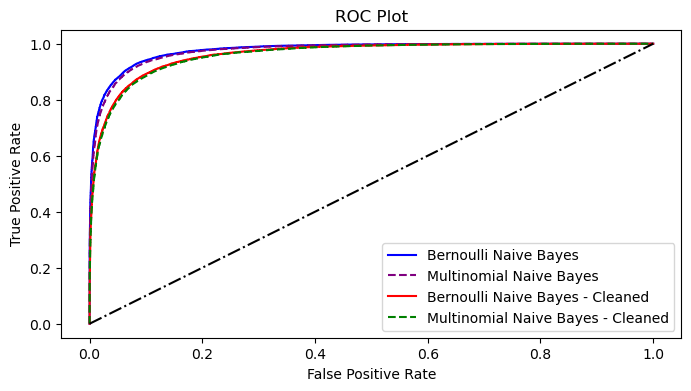

In [117]:
mnb_probs = mnb_pipeline.predict_proba(X_test)[:, 1]
mnb_fpr, mnb_tpr, mnb_thresholds = roc_curve(y_test_values, mnb_probs)

mnb_probs_clean = mnb_pipeline_clean.predict_proba(X_test_clean)[:, 1]
mnb_fpr_clean, mnb_tpr_clean, mnb_thresholds_clean = roc_curve(y_test_values, mnb_probs_clean)

bnb_probs = bnb_pipeline.predict_proba(X_test)[:, 1]
bnb_fpr, bnb_tpr, bnb_thresholds = roc_curve(y_test_values, bnb_probs)

bnb_probs_clean = bnb_pipeline_clean.predict_proba(X_test_clean)[:, 1]
bnb_fpr_clean, bnb_tpr_clean, bnb_thresholds_clean = roc_curve(y_test_values, bnb_probs_clean)

x = np.linspace(0, 1)

plt.style.use('default')

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(bnb_fpr, bnb_tpr, color = 'blue', label='Bernoulli Naive Bayes')
ax.plot(mnb_fpr, mnb_tpr, color ='purple', linestyle='--', label='Multinomial Naive Bayes')
ax.plot(bnb_fpr_clean, bnb_tpr_clean, color = 'red', label='Bernoulli Naive Bayes - Cleaned')
ax.plot(mnb_fpr_clean, mnb_tpr_clean, color = 'green', linestyle='--', label='Multinomial Naive Bayes - Cleaned')
ax.plot(x, x, color='black', linestyle='-.')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Plot')
ax.legend(loc='lower right');

#plt.savefig('NB_ROC.png')

In [122]:
probs = [mnb_probs, bnb_probs]
titles = ['Multinomial Naive Bayes', 'Bernoulli Naive Bayes']
scores = []

for idx, prob in enumerate(probs):
    score = roc_auc_score(y_test, prob)
    scores.append(score)
    print(f'\nModel: {titles[idx]}')
    print("The ROC AUC score for the model is {0:0.3f}.".format(score))

print(f'\nThe model with the largest AUC: {titles[int(np.where(scores == np.max(scores))[0])]}')


Model: Multinomial Naive Bayes
The ROC AUC score for the model is 0.975.

Model: Bernoulli Naive Bayes
The ROC AUC score for the model is 0.977.

The model with the largest AUC: Bernoulli Naive Bayes


## What texts does the best model have trouble with?

In [69]:
def get_misclassified_corpus(X_test, y_test, predicted):
    
    misclass = np.where((y_test != predicted))[0]
    misclass_idx = list(misclass)
    misclass_corpus = []
    for idx in misclass_idx:
        misclass_corpus.append(X_test.iloc[idx])

    fp = np.where((y_test == False) & (predicted == True))[0]
    fp_idx = list(fp)
    fp_corpus = []
    for idx in fp_idx:
        fp_corpus.append(X_test.iloc[idx])
    
    fn = np.where((y_test == True) & (predicted == False))[0]
    fn_idx = list(fn)
    fn_corpus = []
    for idx in fn_idx:
        fn_corpus.append(X_test.iloc[idx])
            
    return misclass_corpus, fp_corpus, fn_corpus

In [70]:
misclass_corpus, fp_corpus, fn_corpus = get_misclassified_corpus(X_test, y_test, bnb_predicted)

In [71]:
def make_word_cloud(corpus, wordcloud):
    corpus_clean = ' '.join(clean_corpus(corpus))
    word_cloud = wordcloud
    word_cloud.generate(corpus_clean)
    return word_cloud

In [72]:
wc_misclass = WordCloud(colormap="Paired", relative_scaling=1, max_words=None, max_font_size=40)
word_cloud_misclass = make_word_cloud(misclass_corpus, wc_misclass)

wc_fp = WordCloud(colormap="Paired", relative_scaling=1, max_words=None, max_font_size=40)
word_cloud_fp = make_word_cloud(fp_corpus, wc_fp)

wc_fn = WordCloud(colormap="Paired", relative_scaling=1, max_words=None, max_font_size=40)
word_cloud_fn = make_word_cloud(fn_corpus, wc_fn)

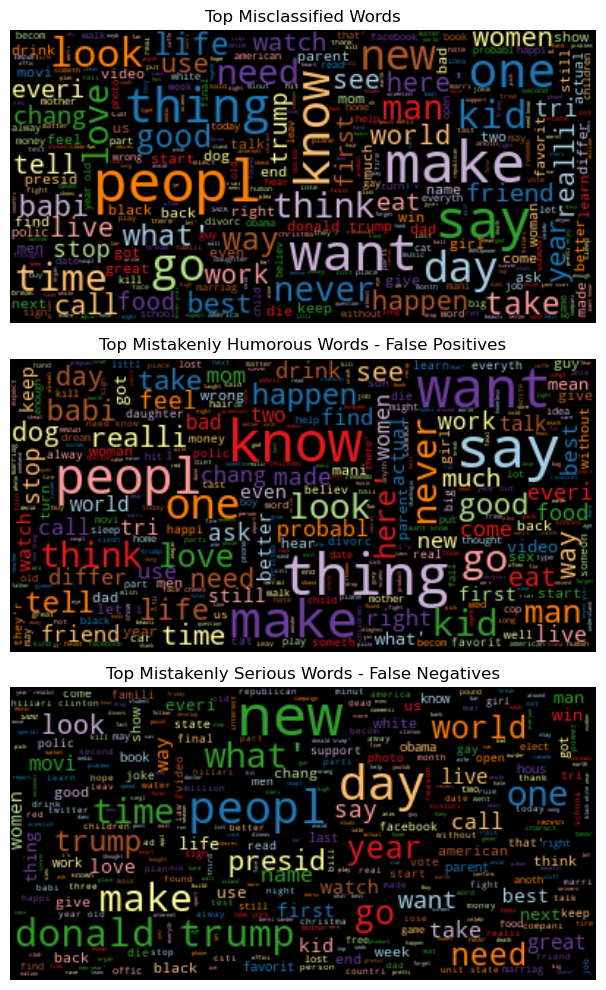

In [73]:
fig, axs = plt.subplots(3, 1, figsize=(10,10))
wordclouds = [word_cloud_misclass, word_cloud_fp, word_cloud_fn]
titles = ['Top Misclassified Words', 'Top Mistakenly Humorous Words - False Positives', 'Top Mistakenly Serious Words - False Negatives']

i = 0
for wordcloud, ax in zip(wordclouds, axs.flatten()):
    ax.imshow(wordcloud, interpolation = 'bilinear')
    ax.set_axis_off()
    ax.set_title(titles[i])
    i += 1
fig.tight_layout()

In [74]:
get_top_words(word_cloud_misclass, num_words=10)

'The top 10 words are: make, peopl, say, want, know, one, thing, go, new, day'

## Exploring elminating top misclassified words

In [75]:
def even_cleaner_corpus(X):
    corpus = [text.lower() for text in X]
    tokenizer = RegexpTokenizer("[\w']+")
    tokens = list(map(tokenizer.tokenize, corpus))
    
    punc = set(string.punctuation)
    tokens_no_punc = [[word for word in words if word not in punc]
        for words in tokens]
   
    s_words = set(stopwords.words('english'))
    add_word = ['make', 'one', 'thing', 'say', 'people', 'know', 'want', 'new', 'kid', 'go']
    for word in add_word:
        s_words.add(word)

    tokens_no_sw = [[word for word in words if word not in s_words]
        for words in tokens_no_punc]
    
    porter = PS()
    tokens_stemmed = [[porter.stem(word) for word in text] for text in tokens_no_sw]
    
    new_corpus = [' '.join(word) for word in tokens_stemmed]
    
    return new_corpus

In [76]:
X_train_even_cleaner = even_cleaner_corpus(X_train)
X_test_even_cleaner = even_cleaner_corpus(X_test)

In [77]:
bnb_pipeline_even_cleaner = Pipeline([('tfidf', TfidfVectorizer()),
                                      ('model', BernoulliNB())])

bnb_predicted_even_cleaner = fit_predict_model_accuracy(bnb_pipeline_even_cleaner, X_train_even_cleaner, y_train, X_test_even_cleaner, y_test)


The accuracy on the test set is 0.896.


In [78]:
cleaner_misclass_corpus, cleaner_fp_corpus, cleaner_fn_corpus = get_misclassified_corpus(X_test, y_test, bnb_predicted_even_cleaner)

In [79]:
def make_word_cloud_even_cleaner(corpus, wordcloud):
    corpus_clean = ' '.join(even_cleaner_corpus(corpus))
    word_cloud = wordcloud
    word_cloud.generate(corpus_clean)
    return word_cloud

In [80]:
cleaner_wc_misclass = WordCloud(colormap="Paired", relative_scaling=1, max_words=None, max_font_size=40)
cleaner_word_cloud_misclass = make_word_cloud_even_cleaner(cleaner_misclass_corpus, cleaner_wc_misclass)

cleaner_wc_fp = WordCloud(colormap="Paired", relative_scaling=1, max_words=None, max_font_size=40)
cleaner_word_cloud_fp = make_word_cloud_even_cleaner(cleaner_fp_corpus, cleaner_wc_fp)

cleaner_wc_fn = WordCloud(colormap="Paired", relative_scaling=1, max_words=None, max_font_size=40)
cleaner_word_cloud_fn = make_word_cloud_even_cleaner(cleaner_fn_corpus, cleaner_wc_fn)

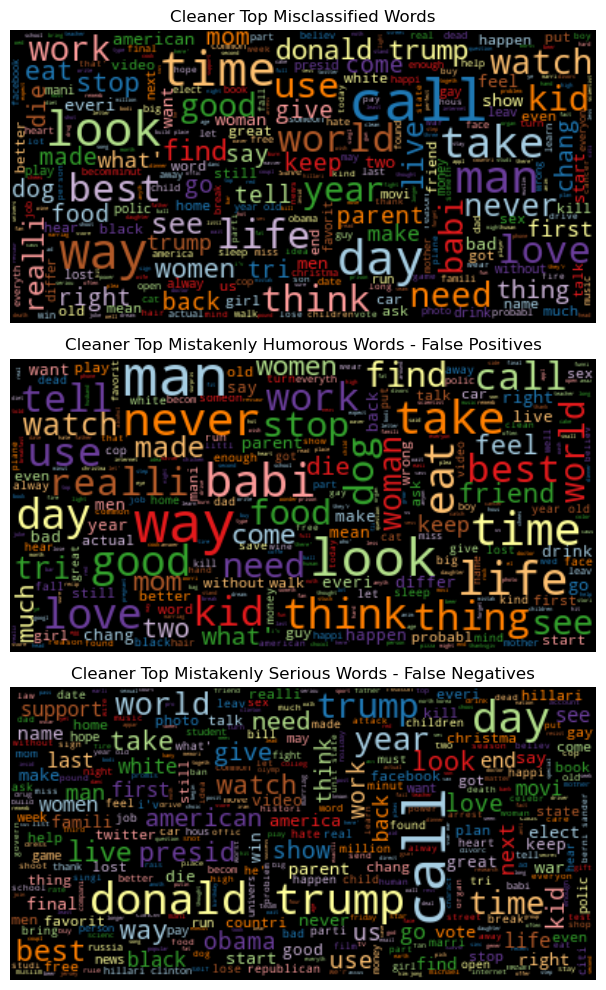

In [81]:
fig, axs = plt.subplots(3, 1, figsize=(10,10))
wordclouds = [cleaner_word_cloud_misclass, cleaner_word_cloud_fp, cleaner_word_cloud_fn]
titles = ['Cleaner Top Misclassified Words', 'Cleaner Top Mistakenly Humorous Words - False Positives', 'Cleaner Top Mistakenly Serious Words - False Negatives']

i = 0
for wordcloud, ax in zip(wordclouds, axs.flatten()):
    ax.imshow(wordcloud, interpolation = 'bilinear')
    ax.set_axis_off()
    ax.set_title(titles[i])
    i += 1
fig.tight_layout()

In [82]:
get_top_words(cleaner_word_cloud_misclass, num_words=10)

'The top 10 words are: call, way, look, day, time, man, take, life, best, world'

In [73]:
# false_positives = np.where((y_test == False) & (bnb_predicted == True))[0]
# false_positives, len(false_positives)

In [74]:
# false_negatives = np.where((y_test == True) & (bnb_predicted == False))[0]
# false_negatives, len(false_negatives)

In [75]:
# fp_idx_samps = list(np.random.choice(false_positives, 5, replace=False))
# fp_idx_samps

In [76]:
# fn_idx_samps = list(np.random.choice(false_negatives, 5, replace=False))
# fn_idx_samps

In [77]:
# print('False Positives:')
# for idx in fp_idx_samps:
#     print(f'Quote: {X_test.iloc[idx]}\n Label: {y_test.iloc[idx]} \n Prediction: {bnb_predicted[idx]}\n')

In [78]:
# print('False Negatives:')
# for idx in fn_idx_samps:
#     print(f'Quote: {X_test.iloc[idx]}\n Label: {y_test.iloc[idx]}\n Prediction: {bnb_predicted[idx]}\n')

In [115]:
# str(text_humor).lower().count('call')

In [116]:
# str(text_serious).lower().count('photo')

## To Do

* Plot KMeans visually if time 
* Combine all models on ROC plot
* Get more predictions from others
* README and slides
* Functionize code

Build model(s) to classify text as humorous or serious
* Identify different clusters/topics within humorous text
* Identify different clusters/topics of serious text

* NLP - TFIDF gives tokens but not order, etc
* Naive Bayes Text Classification - supervised
* Random Forest - supervised
* Basic NN, MLP - supervised
* K-means topic clustering - unsupervised
* PCA - from Chelsea: remember!! PCA components point in the direction of variance, and are sorted in descending order where the first component describes most variance. Don't forget that pca.variance_ (or explained_variance_? idk) tells you how much that component is describing and we can plot the "scree" to find how many components are worth keeping! so keeping all 10 components in your word cloud kept a lot of unsignificant words!
* Topic Modeling with NMF? - Unsupervised
* XGBoost? - might take too long

## Random Forest

In [262]:
# rf_pipeline = Pipeline([('tfidf', TfidfVectorizer(max_features=None)),
#                         ('model', RandomForestClassifier(n_estimators=5000, max_leaf_nodes=16, verbose=2))])
# rf_pipeline.fit(X_train, y_train)
# rf_predicted = rf_pipeline.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 5000
building tree 2 of 5000
building tree 3 of 5000
building tree 4 of 5000
building tree 5 of 5000
building tree 6 of 5000
building tree 7 of 5000
building tree 8 of 5000
building tree 9 of 5000
building tree 10 of 5000
building tree 11 of 5000
building tree 12 of 5000
building tree 13 of 5000
building tree 14 of 5000
building tree 15 of 5000
building tree 16 of 5000
building tree 17 of 5000
building tree 18 of 5000
building tree 19 of 5000
building tree 20 of 5000
building tree 21 of 5000
building tree 22 of 5000
building tree 23 of 5000
building tree 24 of 5000
building tree 25 of 5000
building tree 26 of 5000
building tree 27 of 5000
building tree 28 of 5000
building tree 29 of 5000
building tree 30 of 5000
building tree 31 of 5000
building tree 32 of 5000
building tree 33 of 5000
building tree 34 of 5000
building tree 35 of 5000
building tree 36 of 5000
building tree 37 of 5000
building tree 38 of 5000
building tree 39 of 5000
building tree 40 of 5000
building 

building tree 326 of 5000
building tree 327 of 5000
building tree 328 of 5000
building tree 329 of 5000
building tree 330 of 5000
building tree 331 of 5000
building tree 332 of 5000
building tree 333 of 5000
building tree 334 of 5000
building tree 335 of 5000
building tree 336 of 5000
building tree 337 of 5000
building tree 338 of 5000
building tree 339 of 5000
building tree 340 of 5000
building tree 341 of 5000
building tree 342 of 5000
building tree 343 of 5000
building tree 344 of 5000
building tree 345 of 5000
building tree 346 of 5000
building tree 347 of 5000
building tree 348 of 5000
building tree 349 of 5000
building tree 350 of 5000
building tree 351 of 5000
building tree 352 of 5000
building tree 353 of 5000
building tree 354 of 5000
building tree 355 of 5000
building tree 356 of 5000
building tree 357 of 5000
building tree 358 of 5000
building tree 359 of 5000
building tree 360 of 5000
building tree 361 of 5000
building tree 362 of 5000
building tree 363 of 5000
building tre

building tree 646 of 5000
building tree 647 of 5000
building tree 648 of 5000
building tree 649 of 5000
building tree 650 of 5000
building tree 651 of 5000
building tree 652 of 5000
building tree 653 of 5000
building tree 654 of 5000
building tree 655 of 5000
building tree 656 of 5000
building tree 657 of 5000
building tree 658 of 5000
building tree 659 of 5000
building tree 660 of 5000
building tree 661 of 5000
building tree 662 of 5000
building tree 663 of 5000
building tree 664 of 5000
building tree 665 of 5000
building tree 666 of 5000
building tree 667 of 5000
building tree 668 of 5000
building tree 669 of 5000
building tree 670 of 5000
building tree 671 of 5000
building tree 672 of 5000
building tree 673 of 5000
building tree 674 of 5000
building tree 675 of 5000
building tree 676 of 5000
building tree 677 of 5000
building tree 678 of 5000
building tree 679 of 5000
building tree 680 of 5000
building tree 681 of 5000
building tree 682 of 5000
building tree 683 of 5000
building tre

building tree 966 of 5000
building tree 967 of 5000
building tree 968 of 5000
building tree 969 of 5000
building tree 970 of 5000
building tree 971 of 5000
building tree 972 of 5000
building tree 973 of 5000
building tree 974 of 5000
building tree 975 of 5000
building tree 976 of 5000
building tree 977 of 5000
building tree 978 of 5000
building tree 979 of 5000
building tree 980 of 5000
building tree 981 of 5000
building tree 982 of 5000
building tree 983 of 5000
building tree 984 of 5000
building tree 985 of 5000
building tree 986 of 5000
building tree 987 of 5000
building tree 988 of 5000
building tree 989 of 5000
building tree 990 of 5000
building tree 991 of 5000
building tree 992 of 5000
building tree 993 of 5000
building tree 994 of 5000
building tree 995 of 5000
building tree 996 of 5000
building tree 997 of 5000
building tree 998 of 5000
building tree 999 of 5000
building tree 1000 of 5000
building tree 1001 of 5000
building tree 1002 of 5000
building tree 1003 of 5000
building

building tree 1273 of 5000
building tree 1274 of 5000
building tree 1275 of 5000
building tree 1276 of 5000
building tree 1277 of 5000
building tree 1278 of 5000
building tree 1279 of 5000
building tree 1280 of 5000
building tree 1281 of 5000
building tree 1282 of 5000
building tree 1283 of 5000
building tree 1284 of 5000
building tree 1285 of 5000
building tree 1286 of 5000
building tree 1287 of 5000
building tree 1288 of 5000
building tree 1289 of 5000
building tree 1290 of 5000
building tree 1291 of 5000
building tree 1292 of 5000
building tree 1293 of 5000
building tree 1294 of 5000
building tree 1295 of 5000
building tree 1296 of 5000
building tree 1297 of 5000
building tree 1298 of 5000
building tree 1299 of 5000
building tree 1300 of 5000
building tree 1301 of 5000
building tree 1302 of 5000
building tree 1303 of 5000
building tree 1304 of 5000
building tree 1305 of 5000
building tree 1306 of 5000
building tree 1307 of 5000
building tree 1308 of 5000
building tree 1309 of 5000
b

building tree 1580 of 5000
building tree 1581 of 5000
building tree 1582 of 5000
building tree 1583 of 5000
building tree 1584 of 5000
building tree 1585 of 5000
building tree 1586 of 5000
building tree 1587 of 5000
building tree 1588 of 5000
building tree 1589 of 5000
building tree 1590 of 5000
building tree 1591 of 5000
building tree 1592 of 5000
building tree 1593 of 5000
building tree 1594 of 5000
building tree 1595 of 5000
building tree 1596 of 5000
building tree 1597 of 5000
building tree 1598 of 5000
building tree 1599 of 5000
building tree 1600 of 5000
building tree 1601 of 5000
building tree 1602 of 5000
building tree 1603 of 5000
building tree 1604 of 5000
building tree 1605 of 5000
building tree 1606 of 5000
building tree 1607 of 5000
building tree 1608 of 5000
building tree 1609 of 5000
building tree 1610 of 5000
building tree 1611 of 5000
building tree 1612 of 5000
building tree 1613 of 5000
building tree 1614 of 5000
building tree 1615 of 5000
building tree 1616 of 5000
b

building tree 1884 of 5000
building tree 1885 of 5000
building tree 1886 of 5000
building tree 1887 of 5000
building tree 1888 of 5000
building tree 1889 of 5000
building tree 1890 of 5000
building tree 1891 of 5000
building tree 1892 of 5000
building tree 1893 of 5000
building tree 1894 of 5000
building tree 1895 of 5000
building tree 1896 of 5000
building tree 1897 of 5000
building tree 1898 of 5000
building tree 1899 of 5000
building tree 1900 of 5000
building tree 1901 of 5000
building tree 1902 of 5000
building tree 1903 of 5000
building tree 1904 of 5000
building tree 1905 of 5000
building tree 1906 of 5000
building tree 1907 of 5000
building tree 1908 of 5000
building tree 1909 of 5000
building tree 1910 of 5000
building tree 1911 of 5000
building tree 1912 of 5000
building tree 1913 of 5000
building tree 1914 of 5000
building tree 1915 of 5000
building tree 1916 of 5000
building tree 1917 of 5000
building tree 1918 of 5000
building tree 1919 of 5000
building tree 1920 of 5000
b

building tree 2192 of 5000
building tree 2193 of 5000
building tree 2194 of 5000
building tree 2195 of 5000
building tree 2196 of 5000
building tree 2197 of 5000
building tree 2198 of 5000
building tree 2199 of 5000
building tree 2200 of 5000
building tree 2201 of 5000
building tree 2202 of 5000
building tree 2203 of 5000
building tree 2204 of 5000
building tree 2205 of 5000
building tree 2206 of 5000
building tree 2207 of 5000
building tree 2208 of 5000
building tree 2209 of 5000
building tree 2210 of 5000
building tree 2211 of 5000
building tree 2212 of 5000
building tree 2213 of 5000
building tree 2214 of 5000
building tree 2215 of 5000
building tree 2216 of 5000
building tree 2217 of 5000
building tree 2218 of 5000
building tree 2219 of 5000
building tree 2220 of 5000
building tree 2221 of 5000
building tree 2222 of 5000
building tree 2223 of 5000
building tree 2224 of 5000
building tree 2225 of 5000
building tree 2226 of 5000
building tree 2227 of 5000
building tree 2228 of 5000
b

building tree 2500 of 5000
building tree 2501 of 5000
building tree 2502 of 5000
building tree 2503 of 5000
building tree 2504 of 5000
building tree 2505 of 5000
building tree 2506 of 5000
building tree 2507 of 5000
building tree 2508 of 5000
building tree 2509 of 5000
building tree 2510 of 5000
building tree 2511 of 5000
building tree 2512 of 5000
building tree 2513 of 5000
building tree 2514 of 5000
building tree 2515 of 5000
building tree 2516 of 5000
building tree 2517 of 5000
building tree 2518 of 5000
building tree 2519 of 5000
building tree 2520 of 5000
building tree 2521 of 5000
building tree 2522 of 5000
building tree 2523 of 5000
building tree 2524 of 5000
building tree 2525 of 5000
building tree 2526 of 5000
building tree 2527 of 5000
building tree 2528 of 5000
building tree 2529 of 5000
building tree 2530 of 5000
building tree 2531 of 5000
building tree 2532 of 5000
building tree 2533 of 5000
building tree 2534 of 5000
building tree 2535 of 5000
building tree 2536 of 5000
b

building tree 2805 of 5000
building tree 2806 of 5000
building tree 2807 of 5000
building tree 2808 of 5000
building tree 2809 of 5000
building tree 2810 of 5000
building tree 2811 of 5000
building tree 2812 of 5000
building tree 2813 of 5000
building tree 2814 of 5000
building tree 2815 of 5000
building tree 2816 of 5000
building tree 2817 of 5000
building tree 2818 of 5000
building tree 2819 of 5000
building tree 2820 of 5000
building tree 2821 of 5000
building tree 2822 of 5000
building tree 2823 of 5000
building tree 2824 of 5000
building tree 2825 of 5000
building tree 2826 of 5000
building tree 2827 of 5000
building tree 2828 of 5000
building tree 2829 of 5000
building tree 2830 of 5000
building tree 2831 of 5000
building tree 2832 of 5000
building tree 2833 of 5000
building tree 2834 of 5000
building tree 2835 of 5000
building tree 2836 of 5000
building tree 2837 of 5000
building tree 2838 of 5000
building tree 2839 of 5000
building tree 2840 of 5000
building tree 2841 of 5000
b

building tree 3111 of 5000
building tree 3112 of 5000
building tree 3113 of 5000
building tree 3114 of 5000
building tree 3115 of 5000
building tree 3116 of 5000
building tree 3117 of 5000
building tree 3118 of 5000
building tree 3119 of 5000
building tree 3120 of 5000
building tree 3121 of 5000
building tree 3122 of 5000
building tree 3123 of 5000
building tree 3124 of 5000
building tree 3125 of 5000
building tree 3126 of 5000
building tree 3127 of 5000
building tree 3128 of 5000
building tree 3129 of 5000
building tree 3130 of 5000
building tree 3131 of 5000
building tree 3132 of 5000
building tree 3133 of 5000
building tree 3134 of 5000
building tree 3135 of 5000
building tree 3136 of 5000
building tree 3137 of 5000
building tree 3138 of 5000
building tree 3139 of 5000
building tree 3140 of 5000
building tree 3141 of 5000
building tree 3142 of 5000
building tree 3143 of 5000
building tree 3144 of 5000
building tree 3145 of 5000
building tree 3146 of 5000
building tree 3147 of 5000
b

building tree 3417 of 5000
building tree 3418 of 5000
building tree 3419 of 5000
building tree 3420 of 5000
building tree 3421 of 5000
building tree 3422 of 5000
building tree 3423 of 5000
building tree 3424 of 5000
building tree 3425 of 5000
building tree 3426 of 5000
building tree 3427 of 5000
building tree 3428 of 5000
building tree 3429 of 5000
building tree 3430 of 5000
building tree 3431 of 5000
building tree 3432 of 5000
building tree 3433 of 5000
building tree 3434 of 5000
building tree 3435 of 5000
building tree 3436 of 5000
building tree 3437 of 5000
building tree 3438 of 5000
building tree 3439 of 5000
building tree 3440 of 5000
building tree 3441 of 5000
building tree 3442 of 5000
building tree 3443 of 5000
building tree 3444 of 5000
building tree 3445 of 5000
building tree 3446 of 5000
building tree 3447 of 5000
building tree 3448 of 5000
building tree 3449 of 5000
building tree 3450 of 5000
building tree 3451 of 5000
building tree 3452 of 5000
building tree 3453 of 5000
b

building tree 3724 of 5000
building tree 3725 of 5000
building tree 3726 of 5000
building tree 3727 of 5000
building tree 3728 of 5000
building tree 3729 of 5000
building tree 3730 of 5000
building tree 3731 of 5000
building tree 3732 of 5000
building tree 3733 of 5000
building tree 3734 of 5000
building tree 3735 of 5000
building tree 3736 of 5000
building tree 3737 of 5000
building tree 3738 of 5000
building tree 3739 of 5000
building tree 3740 of 5000
building tree 3741 of 5000
building tree 3742 of 5000
building tree 3743 of 5000
building tree 3744 of 5000
building tree 3745 of 5000
building tree 3746 of 5000
building tree 3747 of 5000
building tree 3748 of 5000
building tree 3749 of 5000
building tree 3750 of 5000
building tree 3751 of 5000
building tree 3752 of 5000
building tree 3753 of 5000
building tree 3754 of 5000
building tree 3755 of 5000
building tree 3756 of 5000
building tree 3757 of 5000
building tree 3758 of 5000
building tree 3759 of 5000
building tree 3760 of 5000
b

building tree 4031 of 5000
building tree 4032 of 5000
building tree 4033 of 5000
building tree 4034 of 5000
building tree 4035 of 5000
building tree 4036 of 5000
building tree 4037 of 5000
building tree 4038 of 5000
building tree 4039 of 5000
building tree 4040 of 5000
building tree 4041 of 5000
building tree 4042 of 5000
building tree 4043 of 5000
building tree 4044 of 5000
building tree 4045 of 5000
building tree 4046 of 5000
building tree 4047 of 5000
building tree 4048 of 5000
building tree 4049 of 5000
building tree 4050 of 5000
building tree 4051 of 5000
building tree 4052 of 5000
building tree 4053 of 5000
building tree 4054 of 5000
building tree 4055 of 5000
building tree 4056 of 5000
building tree 4057 of 5000
building tree 4058 of 5000
building tree 4059 of 5000
building tree 4060 of 5000
building tree 4061 of 5000
building tree 4062 of 5000
building tree 4063 of 5000
building tree 4064 of 5000
building tree 4065 of 5000
building tree 4066 of 5000
building tree 4067 of 5000
b

building tree 4339 of 5000
building tree 4340 of 5000
building tree 4341 of 5000
building tree 4342 of 5000
building tree 4343 of 5000
building tree 4344 of 5000
building tree 4345 of 5000
building tree 4346 of 5000
building tree 4347 of 5000
building tree 4348 of 5000
building tree 4349 of 5000
building tree 4350 of 5000
building tree 4351 of 5000
building tree 4352 of 5000
building tree 4353 of 5000
building tree 4354 of 5000
building tree 4355 of 5000
building tree 4356 of 5000
building tree 4357 of 5000
building tree 4358 of 5000
building tree 4359 of 5000
building tree 4360 of 5000
building tree 4361 of 5000
building tree 4362 of 5000
building tree 4363 of 5000
building tree 4364 of 5000
building tree 4365 of 5000
building tree 4366 of 5000
building tree 4367 of 5000
building tree 4368 of 5000
building tree 4369 of 5000
building tree 4370 of 5000
building tree 4371 of 5000
building tree 4372 of 5000
building tree 4373 of 5000
building tree 4374 of 5000
building tree 4375 of 5000
b

building tree 4644 of 5000
building tree 4645 of 5000
building tree 4646 of 5000
building tree 4647 of 5000
building tree 4648 of 5000
building tree 4649 of 5000
building tree 4650 of 5000
building tree 4651 of 5000
building tree 4652 of 5000
building tree 4653 of 5000
building tree 4654 of 5000
building tree 4655 of 5000
building tree 4656 of 5000
building tree 4657 of 5000
building tree 4658 of 5000
building tree 4659 of 5000
building tree 4660 of 5000
building tree 4661 of 5000
building tree 4662 of 5000
building tree 4663 of 5000
building tree 4664 of 5000
building tree 4665 of 5000
building tree 4666 of 5000
building tree 4667 of 5000
building tree 4668 of 5000
building tree 4669 of 5000
building tree 4670 of 5000
building tree 4671 of 5000
building tree 4672 of 5000
building tree 4673 of 5000
building tree 4674 of 5000
building tree 4675 of 5000
building tree 4676 of 5000
building tree 4677 of 5000
building tree 4678 of 5000
building tree 4679 of 5000
building tree 4680 of 5000
b

building tree 4952 of 5000
building tree 4953 of 5000
building tree 4954 of 5000
building tree 4955 of 5000
building tree 4956 of 5000
building tree 4957 of 5000
building tree 4958 of 5000
building tree 4959 of 5000
building tree 4960 of 5000
building tree 4961 of 5000
building tree 4962 of 5000
building tree 4963 of 5000
building tree 4964 of 5000
building tree 4965 of 5000
building tree 4966 of 5000
building tree 4967 of 5000
building tree 4968 of 5000
building tree 4969 of 5000
building tree 4970 of 5000
building tree 4971 of 5000
building tree 4972 of 5000
building tree 4973 of 5000
building tree 4974 of 5000
building tree 4975 of 5000
building tree 4976 of 5000
building tree 4977 of 5000
building tree 4978 of 5000
building tree 4979 of 5000
building tree 4980 of 5000
building tree 4981 of 5000
building tree 4982 of 5000
building tree 4983 of 5000
building tree 4984 of 5000
building tree 4985 of 5000
building tree 4986 of 5000
building tree 4987 of 5000
building tree 4988 of 5000
b

[Parallel(n_jobs=1)]: Done 5000 out of 5000 | elapsed:  3.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 5000 out of 5000 | elapsed:   31.6s finished


In [263]:
# print("\nThe accuracy on the test set is {0:0.3f}.".format(accuracy_score(y_test, rf_predicted)))
# print("\nThe precision on the test set is {0:0.3f}.".format(precision_score(y_test, rf_predicted)))
# print("\nThe recall on the test set is {0:0.3f}.".format(recall_score(y_test, rf_predicted)))


The accuracy on the test set is 0.870.

The precision on the test set is 0.895.

The recall on the test set is 0.838.


In [267]:
# num_trees = [100, 1000, 2000, 5000, 10000]
# accuracies = []

# for n in num_trees:
#     rf_pipeline = Pipeline([('tfidf', TfidfVectorizer(max_features=2000)),
#                         ('model', RandomForestClassifier(n_estimators=n, 
#                                                          max_leaf_nodes=16, 
#                                                          verbose=2))])

#     rf_pipeline.fit(X_train, y_train)
#     rf_predicted = rf_pipeline.predict(X_test)
#     accuracies.append(accuracy_score(y_test, rf_predicted))
    



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    5.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


building tree 1 of 1000
building tree 2 of 1000
building tree 3 of 1000
building tree 4 of 1000
building tree 5 of 1000
building tree 6 of 1000
building tree 7 of 1000
building tree 8 of 1000
building tree 9 of 1000
building tree 10 of 1000
building tree 11 of 1000
building tree 12 of 1000
building tree 13 of 1000
building tree 14 of 1000
building tree 15 of 1000
building tree 16 of 1000
building tree 17 of 1000
building tree 18 of 1000
building tree 19 of 1000
building tree 20 of 1000
building tree 21 of 1000
building tree 22 of 1000
building tree 23 of 1000
building tree 24 of 1000
building tree 25 of 1000
building tree 26 of 1000
building tree 27 of 1000
building tree 28 of 1000
building tree 29 of 1000
building tree 30 of 1000
building tree 31 of 1000
building tree 32 of 1000
building tree 33 of 1000
building tree 34 of 1000
building tree 35 of 1000
building tree 36 of 1000
building tree 37 of 1000
building tree 38 of 1000
building tree 39 of 1000
building tree 40 of 1000
building 

building tree 322 of 1000
building tree 323 of 1000
building tree 324 of 1000
building tree 325 of 1000
building tree 326 of 1000
building tree 327 of 1000
building tree 328 of 1000
building tree 329 of 1000
building tree 330 of 1000
building tree 331 of 1000
building tree 332 of 1000
building tree 333 of 1000
building tree 334 of 1000
building tree 335 of 1000
building tree 336 of 1000
building tree 337 of 1000
building tree 338 of 1000
building tree 339 of 1000
building tree 340 of 1000
building tree 341 of 1000
building tree 342 of 1000
building tree 343 of 1000
building tree 344 of 1000
building tree 345 of 1000
building tree 346 of 1000
building tree 347 of 1000
building tree 348 of 1000
building tree 349 of 1000
building tree 350 of 1000
building tree 351 of 1000
building tree 352 of 1000
building tree 353 of 1000
building tree 354 of 1000
building tree 355 of 1000
building tree 356 of 1000
building tree 357 of 1000
building tree 358 of 1000
building tree 359 of 1000
building tre

building tree 640 of 1000
building tree 641 of 1000
building tree 642 of 1000
building tree 643 of 1000
building tree 644 of 1000
building tree 645 of 1000
building tree 646 of 1000
building tree 647 of 1000
building tree 648 of 1000
building tree 649 of 1000
building tree 650 of 1000
building tree 651 of 1000
building tree 652 of 1000
building tree 653 of 1000
building tree 654 of 1000
building tree 655 of 1000
building tree 656 of 1000
building tree 657 of 1000
building tree 658 of 1000
building tree 659 of 1000
building tree 660 of 1000
building tree 661 of 1000
building tree 662 of 1000
building tree 663 of 1000
building tree 664 of 1000
building tree 665 of 1000
building tree 666 of 1000
building tree 667 of 1000
building tree 668 of 1000
building tree 669 of 1000
building tree 670 of 1000
building tree 671 of 1000
building tree 672 of 1000
building tree 673 of 1000
building tree 674 of 1000
building tree 675 of 1000
building tree 676 of 1000
building tree 677 of 1000
building tre

building tree 958 of 1000
building tree 959 of 1000
building tree 960 of 1000
building tree 961 of 1000
building tree 962 of 1000
building tree 963 of 1000
building tree 964 of 1000
building tree 965 of 1000
building tree 966 of 1000
building tree 967 of 1000
building tree 968 of 1000
building tree 969 of 1000
building tree 970 of 1000
building tree 971 of 1000
building tree 972 of 1000
building tree 973 of 1000
building tree 974 of 1000
building tree 975 of 1000
building tree 976 of 1000
building tree 977 of 1000
building tree 978 of 1000
building tree 979 of 1000
building tree 980 of 1000
building tree 981 of 1000
building tree 982 of 1000
building tree 983 of 1000
building tree 984 of 1000
building tree 985 of 1000
building tree 986 of 1000
building tree 987 of 1000
building tree 988 of 1000
building tree 989 of 1000
building tree 990 of 1000
building tree 991 of 1000
building tree 992 of 1000
building tree 993 of 1000
building tree 994 of 1000
building tree 995 of 1000
building tre

[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   52.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    3.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


building tree 1 of 2000
building tree 2 of 2000
building tree 3 of 2000
building tree 4 of 2000
building tree 5 of 2000
building tree 6 of 2000
building tree 7 of 2000
building tree 8 of 2000
building tree 9 of 2000
building tree 10 of 2000
building tree 11 of 2000
building tree 12 of 2000
building tree 13 of 2000
building tree 14 of 2000
building tree 15 of 2000
building tree 16 of 2000
building tree 17 of 2000
building tree 18 of 2000
building tree 19 of 2000
building tree 20 of 2000
building tree 21 of 2000
building tree 22 of 2000
building tree 23 of 2000
building tree 24 of 2000
building tree 25 of 2000
building tree 26 of 2000
building tree 27 of 2000
building tree 28 of 2000
building tree 29 of 2000
building tree 30 of 2000
building tree 31 of 2000
building tree 32 of 2000
building tree 33 of 2000
building tree 34 of 2000
building tree 35 of 2000
building tree 36 of 2000
building tree 37 of 2000
building tree 38 of 2000
building tree 39 of 2000
building tree 40 of 2000
building 

building tree 325 of 2000
building tree 326 of 2000
building tree 327 of 2000
building tree 328 of 2000
building tree 329 of 2000
building tree 330 of 2000
building tree 331 of 2000
building tree 332 of 2000
building tree 333 of 2000
building tree 334 of 2000
building tree 335 of 2000
building tree 336 of 2000
building tree 337 of 2000
building tree 338 of 2000
building tree 339 of 2000
building tree 340 of 2000
building tree 341 of 2000
building tree 342 of 2000
building tree 343 of 2000
building tree 344 of 2000
building tree 345 of 2000
building tree 346 of 2000
building tree 347 of 2000
building tree 348 of 2000
building tree 349 of 2000
building tree 350 of 2000
building tree 351 of 2000
building tree 352 of 2000
building tree 353 of 2000
building tree 354 of 2000
building tree 355 of 2000
building tree 356 of 2000
building tree 357 of 2000
building tree 358 of 2000
building tree 359 of 2000
building tree 360 of 2000
building tree 361 of 2000
building tree 362 of 2000
building tre

building tree 644 of 2000
building tree 645 of 2000
building tree 646 of 2000
building tree 647 of 2000
building tree 648 of 2000
building tree 649 of 2000
building tree 650 of 2000
building tree 651 of 2000
building tree 652 of 2000
building tree 653 of 2000
building tree 654 of 2000
building tree 655 of 2000
building tree 656 of 2000
building tree 657 of 2000
building tree 658 of 2000
building tree 659 of 2000
building tree 660 of 2000
building tree 661 of 2000
building tree 662 of 2000
building tree 663 of 2000
building tree 664 of 2000
building tree 665 of 2000
building tree 666 of 2000
building tree 667 of 2000
building tree 668 of 2000
building tree 669 of 2000
building tree 670 of 2000
building tree 671 of 2000
building tree 672 of 2000
building tree 673 of 2000
building tree 674 of 2000
building tree 675 of 2000
building tree 676 of 2000
building tree 677 of 2000
building tree 678 of 2000
building tree 679 of 2000
building tree 680 of 2000
building tree 681 of 2000
building tre

building tree 960 of 2000
building tree 961 of 2000
building tree 962 of 2000
building tree 963 of 2000
building tree 964 of 2000
building tree 965 of 2000
building tree 966 of 2000
building tree 967 of 2000
building tree 968 of 2000
building tree 969 of 2000
building tree 970 of 2000
building tree 971 of 2000
building tree 972 of 2000
building tree 973 of 2000
building tree 974 of 2000
building tree 975 of 2000
building tree 976 of 2000
building tree 977 of 2000
building tree 978 of 2000
building tree 979 of 2000
building tree 980 of 2000
building tree 981 of 2000
building tree 982 of 2000
building tree 983 of 2000
building tree 984 of 2000
building tree 985 of 2000
building tree 986 of 2000
building tree 987 of 2000
building tree 988 of 2000
building tree 989 of 2000
building tree 990 of 2000
building tree 991 of 2000
building tree 992 of 2000
building tree 993 of 2000
building tree 994 of 2000
building tree 995 of 2000
building tree 996 of 2000
building tree 997 of 2000
building tre

building tree 1268 of 2000
building tree 1269 of 2000
building tree 1270 of 2000
building tree 1271 of 2000
building tree 1272 of 2000
building tree 1273 of 2000
building tree 1274 of 2000
building tree 1275 of 2000
building tree 1276 of 2000
building tree 1277 of 2000
building tree 1278 of 2000
building tree 1279 of 2000
building tree 1280 of 2000
building tree 1281 of 2000
building tree 1282 of 2000
building tree 1283 of 2000
building tree 1284 of 2000
building tree 1285 of 2000
building tree 1286 of 2000
building tree 1287 of 2000
building tree 1288 of 2000
building tree 1289 of 2000
building tree 1290 of 2000
building tree 1291 of 2000
building tree 1292 of 2000
building tree 1293 of 2000
building tree 1294 of 2000
building tree 1295 of 2000
building tree 1296 of 2000
building tree 1297 of 2000
building tree 1298 of 2000
building tree 1299 of 2000
building tree 1300 of 2000
building tree 1301 of 2000
building tree 1302 of 2000
building tree 1303 of 2000
building tree 1304 of 2000
b

building tree 1572 of 2000
building tree 1573 of 2000
building tree 1574 of 2000
building tree 1575 of 2000
building tree 1576 of 2000
building tree 1577 of 2000
building tree 1578 of 2000
building tree 1579 of 2000
building tree 1580 of 2000
building tree 1581 of 2000
building tree 1582 of 2000
building tree 1583 of 2000
building tree 1584 of 2000
building tree 1585 of 2000
building tree 1586 of 2000
building tree 1587 of 2000
building tree 1588 of 2000
building tree 1589 of 2000
building tree 1590 of 2000
building tree 1591 of 2000
building tree 1592 of 2000
building tree 1593 of 2000
building tree 1594 of 2000
building tree 1595 of 2000
building tree 1596 of 2000
building tree 1597 of 2000
building tree 1598 of 2000
building tree 1599 of 2000
building tree 1600 of 2000
building tree 1601 of 2000
building tree 1602 of 2000
building tree 1603 of 2000
building tree 1604 of 2000
building tree 1605 of 2000
building tree 1606 of 2000
building tree 1607 of 2000
building tree 1608 of 2000
b

building tree 1879 of 2000
building tree 1880 of 2000
building tree 1881 of 2000
building tree 1882 of 2000
building tree 1883 of 2000
building tree 1884 of 2000
building tree 1885 of 2000
building tree 1886 of 2000
building tree 1887 of 2000
building tree 1888 of 2000
building tree 1889 of 2000
building tree 1890 of 2000
building tree 1891 of 2000
building tree 1892 of 2000
building tree 1893 of 2000
building tree 1894 of 2000
building tree 1895 of 2000
building tree 1896 of 2000
building tree 1897 of 2000
building tree 1898 of 2000
building tree 1899 of 2000
building tree 1900 of 2000
building tree 1901 of 2000
building tree 1902 of 2000
building tree 1903 of 2000
building tree 1904 of 2000
building tree 1905 of 2000
building tree 1906 of 2000
building tree 1907 of 2000
building tree 1908 of 2000
building tree 1909 of 2000
building tree 1910 of 2000
building tree 1911 of 2000
building tree 1912 of 2000
building tree 1913 of 2000
building tree 1914 of 2000
building tree 1915 of 2000
b

[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:    7.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


building tree 1 of 5000
building tree 2 of 5000
building tree 3 of 5000
building tree 4 of 5000
building tree 5 of 5000
building tree 6 of 5000
building tree 7 of 5000
building tree 8 of 5000
building tree 9 of 5000
building tree 10 of 5000
building tree 11 of 5000
building tree 12 of 5000
building tree 13 of 5000
building tree 14 of 5000
building tree 15 of 5000
building tree 16 of 5000
building tree 17 of 5000
building tree 18 of 5000
building tree 19 of 5000
building tree 20 of 5000
building tree 21 of 5000
building tree 22 of 5000
building tree 23 of 5000
building tree 24 of 5000
building tree 25 of 5000
building tree 26 of 5000
building tree 27 of 5000
building tree 28 of 5000
building tree 29 of 5000
building tree 30 of 5000
building tree 31 of 5000
building tree 32 of 5000
building tree 33 of 5000
building tree 34 of 5000
building tree 35 of 5000
building tree 36 of 5000
building tree 37 of 5000
building tree 38 of 5000
building tree 39 of 5000
building tree 40 of 5000
building 

building tree 323 of 5000
building tree 324 of 5000
building tree 325 of 5000
building tree 326 of 5000
building tree 327 of 5000
building tree 328 of 5000
building tree 329 of 5000
building tree 330 of 5000
building tree 331 of 5000
building tree 332 of 5000
building tree 333 of 5000
building tree 334 of 5000
building tree 335 of 5000
building tree 336 of 5000
building tree 337 of 5000
building tree 338 of 5000
building tree 339 of 5000
building tree 340 of 5000
building tree 341 of 5000
building tree 342 of 5000
building tree 343 of 5000
building tree 344 of 5000
building tree 345 of 5000
building tree 346 of 5000
building tree 347 of 5000
building tree 348 of 5000
building tree 349 of 5000
building tree 350 of 5000
building tree 351 of 5000
building tree 352 of 5000
building tree 353 of 5000
building tree 354 of 5000
building tree 355 of 5000
building tree 356 of 5000
building tree 357 of 5000
building tree 358 of 5000
building tree 359 of 5000
building tree 360 of 5000
building tre

building tree 639 of 5000
building tree 640 of 5000
building tree 641 of 5000
building tree 642 of 5000
building tree 643 of 5000
building tree 644 of 5000
building tree 645 of 5000
building tree 646 of 5000
building tree 647 of 5000
building tree 648 of 5000
building tree 649 of 5000
building tree 650 of 5000
building tree 651 of 5000
building tree 652 of 5000
building tree 653 of 5000
building tree 654 of 5000
building tree 655 of 5000
building tree 656 of 5000
building tree 657 of 5000
building tree 658 of 5000
building tree 659 of 5000
building tree 660 of 5000
building tree 661 of 5000
building tree 662 of 5000
building tree 663 of 5000
building tree 664 of 5000
building tree 665 of 5000
building tree 666 of 5000
building tree 667 of 5000
building tree 668 of 5000
building tree 669 of 5000
building tree 670 of 5000
building tree 671 of 5000
building tree 672 of 5000
building tree 673 of 5000
building tree 674 of 5000
building tree 675 of 5000
building tree 676 of 5000
building tre

building tree 957 of 5000
building tree 958 of 5000
building tree 959 of 5000
building tree 960 of 5000
building tree 961 of 5000
building tree 962 of 5000
building tree 963 of 5000
building tree 964 of 5000
building tree 965 of 5000
building tree 966 of 5000
building tree 967 of 5000
building tree 968 of 5000
building tree 969 of 5000
building tree 970 of 5000
building tree 971 of 5000
building tree 972 of 5000
building tree 973 of 5000
building tree 974 of 5000
building tree 975 of 5000
building tree 976 of 5000
building tree 977 of 5000
building tree 978 of 5000
building tree 979 of 5000
building tree 980 of 5000
building tree 981 of 5000
building tree 982 of 5000
building tree 983 of 5000
building tree 984 of 5000
building tree 985 of 5000
building tree 986 of 5000
building tree 987 of 5000
building tree 988 of 5000
building tree 989 of 5000
building tree 990 of 5000
building tree 991 of 5000
building tree 992 of 5000
building tree 993 of 5000
building tree 994 of 5000
building tre

building tree 1266 of 5000
building tree 1267 of 5000
building tree 1268 of 5000
building tree 1269 of 5000
building tree 1270 of 5000
building tree 1271 of 5000
building tree 1272 of 5000
building tree 1273 of 5000
building tree 1274 of 5000
building tree 1275 of 5000
building tree 1276 of 5000
building tree 1277 of 5000
building tree 1278 of 5000
building tree 1279 of 5000
building tree 1280 of 5000
building tree 1281 of 5000
building tree 1282 of 5000
building tree 1283 of 5000
building tree 1284 of 5000
building tree 1285 of 5000
building tree 1286 of 5000
building tree 1287 of 5000
building tree 1288 of 5000
building tree 1289 of 5000
building tree 1290 of 5000
building tree 1291 of 5000
building tree 1292 of 5000
building tree 1293 of 5000
building tree 1294 of 5000
building tree 1295 of 5000
building tree 1296 of 5000
building tree 1297 of 5000
building tree 1298 of 5000
building tree 1299 of 5000
building tree 1300 of 5000
building tree 1301 of 5000
building tree 1302 of 5000
b

building tree 1573 of 5000
building tree 1574 of 5000
building tree 1575 of 5000
building tree 1576 of 5000
building tree 1577 of 5000
building tree 1578 of 5000
building tree 1579 of 5000
building tree 1580 of 5000
building tree 1581 of 5000
building tree 1582 of 5000
building tree 1583 of 5000
building tree 1584 of 5000
building tree 1585 of 5000
building tree 1586 of 5000
building tree 1587 of 5000
building tree 1588 of 5000
building tree 1589 of 5000
building tree 1590 of 5000
building tree 1591 of 5000
building tree 1592 of 5000
building tree 1593 of 5000
building tree 1594 of 5000
building tree 1595 of 5000
building tree 1596 of 5000
building tree 1597 of 5000
building tree 1598 of 5000
building tree 1599 of 5000
building tree 1600 of 5000
building tree 1601 of 5000
building tree 1602 of 5000
building tree 1603 of 5000
building tree 1604 of 5000
building tree 1605 of 5000
building tree 1606 of 5000
building tree 1607 of 5000
building tree 1608 of 5000
building tree 1609 of 5000
b

building tree 1879 of 5000
building tree 1880 of 5000
building tree 1881 of 5000
building tree 1882 of 5000
building tree 1883 of 5000
building tree 1884 of 5000
building tree 1885 of 5000
building tree 1886 of 5000
building tree 1887 of 5000
building tree 1888 of 5000
building tree 1889 of 5000
building tree 1890 of 5000
building tree 1891 of 5000
building tree 1892 of 5000
building tree 1893 of 5000
building tree 1894 of 5000
building tree 1895 of 5000
building tree 1896 of 5000
building tree 1897 of 5000
building tree 1898 of 5000
building tree 1899 of 5000
building tree 1900 of 5000
building tree 1901 of 5000
building tree 1902 of 5000
building tree 1903 of 5000
building tree 1904 of 5000
building tree 1905 of 5000
building tree 1906 of 5000
building tree 1907 of 5000
building tree 1908 of 5000
building tree 1909 of 5000
building tree 1910 of 5000
building tree 1911 of 5000
building tree 1912 of 5000
building tree 1913 of 5000
building tree 1914 of 5000
building tree 1915 of 5000
b

building tree 2186 of 5000
building tree 2187 of 5000
building tree 2188 of 5000
building tree 2189 of 5000
building tree 2190 of 5000
building tree 2191 of 5000
building tree 2192 of 5000
building tree 2193 of 5000
building tree 2194 of 5000
building tree 2195 of 5000
building tree 2196 of 5000
building tree 2197 of 5000
building tree 2198 of 5000
building tree 2199 of 5000
building tree 2200 of 5000
building tree 2201 of 5000
building tree 2202 of 5000
building tree 2203 of 5000
building tree 2204 of 5000
building tree 2205 of 5000
building tree 2206 of 5000
building tree 2207 of 5000
building tree 2208 of 5000
building tree 2209 of 5000
building tree 2210 of 5000
building tree 2211 of 5000
building tree 2212 of 5000
building tree 2213 of 5000
building tree 2214 of 5000
building tree 2215 of 5000
building tree 2216 of 5000
building tree 2217 of 5000
building tree 2218 of 5000
building tree 2219 of 5000
building tree 2220 of 5000
building tree 2221 of 5000
building tree 2222 of 5000
b

building tree 2493 of 5000
building tree 2494 of 5000
building tree 2495 of 5000
building tree 2496 of 5000
building tree 2497 of 5000
building tree 2498 of 5000
building tree 2499 of 5000
building tree 2500 of 5000
building tree 2501 of 5000
building tree 2502 of 5000
building tree 2503 of 5000
building tree 2504 of 5000
building tree 2505 of 5000
building tree 2506 of 5000
building tree 2507 of 5000
building tree 2508 of 5000
building tree 2509 of 5000
building tree 2510 of 5000
building tree 2511 of 5000
building tree 2512 of 5000
building tree 2513 of 5000
building tree 2514 of 5000
building tree 2515 of 5000
building tree 2516 of 5000
building tree 2517 of 5000
building tree 2518 of 5000
building tree 2519 of 5000
building tree 2520 of 5000
building tree 2521 of 5000
building tree 2522 of 5000
building tree 2523 of 5000
building tree 2524 of 5000
building tree 2525 of 5000
building tree 2526 of 5000
building tree 2527 of 5000
building tree 2528 of 5000
building tree 2529 of 5000
b

building tree 2801 of 5000
building tree 2802 of 5000
building tree 2803 of 5000
building tree 2804 of 5000
building tree 2805 of 5000
building tree 2806 of 5000
building tree 2807 of 5000
building tree 2808 of 5000
building tree 2809 of 5000
building tree 2810 of 5000
building tree 2811 of 5000
building tree 2812 of 5000
building tree 2813 of 5000
building tree 2814 of 5000
building tree 2815 of 5000
building tree 2816 of 5000
building tree 2817 of 5000
building tree 2818 of 5000
building tree 2819 of 5000
building tree 2820 of 5000
building tree 2821 of 5000
building tree 2822 of 5000
building tree 2823 of 5000
building tree 2824 of 5000
building tree 2825 of 5000
building tree 2826 of 5000
building tree 2827 of 5000
building tree 2828 of 5000
building tree 2829 of 5000
building tree 2830 of 5000
building tree 2831 of 5000
building tree 2832 of 5000
building tree 2833 of 5000
building tree 2834 of 5000
building tree 2835 of 5000
building tree 2836 of 5000
building tree 2837 of 5000
b

building tree 3108 of 5000
building tree 3109 of 5000
building tree 3110 of 5000
building tree 3111 of 5000
building tree 3112 of 5000
building tree 3113 of 5000
building tree 3114 of 5000
building tree 3115 of 5000
building tree 3116 of 5000
building tree 3117 of 5000
building tree 3118 of 5000
building tree 3119 of 5000
building tree 3120 of 5000
building tree 3121 of 5000
building tree 3122 of 5000
building tree 3123 of 5000
building tree 3124 of 5000
building tree 3125 of 5000
building tree 3126 of 5000
building tree 3127 of 5000
building tree 3128 of 5000
building tree 3129 of 5000
building tree 3130 of 5000
building tree 3131 of 5000
building tree 3132 of 5000
building tree 3133 of 5000
building tree 3134 of 5000
building tree 3135 of 5000
building tree 3136 of 5000
building tree 3137 of 5000
building tree 3138 of 5000
building tree 3139 of 5000
building tree 3140 of 5000
building tree 3141 of 5000
building tree 3142 of 5000
building tree 3143 of 5000
building tree 3144 of 5000
b

building tree 3413 of 5000
building tree 3414 of 5000
building tree 3415 of 5000
building tree 3416 of 5000
building tree 3417 of 5000
building tree 3418 of 5000
building tree 3419 of 5000
building tree 3420 of 5000
building tree 3421 of 5000
building tree 3422 of 5000
building tree 3423 of 5000
building tree 3424 of 5000
building tree 3425 of 5000
building tree 3426 of 5000
building tree 3427 of 5000
building tree 3428 of 5000
building tree 3429 of 5000
building tree 3430 of 5000
building tree 3431 of 5000
building tree 3432 of 5000
building tree 3433 of 5000
building tree 3434 of 5000
building tree 3435 of 5000
building tree 3436 of 5000
building tree 3437 of 5000
building tree 3438 of 5000
building tree 3439 of 5000
building tree 3440 of 5000
building tree 3441 of 5000
building tree 3442 of 5000
building tree 3443 of 5000
building tree 3444 of 5000
building tree 3445 of 5000
building tree 3446 of 5000
building tree 3447 of 5000
building tree 3448 of 5000
building tree 3449 of 5000
b

building tree 3720 of 5000
building tree 3721 of 5000
building tree 3722 of 5000
building tree 3723 of 5000
building tree 3724 of 5000
building tree 3725 of 5000
building tree 3726 of 5000
building tree 3727 of 5000
building tree 3728 of 5000
building tree 3729 of 5000
building tree 3730 of 5000
building tree 3731 of 5000
building tree 3732 of 5000
building tree 3733 of 5000
building tree 3734 of 5000
building tree 3735 of 5000
building tree 3736 of 5000
building tree 3737 of 5000
building tree 3738 of 5000
building tree 3739 of 5000
building tree 3740 of 5000
building tree 3741 of 5000
building tree 3742 of 5000
building tree 3743 of 5000
building tree 3744 of 5000
building tree 3745 of 5000
building tree 3746 of 5000
building tree 3747 of 5000
building tree 3748 of 5000
building tree 3749 of 5000
building tree 3750 of 5000
building tree 3751 of 5000
building tree 3752 of 5000
building tree 3753 of 5000
building tree 3754 of 5000
building tree 3755 of 5000
building tree 3756 of 5000
b

building tree 4024 of 5000
building tree 4025 of 5000
building tree 4026 of 5000
building tree 4027 of 5000
building tree 4028 of 5000
building tree 4029 of 5000
building tree 4030 of 5000
building tree 4031 of 5000
building tree 4032 of 5000
building tree 4033 of 5000
building tree 4034 of 5000
building tree 4035 of 5000
building tree 4036 of 5000
building tree 4037 of 5000
building tree 4038 of 5000
building tree 4039 of 5000
building tree 4040 of 5000
building tree 4041 of 5000
building tree 4042 of 5000
building tree 4043 of 5000
building tree 4044 of 5000
building tree 4045 of 5000
building tree 4046 of 5000
building tree 4047 of 5000
building tree 4048 of 5000
building tree 4049 of 5000
building tree 4050 of 5000
building tree 4051 of 5000
building tree 4052 of 5000
building tree 4053 of 5000
building tree 4054 of 5000
building tree 4055 of 5000
building tree 4056 of 5000
building tree 4057 of 5000
building tree 4058 of 5000
building tree 4059 of 5000
building tree 4060 of 5000
b

building tree 4331 of 5000
building tree 4332 of 5000
building tree 4333 of 5000
building tree 4334 of 5000
building tree 4335 of 5000
building tree 4336 of 5000
building tree 4337 of 5000
building tree 4338 of 5000
building tree 4339 of 5000
building tree 4340 of 5000
building tree 4341 of 5000
building tree 4342 of 5000
building tree 4343 of 5000
building tree 4344 of 5000
building tree 4345 of 5000
building tree 4346 of 5000
building tree 4347 of 5000
building tree 4348 of 5000
building tree 4349 of 5000
building tree 4350 of 5000
building tree 4351 of 5000
building tree 4352 of 5000
building tree 4353 of 5000
building tree 4354 of 5000
building tree 4355 of 5000
building tree 4356 of 5000
building tree 4357 of 5000
building tree 4358 of 5000
building tree 4359 of 5000
building tree 4360 of 5000
building tree 4361 of 5000
building tree 4362 of 5000
building tree 4363 of 5000
building tree 4364 of 5000
building tree 4365 of 5000
building tree 4366 of 5000
building tree 4367 of 5000
b

building tree 4637 of 5000
building tree 4638 of 5000
building tree 4639 of 5000
building tree 4640 of 5000
building tree 4641 of 5000
building tree 4642 of 5000
building tree 4643 of 5000
building tree 4644 of 5000
building tree 4645 of 5000
building tree 4646 of 5000
building tree 4647 of 5000
building tree 4648 of 5000
building tree 4649 of 5000
building tree 4650 of 5000
building tree 4651 of 5000
building tree 4652 of 5000
building tree 4653 of 5000
building tree 4654 of 5000
building tree 4655 of 5000
building tree 4656 of 5000
building tree 4657 of 5000
building tree 4658 of 5000
building tree 4659 of 5000
building tree 4660 of 5000
building tree 4661 of 5000
building tree 4662 of 5000
building tree 4663 of 5000
building tree 4664 of 5000
building tree 4665 of 5000
building tree 4666 of 5000
building tree 4667 of 5000
building tree 4668 of 5000
building tree 4669 of 5000
building tree 4670 of 5000
building tree 4671 of 5000
building tree 4672 of 5000
building tree 4673 of 5000
b

building tree 4941 of 5000
building tree 4942 of 5000
building tree 4943 of 5000
building tree 4944 of 5000
building tree 4945 of 5000
building tree 4946 of 5000
building tree 4947 of 5000
building tree 4948 of 5000
building tree 4949 of 5000
building tree 4950 of 5000
building tree 4951 of 5000
building tree 4952 of 5000
building tree 4953 of 5000
building tree 4954 of 5000
building tree 4955 of 5000
building tree 4956 of 5000
building tree 4957 of 5000
building tree 4958 of 5000
building tree 4959 of 5000
building tree 4960 of 5000
building tree 4961 of 5000
building tree 4962 of 5000
building tree 4963 of 5000
building tree 4964 of 5000
building tree 4965 of 5000
building tree 4966 of 5000
building tree 4967 of 5000
building tree 4968 of 5000
building tree 4969 of 5000
building tree 4970 of 5000
building tree 4971 of 5000
building tree 4972 of 5000
building tree 4973 of 5000
building tree 4974 of 5000
building tree 4975 of 5000
building tree 4976 of 5000
building tree 4977 of 5000
b

[Parallel(n_jobs=1)]: Done 5000 out of 5000 | elapsed:  4.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 5000 out of 5000 | elapsed:   18.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


building tree 1 of 10000
building tree 2 of 10000
building tree 3 of 10000
building tree 4 of 10000
building tree 5 of 10000
building tree 6 of 10000
building tree 7 of 10000
building tree 8 of 10000
building tree 9 of 10000
building tree 10 of 10000
building tree 11 of 10000
building tree 12 of 10000
building tree 13 of 10000
building tree 14 of 10000
building tree 15 of 10000
building tree 16 of 10000
building tree 17 of 10000
building tree 18 of 10000
building tree 19 of 10000
building tree 20 of 10000
building tree 21 of 10000
building tree 22 of 10000
building tree 23 of 10000
building tree 24 of 10000
building tree 25 of 10000
building tree 26 of 10000
building tree 27 of 10000
building tree 28 of 10000
building tree 29 of 10000
building tree 30 of 10000
building tree 31 of 10000
building tree 32 of 10000
building tree 33 of 10000
building tree 34 of 10000
building tree 35 of 10000
building tree 36 of 10000
building tree 37 of 10000
building tree 38 of 10000
building tree 39 of 1

building tree 312 of 10000
building tree 313 of 10000
building tree 314 of 10000
building tree 315 of 10000
building tree 316 of 10000
building tree 317 of 10000
building tree 318 of 10000
building tree 319 of 10000
building tree 320 of 10000
building tree 321 of 10000
building tree 322 of 10000
building tree 323 of 10000
building tree 324 of 10000
building tree 325 of 10000
building tree 326 of 10000
building tree 327 of 10000
building tree 328 of 10000
building tree 329 of 10000
building tree 330 of 10000
building tree 331 of 10000
building tree 332 of 10000
building tree 333 of 10000
building tree 334 of 10000
building tree 335 of 10000
building tree 336 of 10000
building tree 337 of 10000
building tree 338 of 10000
building tree 339 of 10000
building tree 340 of 10000
building tree 341 of 10000
building tree 342 of 10000
building tree 343 of 10000
building tree 344 of 10000
building tree 345 of 10000
building tree 346 of 10000
building tree 347 of 10000
building tree 348 of 10000
b

building tree 618 of 10000
building tree 619 of 10000
building tree 620 of 10000
building tree 621 of 10000
building tree 622 of 10000
building tree 623 of 10000
building tree 624 of 10000
building tree 625 of 10000
building tree 626 of 10000
building tree 627 of 10000
building tree 628 of 10000
building tree 629 of 10000
building tree 630 of 10000
building tree 631 of 10000
building tree 632 of 10000
building tree 633 of 10000
building tree 634 of 10000
building tree 635 of 10000
building tree 636 of 10000
building tree 637 of 10000
building tree 638 of 10000
building tree 639 of 10000
building tree 640 of 10000
building tree 641 of 10000
building tree 642 of 10000
building tree 643 of 10000
building tree 644 of 10000
building tree 645 of 10000
building tree 646 of 10000
building tree 647 of 10000
building tree 648 of 10000
building tree 649 of 10000
building tree 650 of 10000
building tree 651 of 10000
building tree 652 of 10000
building tree 653 of 10000
building tree 654 of 10000
b

building tree 925 of 10000
building tree 926 of 10000
building tree 927 of 10000
building tree 928 of 10000
building tree 929 of 10000
building tree 930 of 10000
building tree 931 of 10000
building tree 932 of 10000
building tree 933 of 10000
building tree 934 of 10000
building tree 935 of 10000
building tree 936 of 10000
building tree 937 of 10000
building tree 938 of 10000
building tree 939 of 10000
building tree 940 of 10000
building tree 941 of 10000
building tree 942 of 10000
building tree 943 of 10000
building tree 944 of 10000
building tree 945 of 10000
building tree 946 of 10000
building tree 947 of 10000
building tree 948 of 10000
building tree 949 of 10000
building tree 950 of 10000
building tree 951 of 10000
building tree 952 of 10000
building tree 953 of 10000
building tree 954 of 10000
building tree 955 of 10000
building tree 956 of 10000
building tree 957 of 10000
building tree 958 of 10000
building tree 959 of 10000
building tree 960 of 10000
building tree 961 of 10000
b

building tree 1221 of 10000
building tree 1222 of 10000
building tree 1223 of 10000
building tree 1224 of 10000
building tree 1225 of 10000
building tree 1226 of 10000
building tree 1227 of 10000
building tree 1228 of 10000
building tree 1229 of 10000
building tree 1230 of 10000
building tree 1231 of 10000
building tree 1232 of 10000
building tree 1233 of 10000
building tree 1234 of 10000
building tree 1235 of 10000
building tree 1236 of 10000
building tree 1237 of 10000
building tree 1238 of 10000
building tree 1239 of 10000
building tree 1240 of 10000
building tree 1241 of 10000
building tree 1242 of 10000
building tree 1243 of 10000
building tree 1244 of 10000
building tree 1245 of 10000
building tree 1246 of 10000
building tree 1247 of 10000
building tree 1248 of 10000
building tree 1249 of 10000
building tree 1250 of 10000
building tree 1251 of 10000
building tree 1252 of 10000
building tree 1253 of 10000
building tree 1254 of 10000
building tree 1255 of 10000
building tree 1256 o

building tree 1518 of 10000
building tree 1519 of 10000
building tree 1520 of 10000
building tree 1521 of 10000
building tree 1522 of 10000
building tree 1523 of 10000
building tree 1524 of 10000
building tree 1525 of 10000
building tree 1526 of 10000
building tree 1527 of 10000
building tree 1528 of 10000
building tree 1529 of 10000
building tree 1530 of 10000
building tree 1531 of 10000
building tree 1532 of 10000
building tree 1533 of 10000
building tree 1534 of 10000
building tree 1535 of 10000
building tree 1536 of 10000
building tree 1537 of 10000
building tree 1538 of 10000
building tree 1539 of 10000
building tree 1540 of 10000
building tree 1541 of 10000
building tree 1542 of 10000
building tree 1543 of 10000
building tree 1544 of 10000
building tree 1545 of 10000
building tree 1546 of 10000
building tree 1547 of 10000
building tree 1548 of 10000
building tree 1549 of 10000
building tree 1550 of 10000
building tree 1551 of 10000
building tree 1552 of 10000
building tree 1553 o

building tree 1811 of 10000
building tree 1812 of 10000
building tree 1813 of 10000
building tree 1814 of 10000
building tree 1815 of 10000
building tree 1816 of 10000
building tree 1817 of 10000
building tree 1818 of 10000
building tree 1819 of 10000
building tree 1820 of 10000
building tree 1821 of 10000
building tree 1822 of 10000
building tree 1823 of 10000
building tree 1824 of 10000
building tree 1825 of 10000
building tree 1826 of 10000
building tree 1827 of 10000
building tree 1828 of 10000
building tree 1829 of 10000
building tree 1830 of 10000
building tree 1831 of 10000
building tree 1832 of 10000
building tree 1833 of 10000
building tree 1834 of 10000
building tree 1835 of 10000
building tree 1836 of 10000
building tree 1837 of 10000
building tree 1838 of 10000
building tree 1839 of 10000
building tree 1840 of 10000
building tree 1841 of 10000
building tree 1842 of 10000
building tree 1843 of 10000
building tree 1844 of 10000
building tree 1845 of 10000
building tree 1846 o

building tree 2108 of 10000
building tree 2109 of 10000
building tree 2110 of 10000
building tree 2111 of 10000
building tree 2112 of 10000
building tree 2113 of 10000
building tree 2114 of 10000
building tree 2115 of 10000
building tree 2116 of 10000
building tree 2117 of 10000
building tree 2118 of 10000
building tree 2119 of 10000
building tree 2120 of 10000
building tree 2121 of 10000
building tree 2122 of 10000
building tree 2123 of 10000
building tree 2124 of 10000
building tree 2125 of 10000
building tree 2126 of 10000
building tree 2127 of 10000
building tree 2128 of 10000
building tree 2129 of 10000
building tree 2130 of 10000
building tree 2131 of 10000
building tree 2132 of 10000
building tree 2133 of 10000
building tree 2134 of 10000
building tree 2135 of 10000
building tree 2136 of 10000
building tree 2137 of 10000
building tree 2138 of 10000
building tree 2139 of 10000
building tree 2140 of 10000
building tree 2141 of 10000
building tree 2142 of 10000
building tree 2143 o

building tree 2402 of 10000
building tree 2403 of 10000
building tree 2404 of 10000
building tree 2405 of 10000
building tree 2406 of 10000
building tree 2407 of 10000
building tree 2408 of 10000
building tree 2409 of 10000
building tree 2410 of 10000
building tree 2411 of 10000
building tree 2412 of 10000
building tree 2413 of 10000
building tree 2414 of 10000
building tree 2415 of 10000
building tree 2416 of 10000
building tree 2417 of 10000
building tree 2418 of 10000
building tree 2419 of 10000
building tree 2420 of 10000
building tree 2421 of 10000
building tree 2422 of 10000
building tree 2423 of 10000
building tree 2424 of 10000
building tree 2425 of 10000
building tree 2426 of 10000
building tree 2427 of 10000
building tree 2428 of 10000
building tree 2429 of 10000
building tree 2430 of 10000
building tree 2431 of 10000
building tree 2432 of 10000
building tree 2433 of 10000
building tree 2434 of 10000
building tree 2435 of 10000
building tree 2436 of 10000
building tree 2437 o

building tree 2695 of 10000
building tree 2696 of 10000
building tree 2697 of 10000
building tree 2698 of 10000
building tree 2699 of 10000
building tree 2700 of 10000
building tree 2701 of 10000
building tree 2702 of 10000
building tree 2703 of 10000
building tree 2704 of 10000
building tree 2705 of 10000
building tree 2706 of 10000
building tree 2707 of 10000
building tree 2708 of 10000
building tree 2709 of 10000
building tree 2710 of 10000
building tree 2711 of 10000
building tree 2712 of 10000
building tree 2713 of 10000
building tree 2714 of 10000
building tree 2715 of 10000
building tree 2716 of 10000
building tree 2717 of 10000
building tree 2718 of 10000
building tree 2719 of 10000
building tree 2720 of 10000
building tree 2721 of 10000
building tree 2722 of 10000
building tree 2723 of 10000
building tree 2724 of 10000
building tree 2725 of 10000
building tree 2726 of 10000
building tree 2727 of 10000
building tree 2728 of 10000
building tree 2729 of 10000
building tree 2730 o

building tree 2988 of 10000
building tree 2989 of 10000
building tree 2990 of 10000
building tree 2991 of 10000
building tree 2992 of 10000
building tree 2993 of 10000
building tree 2994 of 10000
building tree 2995 of 10000
building tree 2996 of 10000
building tree 2997 of 10000
building tree 2998 of 10000
building tree 2999 of 10000
building tree 3000 of 10000
building tree 3001 of 10000
building tree 3002 of 10000
building tree 3003 of 10000
building tree 3004 of 10000
building tree 3005 of 10000
building tree 3006 of 10000
building tree 3007 of 10000
building tree 3008 of 10000
building tree 3009 of 10000
building tree 3010 of 10000
building tree 3011 of 10000
building tree 3012 of 10000
building tree 3013 of 10000
building tree 3014 of 10000
building tree 3015 of 10000
building tree 3016 of 10000
building tree 3017 of 10000
building tree 3018 of 10000
building tree 3019 of 10000
building tree 3020 of 10000
building tree 3021 of 10000
building tree 3022 of 10000
building tree 3023 o

building tree 3284 of 10000
building tree 3285 of 10000
building tree 3286 of 10000
building tree 3287 of 10000
building tree 3288 of 10000
building tree 3289 of 10000
building tree 3290 of 10000
building tree 3291 of 10000
building tree 3292 of 10000
building tree 3293 of 10000
building tree 3294 of 10000
building tree 3295 of 10000
building tree 3296 of 10000
building tree 3297 of 10000
building tree 3298 of 10000
building tree 3299 of 10000
building tree 3300 of 10000
building tree 3301 of 10000
building tree 3302 of 10000
building tree 3303 of 10000
building tree 3304 of 10000
building tree 3305 of 10000
building tree 3306 of 10000
building tree 3307 of 10000
building tree 3308 of 10000
building tree 3309 of 10000
building tree 3310 of 10000
building tree 3311 of 10000
building tree 3312 of 10000
building tree 3313 of 10000
building tree 3314 of 10000
building tree 3315 of 10000
building tree 3316 of 10000
building tree 3317 of 10000
building tree 3318 of 10000
building tree 3319 o

building tree 3581 of 10000
building tree 3582 of 10000
building tree 3583 of 10000
building tree 3584 of 10000
building tree 3585 of 10000
building tree 3586 of 10000
building tree 3587 of 10000
building tree 3588 of 10000
building tree 3589 of 10000
building tree 3590 of 10000
building tree 3591 of 10000
building tree 3592 of 10000
building tree 3593 of 10000
building tree 3594 of 10000
building tree 3595 of 10000
building tree 3596 of 10000
building tree 3597 of 10000
building tree 3598 of 10000
building tree 3599 of 10000
building tree 3600 of 10000
building tree 3601 of 10000
building tree 3602 of 10000
building tree 3603 of 10000
building tree 3604 of 10000
building tree 3605 of 10000
building tree 3606 of 10000
building tree 3607 of 10000
building tree 3608 of 10000
building tree 3609 of 10000
building tree 3610 of 10000
building tree 3611 of 10000
building tree 3612 of 10000
building tree 3613 of 10000
building tree 3614 of 10000
building tree 3615 of 10000
building tree 3616 o

building tree 3876 of 10000
building tree 3877 of 10000
building tree 3878 of 10000
building tree 3879 of 10000
building tree 3880 of 10000
building tree 3881 of 10000
building tree 3882 of 10000
building tree 3883 of 10000
building tree 3884 of 10000
building tree 3885 of 10000
building tree 3886 of 10000
building tree 3887 of 10000
building tree 3888 of 10000
building tree 3889 of 10000
building tree 3890 of 10000
building tree 3891 of 10000
building tree 3892 of 10000
building tree 3893 of 10000
building tree 3894 of 10000
building tree 3895 of 10000
building tree 3896 of 10000
building tree 3897 of 10000
building tree 3898 of 10000
building tree 3899 of 10000
building tree 3900 of 10000
building tree 3901 of 10000
building tree 3902 of 10000
building tree 3903 of 10000
building tree 3904 of 10000
building tree 3905 of 10000
building tree 3906 of 10000
building tree 3907 of 10000
building tree 3908 of 10000
building tree 3909 of 10000
building tree 3910 of 10000
building tree 3911 o

building tree 4173 of 10000
building tree 4174 of 10000
building tree 4175 of 10000
building tree 4176 of 10000
building tree 4177 of 10000
building tree 4178 of 10000
building tree 4179 of 10000
building tree 4180 of 10000
building tree 4181 of 10000
building tree 4182 of 10000
building tree 4183 of 10000
building tree 4184 of 10000
building tree 4185 of 10000
building tree 4186 of 10000
building tree 4187 of 10000
building tree 4188 of 10000
building tree 4189 of 10000
building tree 4190 of 10000
building tree 4191 of 10000
building tree 4192 of 10000
building tree 4193 of 10000
building tree 4194 of 10000
building tree 4195 of 10000
building tree 4196 of 10000
building tree 4197 of 10000
building tree 4198 of 10000
building tree 4199 of 10000
building tree 4200 of 10000
building tree 4201 of 10000
building tree 4202 of 10000
building tree 4203 of 10000
building tree 4204 of 10000
building tree 4205 of 10000
building tree 4206 of 10000
building tree 4207 of 10000
building tree 4208 o

building tree 4467 of 10000
building tree 4468 of 10000
building tree 4469 of 10000
building tree 4470 of 10000
building tree 4471 of 10000
building tree 4472 of 10000
building tree 4473 of 10000
building tree 4474 of 10000
building tree 4475 of 10000
building tree 4476 of 10000
building tree 4477 of 10000
building tree 4478 of 10000
building tree 4479 of 10000
building tree 4480 of 10000
building tree 4481 of 10000
building tree 4482 of 10000
building tree 4483 of 10000
building tree 4484 of 10000
building tree 4485 of 10000
building tree 4486 of 10000
building tree 4487 of 10000
building tree 4488 of 10000
building tree 4489 of 10000
building tree 4490 of 10000
building tree 4491 of 10000
building tree 4492 of 10000
building tree 4493 of 10000
building tree 4494 of 10000
building tree 4495 of 10000
building tree 4496 of 10000
building tree 4497 of 10000
building tree 4498 of 10000
building tree 4499 of 10000
building tree 4500 of 10000
building tree 4501 of 10000
building tree 4502 o

building tree 4764 of 10000
building tree 4765 of 10000
building tree 4766 of 10000
building tree 4767 of 10000
building tree 4768 of 10000
building tree 4769 of 10000
building tree 4770 of 10000
building tree 4771 of 10000
building tree 4772 of 10000
building tree 4773 of 10000
building tree 4774 of 10000
building tree 4775 of 10000
building tree 4776 of 10000
building tree 4777 of 10000
building tree 4778 of 10000
building tree 4779 of 10000
building tree 4780 of 10000
building tree 4781 of 10000
building tree 4782 of 10000
building tree 4783 of 10000
building tree 4784 of 10000
building tree 4785 of 10000
building tree 4786 of 10000
building tree 4787 of 10000
building tree 4788 of 10000
building tree 4789 of 10000
building tree 4790 of 10000
building tree 4791 of 10000
building tree 4792 of 10000
building tree 4793 of 10000
building tree 4794 of 10000
building tree 4795 of 10000
building tree 4796 of 10000
building tree 4797 of 10000
building tree 4798 of 10000
building tree 4799 o

building tree 5057 of 10000
building tree 5058 of 10000
building tree 5059 of 10000
building tree 5060 of 10000
building tree 5061 of 10000
building tree 5062 of 10000
building tree 5063 of 10000
building tree 5064 of 10000
building tree 5065 of 10000
building tree 5066 of 10000
building tree 5067 of 10000
building tree 5068 of 10000
building tree 5069 of 10000
building tree 5070 of 10000
building tree 5071 of 10000
building tree 5072 of 10000
building tree 5073 of 10000
building tree 5074 of 10000
building tree 5075 of 10000
building tree 5076 of 10000
building tree 5077 of 10000
building tree 5078 of 10000
building tree 5079 of 10000
building tree 5080 of 10000
building tree 5081 of 10000
building tree 5082 of 10000
building tree 5083 of 10000
building tree 5084 of 10000
building tree 5085 of 10000
building tree 5086 of 10000
building tree 5087 of 10000
building tree 5088 of 10000
building tree 5089 of 10000
building tree 5090 of 10000
building tree 5091 of 10000
building tree 5092 o

building tree 5354 of 10000
building tree 5355 of 10000
building tree 5356 of 10000
building tree 5357 of 10000
building tree 5358 of 10000
building tree 5359 of 10000
building tree 5360 of 10000
building tree 5361 of 10000
building tree 5362 of 10000
building tree 5363 of 10000
building tree 5364 of 10000
building tree 5365 of 10000
building tree 5366 of 10000
building tree 5367 of 10000
building tree 5368 of 10000
building tree 5369 of 10000
building tree 5370 of 10000
building tree 5371 of 10000
building tree 5372 of 10000
building tree 5373 of 10000
building tree 5374 of 10000
building tree 5375 of 10000
building tree 5376 of 10000
building tree 5377 of 10000
building tree 5378 of 10000
building tree 5379 of 10000
building tree 5380 of 10000
building tree 5381 of 10000
building tree 5382 of 10000
building tree 5383 of 10000
building tree 5384 of 10000
building tree 5385 of 10000
building tree 5386 of 10000
building tree 5387 of 10000
building tree 5388 of 10000
building tree 5389 o

building tree 5651 of 10000
building tree 5652 of 10000
building tree 5653 of 10000
building tree 5654 of 10000
building tree 5655 of 10000
building tree 5656 of 10000
building tree 5657 of 10000
building tree 5658 of 10000
building tree 5659 of 10000
building tree 5660 of 10000
building tree 5661 of 10000
building tree 5662 of 10000
building tree 5663 of 10000
building tree 5664 of 10000
building tree 5665 of 10000
building tree 5666 of 10000
building tree 5667 of 10000
building tree 5668 of 10000
building tree 5669 of 10000
building tree 5670 of 10000
building tree 5671 of 10000
building tree 5672 of 10000
building tree 5673 of 10000
building tree 5674 of 10000
building tree 5675 of 10000
building tree 5676 of 10000
building tree 5677 of 10000
building tree 5678 of 10000
building tree 5679 of 10000
building tree 5680 of 10000
building tree 5681 of 10000
building tree 5682 of 10000
building tree 5683 of 10000
building tree 5684 of 10000
building tree 5685 of 10000
building tree 5686 o

building tree 5947 of 10000
building tree 5948 of 10000
building tree 5949 of 10000
building tree 5950 of 10000
building tree 5951 of 10000
building tree 5952 of 10000
building tree 5953 of 10000
building tree 5954 of 10000
building tree 5955 of 10000
building tree 5956 of 10000
building tree 5957 of 10000
building tree 5958 of 10000
building tree 5959 of 10000
building tree 5960 of 10000
building tree 5961 of 10000
building tree 5962 of 10000
building tree 5963 of 10000
building tree 5964 of 10000
building tree 5965 of 10000
building tree 5966 of 10000
building tree 5967 of 10000
building tree 5968 of 10000
building tree 5969 of 10000
building tree 5970 of 10000
building tree 5971 of 10000
building tree 5972 of 10000
building tree 5973 of 10000
building tree 5974 of 10000
building tree 5975 of 10000
building tree 5976 of 10000
building tree 5977 of 10000
building tree 5978 of 10000
building tree 5979 of 10000
building tree 5980 of 10000
building tree 5981 of 10000
building tree 5982 o

building tree 6244 of 10000
building tree 6245 of 10000
building tree 6246 of 10000
building tree 6247 of 10000
building tree 6248 of 10000
building tree 6249 of 10000
building tree 6250 of 10000
building tree 6251 of 10000
building tree 6252 of 10000
building tree 6253 of 10000
building tree 6254 of 10000
building tree 6255 of 10000
building tree 6256 of 10000
building tree 6257 of 10000
building tree 6258 of 10000
building tree 6259 of 10000
building tree 6260 of 10000
building tree 6261 of 10000
building tree 6262 of 10000
building tree 6263 of 10000
building tree 6264 of 10000
building tree 6265 of 10000
building tree 6266 of 10000
building tree 6267 of 10000
building tree 6268 of 10000
building tree 6269 of 10000
building tree 6270 of 10000
building tree 6271 of 10000
building tree 6272 of 10000
building tree 6273 of 10000
building tree 6274 of 10000
building tree 6275 of 10000
building tree 6276 of 10000
building tree 6277 of 10000
building tree 6278 of 10000
building tree 6279 o

building tree 6541 of 10000
building tree 6542 of 10000
building tree 6543 of 10000
building tree 6544 of 10000
building tree 6545 of 10000
building tree 6546 of 10000
building tree 6547 of 10000
building tree 6548 of 10000
building tree 6549 of 10000
building tree 6550 of 10000
building tree 6551 of 10000
building tree 6552 of 10000
building tree 6553 of 10000
building tree 6554 of 10000
building tree 6555 of 10000
building tree 6556 of 10000
building tree 6557 of 10000
building tree 6558 of 10000
building tree 6559 of 10000
building tree 6560 of 10000
building tree 6561 of 10000
building tree 6562 of 10000
building tree 6563 of 10000
building tree 6564 of 10000
building tree 6565 of 10000
building tree 6566 of 10000
building tree 6567 of 10000
building tree 6568 of 10000
building tree 6569 of 10000
building tree 6570 of 10000
building tree 6571 of 10000
building tree 6572 of 10000
building tree 6573 of 10000
building tree 6574 of 10000
building tree 6575 of 10000
building tree 6576 o

building tree 6835 of 10000
building tree 6836 of 10000
building tree 6837 of 10000
building tree 6838 of 10000
building tree 6839 of 10000
building tree 6840 of 10000
building tree 6841 of 10000
building tree 6842 of 10000
building tree 6843 of 10000
building tree 6844 of 10000
building tree 6845 of 10000
building tree 6846 of 10000
building tree 6847 of 10000
building tree 6848 of 10000
building tree 6849 of 10000
building tree 6850 of 10000
building tree 6851 of 10000
building tree 6852 of 10000
building tree 6853 of 10000
building tree 6854 of 10000
building tree 6855 of 10000
building tree 6856 of 10000
building tree 6857 of 10000
building tree 6858 of 10000
building tree 6859 of 10000
building tree 6860 of 10000
building tree 6861 of 10000
building tree 6862 of 10000
building tree 6863 of 10000
building tree 6864 of 10000
building tree 6865 of 10000
building tree 6866 of 10000
building tree 6867 of 10000
building tree 6868 of 10000
building tree 6869 of 10000
building tree 6870 o

building tree 7131 of 10000
building tree 7132 of 10000
building tree 7133 of 10000
building tree 7134 of 10000
building tree 7135 of 10000
building tree 7136 of 10000
building tree 7137 of 10000
building tree 7138 of 10000
building tree 7139 of 10000
building tree 7140 of 10000
building tree 7141 of 10000
building tree 7142 of 10000
building tree 7143 of 10000
building tree 7144 of 10000
building tree 7145 of 10000
building tree 7146 of 10000
building tree 7147 of 10000
building tree 7148 of 10000
building tree 7149 of 10000
building tree 7150 of 10000
building tree 7151 of 10000
building tree 7152 of 10000
building tree 7153 of 10000
building tree 7154 of 10000
building tree 7155 of 10000
building tree 7156 of 10000
building tree 7157 of 10000
building tree 7158 of 10000
building tree 7159 of 10000
building tree 7160 of 10000
building tree 7161 of 10000
building tree 7162 of 10000
building tree 7163 of 10000
building tree 7164 of 10000
building tree 7165 of 10000
building tree 7166 o

building tree 7426 of 10000
building tree 7427 of 10000
building tree 7428 of 10000
building tree 7429 of 10000
building tree 7430 of 10000
building tree 7431 of 10000
building tree 7432 of 10000
building tree 7433 of 10000
building tree 7434 of 10000
building tree 7435 of 10000
building tree 7436 of 10000
building tree 7437 of 10000
building tree 7438 of 10000
building tree 7439 of 10000
building tree 7440 of 10000
building tree 7441 of 10000
building tree 7442 of 10000
building tree 7443 of 10000
building tree 7444 of 10000
building tree 7445 of 10000
building tree 7446 of 10000
building tree 7447 of 10000
building tree 7448 of 10000
building tree 7449 of 10000
building tree 7450 of 10000
building tree 7451 of 10000
building tree 7452 of 10000
building tree 7453 of 10000
building tree 7454 of 10000
building tree 7455 of 10000
building tree 7456 of 10000
building tree 7457 of 10000
building tree 7458 of 10000
building tree 7459 of 10000
building tree 7460 of 10000
building tree 7461 o

building tree 7720 of 10000
building tree 7721 of 10000
building tree 7722 of 10000
building tree 7723 of 10000
building tree 7724 of 10000
building tree 7725 of 10000
building tree 7726 of 10000
building tree 7727 of 10000
building tree 7728 of 10000
building tree 7729 of 10000
building tree 7730 of 10000
building tree 7731 of 10000
building tree 7732 of 10000
building tree 7733 of 10000
building tree 7734 of 10000
building tree 7735 of 10000
building tree 7736 of 10000
building tree 7737 of 10000
building tree 7738 of 10000
building tree 7739 of 10000
building tree 7740 of 10000
building tree 7741 of 10000
building tree 7742 of 10000
building tree 7743 of 10000
building tree 7744 of 10000
building tree 7745 of 10000
building tree 7746 of 10000
building tree 7747 of 10000
building tree 7748 of 10000
building tree 7749 of 10000
building tree 7750 of 10000
building tree 7751 of 10000
building tree 7752 of 10000
building tree 7753 of 10000
building tree 7754 of 10000
building tree 7755 o

building tree 8017 of 10000
building tree 8018 of 10000
building tree 8019 of 10000
building tree 8020 of 10000
building tree 8021 of 10000
building tree 8022 of 10000
building tree 8023 of 10000
building tree 8024 of 10000
building tree 8025 of 10000
building tree 8026 of 10000
building tree 8027 of 10000
building tree 8028 of 10000
building tree 8029 of 10000
building tree 8030 of 10000
building tree 8031 of 10000
building tree 8032 of 10000
building tree 8033 of 10000
building tree 8034 of 10000
building tree 8035 of 10000
building tree 8036 of 10000
building tree 8037 of 10000
building tree 8038 of 10000
building tree 8039 of 10000
building tree 8040 of 10000
building tree 8041 of 10000
building tree 8042 of 10000
building tree 8043 of 10000
building tree 8044 of 10000
building tree 8045 of 10000
building tree 8046 of 10000
building tree 8047 of 10000
building tree 8048 of 10000
building tree 8049 of 10000
building tree 8050 of 10000
building tree 8051 of 10000
building tree 8052 o

building tree 8310 of 10000
building tree 8311 of 10000
building tree 8312 of 10000
building tree 8313 of 10000
building tree 8314 of 10000
building tree 8315 of 10000
building tree 8316 of 10000
building tree 8317 of 10000
building tree 8318 of 10000
building tree 8319 of 10000
building tree 8320 of 10000
building tree 8321 of 10000
building tree 8322 of 10000
building tree 8323 of 10000
building tree 8324 of 10000
building tree 8325 of 10000
building tree 8326 of 10000
building tree 8327 of 10000
building tree 8328 of 10000
building tree 8329 of 10000
building tree 8330 of 10000
building tree 8331 of 10000
building tree 8332 of 10000
building tree 8333 of 10000
building tree 8334 of 10000
building tree 8335 of 10000
building tree 8336 of 10000
building tree 8337 of 10000
building tree 8338 of 10000
building tree 8339 of 10000
building tree 8340 of 10000
building tree 8341 of 10000
building tree 8342 of 10000
building tree 8343 of 10000
building tree 8344 of 10000
building tree 8345 o

building tree 8604 of 10000
building tree 8605 of 10000
building tree 8606 of 10000
building tree 8607 of 10000
building tree 8608 of 10000
building tree 8609 of 10000
building tree 8610 of 10000
building tree 8611 of 10000
building tree 8612 of 10000
building tree 8613 of 10000
building tree 8614 of 10000
building tree 8615 of 10000
building tree 8616 of 10000
building tree 8617 of 10000
building tree 8618 of 10000
building tree 8619 of 10000
building tree 8620 of 10000
building tree 8621 of 10000
building tree 8622 of 10000
building tree 8623 of 10000
building tree 8624 of 10000
building tree 8625 of 10000
building tree 8626 of 10000
building tree 8627 of 10000
building tree 8628 of 10000
building tree 8629 of 10000
building tree 8630 of 10000
building tree 8631 of 10000
building tree 8632 of 10000
building tree 8633 of 10000
building tree 8634 of 10000
building tree 8635 of 10000
building tree 8636 of 10000
building tree 8637 of 10000
building tree 8638 of 10000
building tree 8639 o

building tree 8899 of 10000
building tree 8900 of 10000
building tree 8901 of 10000
building tree 8902 of 10000
building tree 8903 of 10000
building tree 8904 of 10000
building tree 8905 of 10000
building tree 8906 of 10000
building tree 8907 of 10000
building tree 8908 of 10000
building tree 8909 of 10000
building tree 8910 of 10000
building tree 8911 of 10000
building tree 8912 of 10000
building tree 8913 of 10000
building tree 8914 of 10000
building tree 8915 of 10000
building tree 8916 of 10000
building tree 8917 of 10000
building tree 8918 of 10000
building tree 8919 of 10000
building tree 8920 of 10000
building tree 8921 of 10000
building tree 8922 of 10000
building tree 8923 of 10000
building tree 8924 of 10000
building tree 8925 of 10000
building tree 8926 of 10000
building tree 8927 of 10000
building tree 8928 of 10000
building tree 8929 of 10000
building tree 8930 of 10000
building tree 8931 of 10000
building tree 8932 of 10000
building tree 8933 of 10000
building tree 8934 o

building tree 9194 of 10000
building tree 9195 of 10000
building tree 9196 of 10000
building tree 9197 of 10000
building tree 9198 of 10000
building tree 9199 of 10000
building tree 9200 of 10000
building tree 9201 of 10000
building tree 9202 of 10000
building tree 9203 of 10000
building tree 9204 of 10000
building tree 9205 of 10000
building tree 9206 of 10000
building tree 9207 of 10000
building tree 9208 of 10000
building tree 9209 of 10000
building tree 9210 of 10000
building tree 9211 of 10000
building tree 9212 of 10000
building tree 9213 of 10000
building tree 9214 of 10000
building tree 9215 of 10000
building tree 9216 of 10000
building tree 9217 of 10000
building tree 9218 of 10000
building tree 9219 of 10000
building tree 9220 of 10000
building tree 9221 of 10000
building tree 9222 of 10000
building tree 9223 of 10000
building tree 9224 of 10000
building tree 9225 of 10000
building tree 9226 of 10000
building tree 9227 of 10000
building tree 9228 of 10000
building tree 9229 o

building tree 9487 of 10000
building tree 9488 of 10000
building tree 9489 of 10000
building tree 9490 of 10000
building tree 9491 of 10000
building tree 9492 of 10000
building tree 9493 of 10000
building tree 9494 of 10000
building tree 9495 of 10000
building tree 9496 of 10000
building tree 9497 of 10000
building tree 9498 of 10000
building tree 9499 of 10000
building tree 9500 of 10000
building tree 9501 of 10000
building tree 9502 of 10000
building tree 9503 of 10000
building tree 9504 of 10000
building tree 9505 of 10000
building tree 9506 of 10000
building tree 9507 of 10000
building tree 9508 of 10000
building tree 9509 of 10000
building tree 9510 of 10000
building tree 9511 of 10000
building tree 9512 of 10000
building tree 9513 of 10000
building tree 9514 of 10000
building tree 9515 of 10000
building tree 9516 of 10000
building tree 9517 of 10000
building tree 9518 of 10000
building tree 9519 of 10000
building tree 9520 of 10000
building tree 9521 of 10000
building tree 9522 o

building tree 9781 of 10000
building tree 9782 of 10000
building tree 9783 of 10000
building tree 9784 of 10000
building tree 9785 of 10000
building tree 9786 of 10000
building tree 9787 of 10000
building tree 9788 of 10000
building tree 9789 of 10000
building tree 9790 of 10000
building tree 9791 of 10000
building tree 9792 of 10000
building tree 9793 of 10000
building tree 9794 of 10000
building tree 9795 of 10000
building tree 9796 of 10000
building tree 9797 of 10000
building tree 9798 of 10000
building tree 9799 of 10000
building tree 9800 of 10000
building tree 9801 of 10000
building tree 9802 of 10000
building tree 9803 of 10000
building tree 9804 of 10000
building tree 9805 of 10000
building tree 9806 of 10000
building tree 9807 of 10000
building tree 9808 of 10000
building tree 9809 of 10000
building tree 9810 of 10000
building tree 9811 of 10000
building tree 9812 of 10000
building tree 9813 of 10000
building tree 9814 of 10000
building tree 9815 of 10000
building tree 9816 o

[Parallel(n_jobs=1)]: Done 10000 out of 10000 | elapsed:  8.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 10000 out of 10000 | elapsed:   37.9s finished


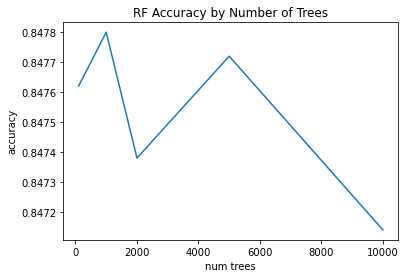

In [268]:
# fig, ax = plt.subplots()
# ax.plot(num_trees, accuracies)
# ax.set_title('RF Accuracy by Number of Trees')
# ax.set_xlabel('num trees')
# ax.set_ylabel('accuracy');

In [270]:
# num_features = [100, 1000, 2000, 5000, 10000]
# accuracies = []

# for n in num_features:
#     rf_pipeline = Pipeline([('tfidf', TfidfVectorizer(max_features=n)),
#                         ('model', RandomForestClassifier(n_estimators=1000, 
#                                                          max_leaf_nodes=16, 
#                                                          verbose=2))])

#     rf_pipeline.fit(X_train, y_train)
#     rf_predicted = rf_pipeline.predict(X_test)
#     accuracies.append(accuracy_score(y_test, rf_predicted))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


building tree 1 of 1000
building tree 2 of 1000
building tree 3 of 1000
building tree 4 of 1000
building tree 5 of 1000
building tree 6 of 1000
building tree 7 of 1000
building tree 8 of 1000
building tree 9 of 1000
building tree 10 of 1000
building tree 11 of 1000
building tree 12 of 1000
building tree 13 of 1000
building tree 14 of 1000
building tree 15 of 1000
building tree 16 of 1000
building tree 17 of 1000
building tree 18 of 1000
building tree 19 of 1000
building tree 20 of 1000
building tree 21 of 1000
building tree 22 of 1000
building tree 23 of 1000
building tree 24 of 1000
building tree 25 of 1000
building tree 26 of 1000
building tree 27 of 1000
building tree 28 of 1000
building tree 29 of 1000
building tree 30 of 1000
building tree 31 of 1000
building tree 32 of 1000
building tree 33 of 1000
building tree 34 of 1000
building tree 35 of 1000
building tree 36 of 1000
building tree 37 of 1000
building tree 38 of 1000
building tree 39 of 1000
building tree 40 of 1000
building 

building tree 322 of 1000
building tree 323 of 1000
building tree 324 of 1000
building tree 325 of 1000
building tree 326 of 1000
building tree 327 of 1000
building tree 328 of 1000
building tree 329 of 1000
building tree 330 of 1000
building tree 331 of 1000
building tree 332 of 1000
building tree 333 of 1000
building tree 334 of 1000
building tree 335 of 1000
building tree 336 of 1000
building tree 337 of 1000
building tree 338 of 1000
building tree 339 of 1000
building tree 340 of 1000
building tree 341 of 1000
building tree 342 of 1000
building tree 343 of 1000
building tree 344 of 1000
building tree 345 of 1000
building tree 346 of 1000
building tree 347 of 1000
building tree 348 of 1000
building tree 349 of 1000
building tree 350 of 1000
building tree 351 of 1000
building tree 352 of 1000
building tree 353 of 1000
building tree 354 of 1000
building tree 355 of 1000
building tree 356 of 1000
building tree 357 of 1000
building tree 358 of 1000
building tree 359 of 1000
building tre

building tree 640 of 1000
building tree 641 of 1000
building tree 642 of 1000
building tree 643 of 1000
building tree 644 of 1000
building tree 645 of 1000
building tree 646 of 1000
building tree 647 of 1000
building tree 648 of 1000
building tree 649 of 1000
building tree 650 of 1000
building tree 651 of 1000
building tree 652 of 1000
building tree 653 of 1000
building tree 654 of 1000
building tree 655 of 1000
building tree 656 of 1000
building tree 657 of 1000
building tree 658 of 1000
building tree 659 of 1000
building tree 660 of 1000
building tree 661 of 1000
building tree 662 of 1000
building tree 663 of 1000
building tree 664 of 1000
building tree 665 of 1000
building tree 666 of 1000
building tree 667 of 1000
building tree 668 of 1000
building tree 669 of 1000
building tree 670 of 1000
building tree 671 of 1000
building tree 672 of 1000
building tree 673 of 1000
building tree 674 of 1000
building tree 675 of 1000
building tree 676 of 1000
building tree 677 of 1000
building tre

building tree 957 of 1000
building tree 958 of 1000
building tree 959 of 1000
building tree 960 of 1000
building tree 961 of 1000
building tree 962 of 1000
building tree 963 of 1000
building tree 964 of 1000
building tree 965 of 1000
building tree 966 of 1000
building tree 967 of 1000
building tree 968 of 1000
building tree 969 of 1000
building tree 970 of 1000
building tree 971 of 1000
building tree 972 of 1000
building tree 973 of 1000
building tree 974 of 1000
building tree 975 of 1000
building tree 976 of 1000
building tree 977 of 1000
building tree 978 of 1000
building tree 979 of 1000
building tree 980 of 1000
building tree 981 of 1000
building tree 982 of 1000
building tree 983 of 1000
building tree 984 of 1000
building tree 985 of 1000
building tree 986 of 1000
building tree 987 of 1000
building tree 988 of 1000
building tree 989 of 1000
building tree 990 of 1000
building tree 991 of 1000
building tree 992 of 1000
building tree 993 of 1000
building tree 994 of 1000
building tre

[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  1.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    3.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


building tree 1 of 1000
building tree 2 of 1000
building tree 3 of 1000
building tree 4 of 1000
building tree 5 of 1000
building tree 6 of 1000
building tree 7 of 1000
building tree 8 of 1000
building tree 9 of 1000
building tree 10 of 1000
building tree 11 of 1000
building tree 12 of 1000
building tree 13 of 1000
building tree 14 of 1000
building tree 15 of 1000
building tree 16 of 1000
building tree 17 of 1000
building tree 18 of 1000
building tree 19 of 1000
building tree 20 of 1000
building tree 21 of 1000
building tree 22 of 1000
building tree 23 of 1000
building tree 24 of 1000
building tree 25 of 1000
building tree 26 of 1000
building tree 27 of 1000
building tree 28 of 1000
building tree 29 of 1000
building tree 30 of 1000
building tree 31 of 1000
building tree 32 of 1000
building tree 33 of 1000
building tree 34 of 1000
building tree 35 of 1000
building tree 36 of 1000
building tree 37 of 1000
building tree 38 of 1000
building tree 39 of 1000
building tree 40 of 1000
building 

building tree 323 of 1000
building tree 324 of 1000
building tree 325 of 1000
building tree 326 of 1000
building tree 327 of 1000
building tree 328 of 1000
building tree 329 of 1000
building tree 330 of 1000
building tree 331 of 1000
building tree 332 of 1000
building tree 333 of 1000
building tree 334 of 1000
building tree 335 of 1000
building tree 336 of 1000
building tree 337 of 1000
building tree 338 of 1000
building tree 339 of 1000
building tree 340 of 1000
building tree 341 of 1000
building tree 342 of 1000
building tree 343 of 1000
building tree 344 of 1000
building tree 345 of 1000
building tree 346 of 1000
building tree 347 of 1000
building tree 348 of 1000
building tree 349 of 1000
building tree 350 of 1000
building tree 351 of 1000
building tree 352 of 1000
building tree 353 of 1000
building tree 354 of 1000
building tree 355 of 1000
building tree 356 of 1000
building tree 357 of 1000
building tree 358 of 1000
building tree 359 of 1000
building tree 360 of 1000
building tre

building tree 642 of 1000
building tree 643 of 1000
building tree 644 of 1000
building tree 645 of 1000
building tree 646 of 1000
building tree 647 of 1000
building tree 648 of 1000
building tree 649 of 1000
building tree 650 of 1000
building tree 651 of 1000
building tree 652 of 1000
building tree 653 of 1000
building tree 654 of 1000
building tree 655 of 1000
building tree 656 of 1000
building tree 657 of 1000
building tree 658 of 1000
building tree 659 of 1000
building tree 660 of 1000
building tree 661 of 1000
building tree 662 of 1000
building tree 663 of 1000
building tree 664 of 1000
building tree 665 of 1000
building tree 666 of 1000
building tree 667 of 1000
building tree 668 of 1000
building tree 669 of 1000
building tree 670 of 1000
building tree 671 of 1000
building tree 672 of 1000
building tree 673 of 1000
building tree 674 of 1000
building tree 675 of 1000
building tree 676 of 1000
building tree 677 of 1000
building tree 678 of 1000
building tree 679 of 1000
building tre

building tree 958 of 1000
building tree 959 of 1000
building tree 960 of 1000
building tree 961 of 1000
building tree 962 of 1000
building tree 963 of 1000
building tree 964 of 1000
building tree 965 of 1000
building tree 966 of 1000
building tree 967 of 1000
building tree 968 of 1000
building tree 969 of 1000
building tree 970 of 1000
building tree 971 of 1000
building tree 972 of 1000
building tree 973 of 1000
building tree 974 of 1000
building tree 975 of 1000
building tree 976 of 1000
building tree 977 of 1000
building tree 978 of 1000
building tree 979 of 1000
building tree 980 of 1000
building tree 981 of 1000
building tree 982 of 1000
building tree 983 of 1000
building tree 984 of 1000
building tree 985 of 1000
building tree 986 of 1000
building tree 987 of 1000
building tree 988 of 1000
building tree 989 of 1000
building tree 990 of 1000
building tree 991 of 1000
building tree 992 of 1000
building tree 993 of 1000
building tree 994 of 1000
building tree 995 of 1000
building tre

[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   58.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    4.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


building tree 1 of 1000
building tree 2 of 1000
building tree 3 of 1000
building tree 4 of 1000
building tree 5 of 1000
building tree 6 of 1000
building tree 7 of 1000
building tree 8 of 1000
building tree 9 of 1000
building tree 10 of 1000
building tree 11 of 1000
building tree 12 of 1000
building tree 13 of 1000
building tree 14 of 1000
building tree 15 of 1000
building tree 16 of 1000
building tree 17 of 1000
building tree 18 of 1000
building tree 19 of 1000
building tree 20 of 1000
building tree 21 of 1000
building tree 22 of 1000
building tree 23 of 1000
building tree 24 of 1000
building tree 25 of 1000
building tree 26 of 1000
building tree 27 of 1000
building tree 28 of 1000
building tree 29 of 1000
building tree 30 of 1000
building tree 31 of 1000
building tree 32 of 1000
building tree 33 of 1000
building tree 34 of 1000
building tree 35 of 1000
building tree 36 of 1000
building tree 37 of 1000
building tree 38 of 1000
building tree 39 of 1000
building tree 40 of 1000
building 

building tree 325 of 1000
building tree 326 of 1000
building tree 327 of 1000
building tree 328 of 1000
building tree 329 of 1000
building tree 330 of 1000
building tree 331 of 1000
building tree 332 of 1000
building tree 333 of 1000
building tree 334 of 1000
building tree 335 of 1000
building tree 336 of 1000
building tree 337 of 1000
building tree 338 of 1000
building tree 339 of 1000
building tree 340 of 1000
building tree 341 of 1000
building tree 342 of 1000
building tree 343 of 1000
building tree 344 of 1000
building tree 345 of 1000
building tree 346 of 1000
building tree 347 of 1000
building tree 348 of 1000
building tree 349 of 1000
building tree 350 of 1000
building tree 351 of 1000
building tree 352 of 1000
building tree 353 of 1000
building tree 354 of 1000
building tree 355 of 1000
building tree 356 of 1000
building tree 357 of 1000
building tree 358 of 1000
building tree 359 of 1000
building tree 360 of 1000
building tree 361 of 1000
building tree 362 of 1000
building tre

building tree 642 of 1000
building tree 643 of 1000
building tree 644 of 1000
building tree 645 of 1000
building tree 646 of 1000
building tree 647 of 1000
building tree 648 of 1000
building tree 649 of 1000
building tree 650 of 1000
building tree 651 of 1000
building tree 652 of 1000
building tree 653 of 1000
building tree 654 of 1000
building tree 655 of 1000
building tree 656 of 1000
building tree 657 of 1000
building tree 658 of 1000
building tree 659 of 1000
building tree 660 of 1000
building tree 661 of 1000
building tree 662 of 1000
building tree 663 of 1000
building tree 664 of 1000
building tree 665 of 1000
building tree 666 of 1000
building tree 667 of 1000
building tree 668 of 1000
building tree 669 of 1000
building tree 670 of 1000
building tree 671 of 1000
building tree 672 of 1000
building tree 673 of 1000
building tree 674 of 1000
building tree 675 of 1000
building tree 676 of 1000
building tree 677 of 1000
building tree 678 of 1000
building tree 679 of 1000
building tre

building tree 958 of 1000
building tree 959 of 1000
building tree 960 of 1000
building tree 961 of 1000
building tree 962 of 1000
building tree 963 of 1000
building tree 964 of 1000
building tree 965 of 1000
building tree 966 of 1000
building tree 967 of 1000
building tree 968 of 1000
building tree 969 of 1000
building tree 970 of 1000
building tree 971 of 1000
building tree 972 of 1000
building tree 973 of 1000
building tree 974 of 1000
building tree 975 of 1000
building tree 976 of 1000
building tree 977 of 1000
building tree 978 of 1000
building tree 979 of 1000
building tree 980 of 1000
building tree 981 of 1000
building tree 982 of 1000
building tree 983 of 1000
building tree 984 of 1000
building tree 985 of 1000
building tree 986 of 1000
building tree 987 of 1000
building tree 988 of 1000
building tree 989 of 1000
building tree 990 of 1000
building tree 991 of 1000
building tree 992 of 1000
building tree 993 of 1000
building tree 994 of 1000
building tree 995 of 1000
building tre

[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   53.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    3.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 1000
building tree 2 of 1000
building tree 3 of 1000
building tree 4 of 1000
building tree 5 of 1000
building tree 6 of 1000
building tree 7 of 1000
building tree 8 of 1000
building tree 9 of 1000
building tree 10 of 1000
building tree 11 of 1000
building tree 12 of 1000
building tree 13 of 1000
building tree 14 of 1000
building tree 15 of 1000
building tree 16 of 1000
building tree 17 of 1000
building tree 18 of 1000
building tree 19 of 1000
building tree 20 of 1000
building tree 21 of 1000
building tree 22 of 1000
building tree 23 of 1000
building tree 24 of 1000
building tree 25 of 1000
building tree 26 of 1000
building tree 27 of 1000
building tree 28 of 1000
building tree 29 of 1000
building tree 30 of 1000
building tree 31 of 1000
building tree 32 of 1000
building tree 33 of 1000
building tree 34 of 1000
building tree 35 of 1000
building tree 36 of 1000
building tree 37 of 1000
building tree 38 of 1000
building tree 39 of 1000
building tree 40 of 1000
building 

building tree 325 of 1000
building tree 326 of 1000
building tree 327 of 1000
building tree 328 of 1000
building tree 329 of 1000
building tree 330 of 1000
building tree 331 of 1000
building tree 332 of 1000
building tree 333 of 1000
building tree 334 of 1000
building tree 335 of 1000
building tree 336 of 1000
building tree 337 of 1000
building tree 338 of 1000
building tree 339 of 1000
building tree 340 of 1000
building tree 341 of 1000
building tree 342 of 1000
building tree 343 of 1000
building tree 344 of 1000
building tree 345 of 1000
building tree 346 of 1000
building tree 347 of 1000
building tree 348 of 1000
building tree 349 of 1000
building tree 350 of 1000
building tree 351 of 1000
building tree 352 of 1000
building tree 353 of 1000
building tree 354 of 1000
building tree 355 of 1000
building tree 356 of 1000
building tree 357 of 1000
building tree 358 of 1000
building tree 359 of 1000
building tree 360 of 1000
building tree 361 of 1000
building tree 362 of 1000
building tre

building tree 643 of 1000
building tree 644 of 1000
building tree 645 of 1000
building tree 646 of 1000
building tree 647 of 1000
building tree 648 of 1000
building tree 649 of 1000
building tree 650 of 1000
building tree 651 of 1000
building tree 652 of 1000
building tree 653 of 1000
building tree 654 of 1000
building tree 655 of 1000
building tree 656 of 1000
building tree 657 of 1000
building tree 658 of 1000
building tree 659 of 1000
building tree 660 of 1000
building tree 661 of 1000
building tree 662 of 1000
building tree 663 of 1000
building tree 664 of 1000
building tree 665 of 1000
building tree 666 of 1000
building tree 667 of 1000
building tree 668 of 1000
building tree 669 of 1000
building tree 670 of 1000
building tree 671 of 1000
building tree 672 of 1000
building tree 673 of 1000
building tree 674 of 1000
building tree 675 of 1000
building tree 676 of 1000
building tree 677 of 1000
building tree 678 of 1000
building tree 679 of 1000
building tree 680 of 1000
building tre

building tree 962 of 1000
building tree 963 of 1000
building tree 964 of 1000
building tree 965 of 1000
building tree 966 of 1000
building tree 967 of 1000
building tree 968 of 1000
building tree 969 of 1000
building tree 970 of 1000
building tree 971 of 1000
building tree 972 of 1000
building tree 973 of 1000
building tree 974 of 1000
building tree 975 of 1000
building tree 976 of 1000
building tree 977 of 1000
building tree 978 of 1000
building tree 979 of 1000
building tree 980 of 1000
building tree 981 of 1000
building tree 982 of 1000
building tree 983 of 1000
building tree 984 of 1000
building tree 985 of 1000
building tree 986 of 1000
building tree 987 of 1000
building tree 988 of 1000
building tree 989 of 1000
building tree 990 of 1000
building tree 991 of 1000
building tree 992 of 1000
building tree 993 of 1000
building tree 994 of 1000
building tree 995 of 1000
building tree 996 of 1000
building tree 997 of 1000
building tree 998 of 1000
building tree 999 of 1000
building tre

[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   47.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    4.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


building tree 1 of 1000
building tree 2 of 1000
building tree 3 of 1000
building tree 4 of 1000
building tree 5 of 1000
building tree 6 of 1000
building tree 7 of 1000
building tree 8 of 1000
building tree 9 of 1000
building tree 10 of 1000
building tree 11 of 1000
building tree 12 of 1000
building tree 13 of 1000
building tree 14 of 1000
building tree 15 of 1000
building tree 16 of 1000
building tree 17 of 1000
building tree 18 of 1000
building tree 19 of 1000
building tree 20 of 1000
building tree 21 of 1000
building tree 22 of 1000
building tree 23 of 1000
building tree 24 of 1000
building tree 25 of 1000
building tree 26 of 1000
building tree 27 of 1000
building tree 28 of 1000
building tree 29 of 1000
building tree 30 of 1000
building tree 31 of 1000
building tree 32 of 1000
building tree 33 of 1000
building tree 34 of 1000
building tree 35 of 1000
building tree 36 of 1000
building tree 37 of 1000
building tree 38 of 1000
building tree 39 of 1000
building tree 40 of 1000
building 

building tree 325 of 1000
building tree 326 of 1000
building tree 327 of 1000
building tree 328 of 1000
building tree 329 of 1000
building tree 330 of 1000
building tree 331 of 1000
building tree 332 of 1000
building tree 333 of 1000
building tree 334 of 1000
building tree 335 of 1000
building tree 336 of 1000
building tree 337 of 1000
building tree 338 of 1000
building tree 339 of 1000
building tree 340 of 1000
building tree 341 of 1000
building tree 342 of 1000
building tree 343 of 1000
building tree 344 of 1000
building tree 345 of 1000
building tree 346 of 1000
building tree 347 of 1000
building tree 348 of 1000
building tree 349 of 1000
building tree 350 of 1000
building tree 351 of 1000
building tree 352 of 1000
building tree 353 of 1000
building tree 354 of 1000
building tree 355 of 1000
building tree 356 of 1000
building tree 357 of 1000
building tree 358 of 1000
building tree 359 of 1000
building tree 360 of 1000
building tree 361 of 1000
building tree 362 of 1000
building tre

building tree 641 of 1000
building tree 642 of 1000
building tree 643 of 1000
building tree 644 of 1000
building tree 645 of 1000
building tree 646 of 1000
building tree 647 of 1000
building tree 648 of 1000
building tree 649 of 1000
building tree 650 of 1000
building tree 651 of 1000
building tree 652 of 1000
building tree 653 of 1000
building tree 654 of 1000
building tree 655 of 1000
building tree 656 of 1000
building tree 657 of 1000
building tree 658 of 1000
building tree 659 of 1000
building tree 660 of 1000
building tree 661 of 1000
building tree 662 of 1000
building tree 663 of 1000
building tree 664 of 1000
building tree 665 of 1000
building tree 666 of 1000
building tree 667 of 1000
building tree 668 of 1000
building tree 669 of 1000
building tree 670 of 1000
building tree 671 of 1000
building tree 672 of 1000
building tree 673 of 1000
building tree 674 of 1000
building tree 675 of 1000
building tree 676 of 1000
building tree 677 of 1000
building tree 678 of 1000
building tre

building tree 962 of 1000
building tree 963 of 1000
building tree 964 of 1000
building tree 965 of 1000
building tree 966 of 1000
building tree 967 of 1000
building tree 968 of 1000
building tree 969 of 1000
building tree 970 of 1000
building tree 971 of 1000
building tree 972 of 1000
building tree 973 of 1000
building tree 974 of 1000
building tree 975 of 1000
building tree 976 of 1000
building tree 977 of 1000
building tree 978 of 1000
building tree 979 of 1000
building tree 980 of 1000
building tree 981 of 1000
building tree 982 of 1000
building tree 983 of 1000
building tree 984 of 1000
building tree 985 of 1000
building tree 986 of 1000
building tree 987 of 1000
building tree 988 of 1000
building tree 989 of 1000
building tree 990 of 1000
building tree 991 of 1000
building tree 992 of 1000
building tree 993 of 1000
building tree 994 of 1000
building tree 995 of 1000
building tree 996 of 1000
building tree 997 of 1000
building tree 998 of 1000
building tree 999 of 1000
building tre

[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   42.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    4.2s finished


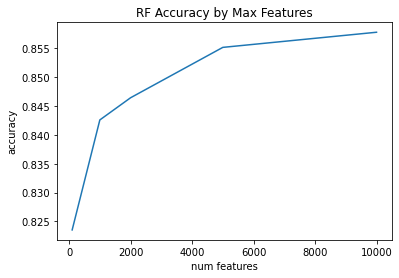

In [271]:
# fig, ax = plt.subplots()
# ax.plot(num_features, accuracies)
# ax.set_title('RF Accuracy by Max Features')
# ax.set_xlabel('num features')
# ax.set_ylabel('accuracy');

In [272]:
# num_leaf_nodes = [8, 16, 32, 64]
# accuracies = []

# for n in num_leaf_nodes:
#     rf_pipeline = Pipeline([('tfidf', TfidfVectorizer(max_features=None)),
#                         ('model', RandomForestClassifier(n_estimators=1000, 
#                                                          max_leaf_nodes=n, 
#                                                          verbose=2))])

#     rf_pipeline.fit(X_train, y_train)
#     rf_predicted = rf_pipeline.predict(X_test)
#     accuracies.append(accuracy_score(y_test, rf_predicted))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 1000
building tree 2 of 1000
building tree 3 of 1000
building tree 4 of 1000
building tree 5 of 1000
building tree 6 of 1000
building tree 7 of 1000
building tree 8 of 1000
building tree 9 of 1000
building tree 10 of 1000
building tree 11 of 1000
building tree 12 of 1000
building tree 13 of 1000
building tree 14 of 1000
building tree 15 of 1000
building tree 16 of 1000
building tree 17 of 1000
building tree 18 of 1000
building tree 19 of 1000
building tree 20 of 1000
building tree 21 of 1000
building tree 22 of 1000
building tree 23 of 1000
building tree 24 of 1000
building tree 25 of 1000
building tree 26 of 1000
building tree 27 of 1000
building tree 28 of 1000
building tree 29 of 1000
building tree 30 of 1000
building tree 31 of 1000
building tree 32 of 1000
building tree 33 of 1000
building tree 34 of 1000
building tree 35 of 1000
building tree 36 of 1000
building tree 37 of 1000
building tree 38 of 1000
building tree 39 of 1000
building tree 40 of 1000
building 

building tree 324 of 1000
building tree 325 of 1000
building tree 326 of 1000
building tree 327 of 1000
building tree 328 of 1000
building tree 329 of 1000
building tree 330 of 1000
building tree 331 of 1000
building tree 332 of 1000
building tree 333 of 1000
building tree 334 of 1000
building tree 335 of 1000
building tree 336 of 1000
building tree 337 of 1000
building tree 338 of 1000
building tree 339 of 1000
building tree 340 of 1000
building tree 341 of 1000
building tree 342 of 1000
building tree 343 of 1000
building tree 344 of 1000
building tree 345 of 1000
building tree 346 of 1000
building tree 347 of 1000
building tree 348 of 1000
building tree 349 of 1000
building tree 350 of 1000
building tree 351 of 1000
building tree 352 of 1000
building tree 353 of 1000
building tree 354 of 1000
building tree 355 of 1000
building tree 356 of 1000
building tree 357 of 1000
building tree 358 of 1000
building tree 359 of 1000
building tree 360 of 1000
building tree 361 of 1000
building tre

building tree 645 of 1000
building tree 646 of 1000
building tree 647 of 1000
building tree 648 of 1000
building tree 649 of 1000
building tree 650 of 1000
building tree 651 of 1000
building tree 652 of 1000
building tree 653 of 1000
building tree 654 of 1000
building tree 655 of 1000
building tree 656 of 1000
building tree 657 of 1000
building tree 658 of 1000
building tree 659 of 1000
building tree 660 of 1000
building tree 661 of 1000
building tree 662 of 1000
building tree 663 of 1000
building tree 664 of 1000
building tree 665 of 1000
building tree 666 of 1000
building tree 667 of 1000
building tree 668 of 1000
building tree 669 of 1000
building tree 670 of 1000
building tree 671 of 1000
building tree 672 of 1000
building tree 673 of 1000
building tree 674 of 1000
building tree 675 of 1000
building tree 676 of 1000
building tree 677 of 1000
building tree 678 of 1000
building tree 679 of 1000
building tree 680 of 1000
building tree 681 of 1000
building tree 682 of 1000
building tre

building tree 966 of 1000
building tree 967 of 1000
building tree 968 of 1000
building tree 969 of 1000
building tree 970 of 1000
building tree 971 of 1000
building tree 972 of 1000
building tree 973 of 1000
building tree 974 of 1000
building tree 975 of 1000
building tree 976 of 1000
building tree 977 of 1000
building tree 978 of 1000
building tree 979 of 1000
building tree 980 of 1000
building tree 981 of 1000
building tree 982 of 1000
building tree 983 of 1000
building tree 984 of 1000
building tree 985 of 1000
building tree 986 of 1000
building tree 987 of 1000
building tree 988 of 1000
building tree 989 of 1000
building tree 990 of 1000
building tree 991 of 1000
building tree 992 of 1000
building tree 993 of 1000
building tree 994 of 1000
building tree 995 of 1000
building tree 996 of 1000
building tree 997 of 1000
building tree 998 of 1000
building tree 999 of 1000
building tree 1000 of 1000


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   27.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 1000
building tree 2 of 1000
building tree 3 of 1000
building tree 4 of 1000
building tree 5 of 1000
building tree 6 of 1000
building tree 7 of 1000
building tree 8 of 1000
building tree 9 of 1000
building tree 10 of 1000
building tree 11 of 1000
building tree 12 of 1000
building tree 13 of 1000
building tree 14 of 1000
building tree 15 of 1000
building tree 16 of 1000
building tree 17 of 1000
building tree 18 of 1000
building tree 19 of 1000
building tree 20 of 1000
building tree 21 of 1000
building tree 22 of 1000
building tree 23 of 1000
building tree 24 of 1000
building tree 25 of 1000
building tree 26 of 1000
building tree 27 of 1000
building tree 28 of 1000
building tree 29 of 1000
building tree 30 of 1000
building tree 31 of 1000
building tree 32 of 1000
building tree 33 of 1000
building tree 34 of 1000
building tree 35 of 1000
building tree 36 of 1000
building tree 37 of 1000
building tree 38 of 1000
building tree 39 of 1000
building tree 40 of 1000
building 

building tree 324 of 1000
building tree 325 of 1000
building tree 326 of 1000
building tree 327 of 1000
building tree 328 of 1000
building tree 329 of 1000
building tree 330 of 1000
building tree 331 of 1000
building tree 332 of 1000
building tree 333 of 1000
building tree 334 of 1000
building tree 335 of 1000
building tree 336 of 1000
building tree 337 of 1000
building tree 338 of 1000
building tree 339 of 1000
building tree 340 of 1000
building tree 341 of 1000
building tree 342 of 1000
building tree 343 of 1000
building tree 344 of 1000
building tree 345 of 1000
building tree 346 of 1000
building tree 347 of 1000
building tree 348 of 1000
building tree 349 of 1000
building tree 350 of 1000
building tree 351 of 1000
building tree 352 of 1000
building tree 353 of 1000
building tree 354 of 1000
building tree 355 of 1000
building tree 356 of 1000
building tree 357 of 1000
building tree 358 of 1000
building tree 359 of 1000
building tree 360 of 1000
building tree 361 of 1000
building tre

building tree 642 of 1000
building tree 643 of 1000
building tree 644 of 1000
building tree 645 of 1000
building tree 646 of 1000
building tree 647 of 1000
building tree 648 of 1000
building tree 649 of 1000
building tree 650 of 1000
building tree 651 of 1000
building tree 652 of 1000
building tree 653 of 1000
building tree 654 of 1000
building tree 655 of 1000
building tree 656 of 1000
building tree 657 of 1000
building tree 658 of 1000
building tree 659 of 1000
building tree 660 of 1000
building tree 661 of 1000
building tree 662 of 1000
building tree 663 of 1000
building tree 664 of 1000
building tree 665 of 1000
building tree 666 of 1000
building tree 667 of 1000
building tree 668 of 1000
building tree 669 of 1000
building tree 670 of 1000
building tree 671 of 1000
building tree 672 of 1000
building tree 673 of 1000
building tree 674 of 1000
building tree 675 of 1000
building tree 676 of 1000
building tree 677 of 1000
building tree 678 of 1000
building tree 679 of 1000
building tre

building tree 963 of 1000
building tree 964 of 1000
building tree 965 of 1000
building tree 966 of 1000
building tree 967 of 1000
building tree 968 of 1000
building tree 969 of 1000
building tree 970 of 1000
building tree 971 of 1000
building tree 972 of 1000
building tree 973 of 1000
building tree 974 of 1000
building tree 975 of 1000
building tree 976 of 1000
building tree 977 of 1000
building tree 978 of 1000
building tree 979 of 1000
building tree 980 of 1000
building tree 981 of 1000
building tree 982 of 1000
building tree 983 of 1000
building tree 984 of 1000
building tree 985 of 1000
building tree 986 of 1000
building tree 987 of 1000
building tree 988 of 1000
building tree 989 of 1000
building tree 990 of 1000
building tree 991 of 1000
building tree 992 of 1000
building tree 993 of 1000
building tree 994 of 1000
building tree 995 of 1000
building tree 996 of 1000
building tree 997 of 1000
building tree 998 of 1000
building tree 999 of 1000
building tree 1000 of 1000


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   32.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    4.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 1000
building tree 2 of 1000
building tree 3 of 1000
building tree 4 of 1000
building tree 5 of 1000
building tree 6 of 1000
building tree 7 of 1000
building tree 8 of 1000
building tree 9 of 1000
building tree 10 of 1000
building tree 11 of 1000
building tree 12 of 1000
building tree 13 of 1000
building tree 14 of 1000
building tree 15 of 1000
building tree 16 of 1000
building tree 17 of 1000
building tree 18 of 1000
building tree 19 of 1000
building tree 20 of 1000
building tree 21 of 1000
building tree 22 of 1000
building tree 23 of 1000
building tree 24 of 1000
building tree 25 of 1000
building tree 26 of 1000
building tree 27 of 1000
building tree 28 of 1000
building tree 29 of 1000
building tree 30 of 1000
building tree 31 of 1000
building tree 32 of 1000
building tree 33 of 1000
building tree 34 of 1000
building tree 35 of 1000
building tree 36 of 1000
building tree 37 of 1000
building tree 38 of 1000
building tree 39 of 1000
building tree 40 of 1000
building 

building tree 321 of 1000
building tree 322 of 1000
building tree 323 of 1000
building tree 324 of 1000
building tree 325 of 1000
building tree 326 of 1000
building tree 327 of 1000
building tree 328 of 1000
building tree 329 of 1000
building tree 330 of 1000
building tree 331 of 1000
building tree 332 of 1000
building tree 333 of 1000
building tree 334 of 1000
building tree 335 of 1000
building tree 336 of 1000
building tree 337 of 1000
building tree 338 of 1000
building tree 339 of 1000
building tree 340 of 1000
building tree 341 of 1000
building tree 342 of 1000
building tree 343 of 1000
building tree 344 of 1000
building tree 345 of 1000
building tree 346 of 1000
building tree 347 of 1000
building tree 348 of 1000
building tree 349 of 1000
building tree 350 of 1000
building tree 351 of 1000
building tree 352 of 1000
building tree 353 of 1000
building tree 354 of 1000
building tree 355 of 1000
building tree 356 of 1000
building tree 357 of 1000
building tree 358 of 1000
building tre

building tree 638 of 1000
building tree 639 of 1000
building tree 640 of 1000
building tree 641 of 1000
building tree 642 of 1000
building tree 643 of 1000
building tree 644 of 1000
building tree 645 of 1000
building tree 646 of 1000
building tree 647 of 1000
building tree 648 of 1000
building tree 649 of 1000
building tree 650 of 1000
building tree 651 of 1000
building tree 652 of 1000
building tree 653 of 1000
building tree 654 of 1000
building tree 655 of 1000
building tree 656 of 1000
building tree 657 of 1000
building tree 658 of 1000
building tree 659 of 1000
building tree 660 of 1000
building tree 661 of 1000
building tree 662 of 1000
building tree 663 of 1000
building tree 664 of 1000
building tree 665 of 1000
building tree 666 of 1000
building tree 667 of 1000
building tree 668 of 1000
building tree 669 of 1000
building tree 670 of 1000
building tree 671 of 1000
building tree 672 of 1000
building tree 673 of 1000
building tree 674 of 1000
building tree 675 of 1000
building tre

building tree 958 of 1000
building tree 959 of 1000
building tree 960 of 1000
building tree 961 of 1000
building tree 962 of 1000
building tree 963 of 1000
building tree 964 of 1000
building tree 965 of 1000
building tree 966 of 1000
building tree 967 of 1000
building tree 968 of 1000
building tree 969 of 1000
building tree 970 of 1000
building tree 971 of 1000
building tree 972 of 1000
building tree 973 of 1000
building tree 974 of 1000
building tree 975 of 1000
building tree 976 of 1000
building tree 977 of 1000
building tree 978 of 1000
building tree 979 of 1000
building tree 980 of 1000
building tree 981 of 1000
building tree 982 of 1000
building tree 983 of 1000
building tree 984 of 1000
building tree 985 of 1000
building tree 986 of 1000
building tree 987 of 1000
building tree 988 of 1000
building tree 989 of 1000
building tree 990 of 1000
building tree 991 of 1000
building tree 992 of 1000
building tree 993 of 1000
building tree 994 of 1000
building tree 995 of 1000
building tre

[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   45.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    6.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


building tree 1 of 1000
building tree 2 of 1000
building tree 3 of 1000
building tree 4 of 1000
building tree 5 of 1000
building tree 6 of 1000
building tree 7 of 1000
building tree 8 of 1000
building tree 9 of 1000
building tree 10 of 1000
building tree 11 of 1000
building tree 12 of 1000
building tree 13 of 1000
building tree 14 of 1000
building tree 15 of 1000
building tree 16 of 1000
building tree 17 of 1000
building tree 18 of 1000
building tree 19 of 1000
building tree 20 of 1000
building tree 21 of 1000
building tree 22 of 1000
building tree 23 of 1000
building tree 24 of 1000
building tree 25 of 1000
building tree 26 of 1000
building tree 27 of 1000
building tree 28 of 1000
building tree 29 of 1000
building tree 30 of 1000
building tree 31 of 1000
building tree 32 of 1000
building tree 33 of 1000
building tree 34 of 1000
building tree 35 of 1000
building tree 36 of 1000
building tree 37 of 1000
building tree 38 of 1000
building tree 39 of 1000
building tree 40 of 1000
building 

building tree 323 of 1000
building tree 324 of 1000
building tree 325 of 1000
building tree 326 of 1000
building tree 327 of 1000
building tree 328 of 1000
building tree 329 of 1000
building tree 330 of 1000
building tree 331 of 1000
building tree 332 of 1000
building tree 333 of 1000
building tree 334 of 1000
building tree 335 of 1000
building tree 336 of 1000
building tree 337 of 1000
building tree 338 of 1000
building tree 339 of 1000
building tree 340 of 1000
building tree 341 of 1000
building tree 342 of 1000
building tree 343 of 1000
building tree 344 of 1000
building tree 345 of 1000
building tree 346 of 1000
building tree 347 of 1000
building tree 348 of 1000
building tree 349 of 1000
building tree 350 of 1000
building tree 351 of 1000
building tree 352 of 1000
building tree 353 of 1000
building tree 354 of 1000
building tree 355 of 1000
building tree 356 of 1000
building tree 357 of 1000
building tree 358 of 1000
building tree 359 of 1000
building tree 360 of 1000
building tre

building tree 639 of 1000
building tree 640 of 1000
building tree 641 of 1000
building tree 642 of 1000
building tree 643 of 1000
building tree 644 of 1000
building tree 645 of 1000
building tree 646 of 1000
building tree 647 of 1000
building tree 648 of 1000
building tree 649 of 1000
building tree 650 of 1000
building tree 651 of 1000
building tree 652 of 1000
building tree 653 of 1000
building tree 654 of 1000
building tree 655 of 1000
building tree 656 of 1000
building tree 657 of 1000
building tree 658 of 1000
building tree 659 of 1000
building tree 660 of 1000
building tree 661 of 1000
building tree 662 of 1000
building tree 663 of 1000
building tree 664 of 1000
building tree 665 of 1000
building tree 666 of 1000
building tree 667 of 1000
building tree 668 of 1000
building tree 669 of 1000
building tree 670 of 1000
building tree 671 of 1000
building tree 672 of 1000
building tree 673 of 1000
building tree 674 of 1000
building tree 675 of 1000
building tree 676 of 1000
building tre

building tree 958 of 1000
building tree 959 of 1000
building tree 960 of 1000
building tree 961 of 1000
building tree 962 of 1000
building tree 963 of 1000
building tree 964 of 1000
building tree 965 of 1000
building tree 966 of 1000
building tree 967 of 1000
building tree 968 of 1000
building tree 969 of 1000
building tree 970 of 1000
building tree 971 of 1000
building tree 972 of 1000
building tree 973 of 1000
building tree 974 of 1000
building tree 975 of 1000
building tree 976 of 1000
building tree 977 of 1000
building tree 978 of 1000
building tree 979 of 1000
building tree 980 of 1000
building tree 981 of 1000
building tree 982 of 1000
building tree 983 of 1000
building tree 984 of 1000
building tree 985 of 1000
building tree 986 of 1000
building tree 987 of 1000
building tree 988 of 1000
building tree 989 of 1000
building tree 990 of 1000
building tree 991 of 1000
building tree 992 of 1000
building tree 993 of 1000
building tree 994 of 1000
building tree 995 of 1000
building tre

[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  1.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    9.0s finished


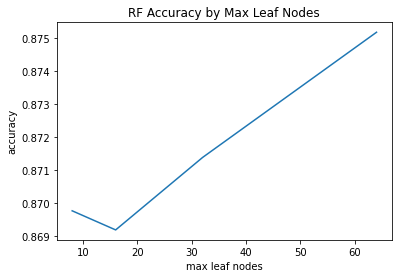

In [274]:
# fig, ax = plt.subplots()
# ax.plot(num_leaf_nodes, accuracies)
# ax.set_title('RF Accuracy by Max Leaf Nodes')
# ax.set_xlabel('max leaf nodes')
# ax.set_ylabel('accuracy');

In [280]:
# max_depths = [8, 16, 32, 64]
# accuracies = []

# for n in max_depths:
#     rf_pipeline = Pipeline([('tfidf', TfidfVectorizer(max_features=None)),
#                         ('model', RandomForestClassifier(n_estimators=1000, 
#                                                          max_depth=n, 
#                                                          verbose=2))])

#     rf_pipeline.fit(X_train, y_train)
#     rf_predicted = rf_pipeline.predict(X_test)
#     accuracies.append(accuracy_score(y_test, rf_predicted))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 1000
building tree 2 of 1000
building tree 3 of 1000
building tree 4 of 1000
building tree 5 of 1000
building tree 6 of 1000
building tree 7 of 1000
building tree 8 of 1000
building tree 9 of 1000
building tree 10 of 1000
building tree 11 of 1000
building tree 12 of 1000
building tree 13 of 1000
building tree 14 of 1000
building tree 15 of 1000
building tree 16 of 1000
building tree 17 of 1000
building tree 18 of 1000
building tree 19 of 1000
building tree 20 of 1000
building tree 21 of 1000
building tree 22 of 1000
building tree 23 of 1000
building tree 24 of 1000
building tree 25 of 1000
building tree 26 of 1000
building tree 27 of 1000
building tree 28 of 1000
building tree 29 of 1000
building tree 30 of 1000
building tree 31 of 1000
building tree 32 of 1000
building tree 33 of 1000
building tree 34 of 1000
building tree 35 of 1000
building tree 36 of 1000
building tree 37 of 1000
building tree 38 of 1000
building tree 39 of 1000
building tree 40 of 1000
building 

building tree 327 of 1000
building tree 328 of 1000
building tree 329 of 1000
building tree 330 of 1000
building tree 331 of 1000
building tree 332 of 1000
building tree 333 of 1000
building tree 334 of 1000
building tree 335 of 1000
building tree 336 of 1000
building tree 337 of 1000
building tree 338 of 1000
building tree 339 of 1000
building tree 340 of 1000
building tree 341 of 1000
building tree 342 of 1000
building tree 343 of 1000
building tree 344 of 1000
building tree 345 of 1000
building tree 346 of 1000
building tree 347 of 1000
building tree 348 of 1000
building tree 349 of 1000
building tree 350 of 1000
building tree 351 of 1000
building tree 352 of 1000
building tree 353 of 1000
building tree 354 of 1000
building tree 355 of 1000
building tree 356 of 1000
building tree 357 of 1000
building tree 358 of 1000
building tree 359 of 1000
building tree 360 of 1000
building tree 361 of 1000
building tree 362 of 1000
building tree 363 of 1000
building tree 364 of 1000
building tre

building tree 643 of 1000
building tree 644 of 1000
building tree 645 of 1000
building tree 646 of 1000
building tree 647 of 1000
building tree 648 of 1000
building tree 649 of 1000
building tree 650 of 1000
building tree 651 of 1000
building tree 652 of 1000
building tree 653 of 1000
building tree 654 of 1000
building tree 655 of 1000
building tree 656 of 1000
building tree 657 of 1000
building tree 658 of 1000
building tree 659 of 1000
building tree 660 of 1000
building tree 661 of 1000
building tree 662 of 1000
building tree 663 of 1000
building tree 664 of 1000
building tree 665 of 1000
building tree 666 of 1000
building tree 667 of 1000
building tree 668 of 1000
building tree 669 of 1000
building tree 670 of 1000
building tree 671 of 1000
building tree 672 of 1000
building tree 673 of 1000
building tree 674 of 1000
building tree 675 of 1000
building tree 676 of 1000
building tree 677 of 1000
building tree 678 of 1000
building tree 679 of 1000
building tree 680 of 1000
building tre

building tree 959 of 1000
building tree 960 of 1000
building tree 961 of 1000
building tree 962 of 1000
building tree 963 of 1000
building tree 964 of 1000
building tree 965 of 1000
building tree 966 of 1000
building tree 967 of 1000
building tree 968 of 1000
building tree 969 of 1000
building tree 970 of 1000
building tree 971 of 1000
building tree 972 of 1000
building tree 973 of 1000
building tree 974 of 1000
building tree 975 of 1000
building tree 976 of 1000
building tree 977 of 1000
building tree 978 of 1000
building tree 979 of 1000
building tree 980 of 1000
building tree 981 of 1000
building tree 982 of 1000
building tree 983 of 1000
building tree 984 of 1000
building tree 985 of 1000
building tree 986 of 1000
building tree 987 of 1000
building tree 988 of 1000
building tree 989 of 1000
building tree 990 of 1000
building tree 991 of 1000
building tree 992 of 1000
building tree 993 of 1000
building tree 994 of 1000
building tree 995 of 1000
building tree 996 of 1000
building tre

[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   30.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    3.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


building tree 1 of 1000
building tree 2 of 1000
building tree 3 of 1000
building tree 4 of 1000
building tree 5 of 1000
building tree 6 of 1000
building tree 7 of 1000
building tree 8 of 1000
building tree 9 of 1000
building tree 10 of 1000
building tree 11 of 1000
building tree 12 of 1000
building tree 13 of 1000
building tree 14 of 1000
building tree 15 of 1000
building tree 16 of 1000
building tree 17 of 1000
building tree 18 of 1000
building tree 19 of 1000
building tree 20 of 1000
building tree 21 of 1000
building tree 22 of 1000
building tree 23 of 1000
building tree 24 of 1000
building tree 25 of 1000
building tree 26 of 1000
building tree 27 of 1000
building tree 28 of 1000
building tree 29 of 1000
building tree 30 of 1000
building tree 31 of 1000
building tree 32 of 1000
building tree 33 of 1000
building tree 34 of 1000
building tree 35 of 1000
building tree 36 of 1000
building tree 37 of 1000
building tree 38 of 1000
building tree 39 of 1000
building tree 40 of 1000
building 

building tree 321 of 1000
building tree 322 of 1000
building tree 323 of 1000
building tree 324 of 1000
building tree 325 of 1000
building tree 326 of 1000
building tree 327 of 1000
building tree 328 of 1000
building tree 329 of 1000
building tree 330 of 1000
building tree 331 of 1000
building tree 332 of 1000
building tree 333 of 1000
building tree 334 of 1000
building tree 335 of 1000
building tree 336 of 1000
building tree 337 of 1000
building tree 338 of 1000
building tree 339 of 1000
building tree 340 of 1000
building tree 341 of 1000
building tree 342 of 1000
building tree 343 of 1000
building tree 344 of 1000
building tree 345 of 1000
building tree 346 of 1000
building tree 347 of 1000
building tree 348 of 1000
building tree 349 of 1000
building tree 350 of 1000
building tree 351 of 1000
building tree 352 of 1000
building tree 353 of 1000
building tree 354 of 1000
building tree 355 of 1000
building tree 356 of 1000
building tree 357 of 1000
building tree 358 of 1000
building tre

building tree 638 of 1000
building tree 639 of 1000
building tree 640 of 1000
building tree 641 of 1000
building tree 642 of 1000
building tree 643 of 1000
building tree 644 of 1000
building tree 645 of 1000
building tree 646 of 1000
building tree 647 of 1000
building tree 648 of 1000
building tree 649 of 1000
building tree 650 of 1000
building tree 651 of 1000
building tree 652 of 1000
building tree 653 of 1000
building tree 654 of 1000
building tree 655 of 1000
building tree 656 of 1000
building tree 657 of 1000
building tree 658 of 1000
building tree 659 of 1000
building tree 660 of 1000
building tree 661 of 1000
building tree 662 of 1000
building tree 663 of 1000
building tree 664 of 1000
building tree 665 of 1000
building tree 666 of 1000
building tree 667 of 1000
building tree 668 of 1000
building tree 669 of 1000
building tree 670 of 1000
building tree 671 of 1000
building tree 672 of 1000
building tree 673 of 1000
building tree 674 of 1000
building tree 675 of 1000
building tre

building tree 955 of 1000
building tree 956 of 1000
building tree 957 of 1000
building tree 958 of 1000
building tree 959 of 1000
building tree 960 of 1000
building tree 961 of 1000
building tree 962 of 1000
building tree 963 of 1000
building tree 964 of 1000
building tree 965 of 1000
building tree 966 of 1000
building tree 967 of 1000
building tree 968 of 1000
building tree 969 of 1000
building tree 970 of 1000
building tree 971 of 1000
building tree 972 of 1000
building tree 973 of 1000
building tree 974 of 1000
building tree 975 of 1000
building tree 976 of 1000
building tree 977 of 1000
building tree 978 of 1000
building tree 979 of 1000
building tree 980 of 1000
building tree 981 of 1000
building tree 982 of 1000
building tree 983 of 1000
building tree 984 of 1000
building tree 985 of 1000
building tree 986 of 1000
building tree 987 of 1000
building tree 988 of 1000
building tree 989 of 1000
building tree 990 of 1000
building tree 991 of 1000
building tree 992 of 1000
building tre

[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   54.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    6.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


building tree 1 of 1000
building tree 2 of 1000
building tree 3 of 1000
building tree 4 of 1000
building tree 5 of 1000
building tree 6 of 1000
building tree 7 of 1000
building tree 8 of 1000
building tree 9 of 1000
building tree 10 of 1000
building tree 11 of 1000
building tree 12 of 1000
building tree 13 of 1000
building tree 14 of 1000
building tree 15 of 1000
building tree 16 of 1000
building tree 17 of 1000
building tree 18 of 1000
building tree 19 of 1000
building tree 20 of 1000
building tree 21 of 1000
building tree 22 of 1000
building tree 23 of 1000
building tree 24 of 1000
building tree 25 of 1000
building tree 26 of 1000
building tree 27 of 1000
building tree 28 of 1000
building tree 29 of 1000
building tree 30 of 1000
building tree 31 of 1000
building tree 32 of 1000
building tree 33 of 1000
building tree 34 of 1000
building tree 35 of 1000
building tree 36 of 1000
building tree 37 of 1000
building tree 38 of 1000
building tree 39 of 1000
building tree 40 of 1000
building 

building tree 322 of 1000
building tree 323 of 1000
building tree 324 of 1000
building tree 325 of 1000
building tree 326 of 1000
building tree 327 of 1000
building tree 328 of 1000
building tree 329 of 1000
building tree 330 of 1000
building tree 331 of 1000
building tree 332 of 1000
building tree 333 of 1000
building tree 334 of 1000
building tree 335 of 1000
building tree 336 of 1000
building tree 337 of 1000
building tree 338 of 1000
building tree 339 of 1000
building tree 340 of 1000
building tree 341 of 1000
building tree 342 of 1000
building tree 343 of 1000
building tree 344 of 1000
building tree 345 of 1000
building tree 346 of 1000
building tree 347 of 1000
building tree 348 of 1000
building tree 349 of 1000
building tree 350 of 1000
building tree 351 of 1000
building tree 352 of 1000
building tree 353 of 1000
building tree 354 of 1000
building tree 355 of 1000
building tree 356 of 1000
building tree 357 of 1000
building tree 358 of 1000
building tree 359 of 1000
building tre

building tree 639 of 1000
building tree 640 of 1000
building tree 641 of 1000
building tree 642 of 1000
building tree 643 of 1000
building tree 644 of 1000
building tree 645 of 1000
building tree 646 of 1000
building tree 647 of 1000
building tree 648 of 1000
building tree 649 of 1000
building tree 650 of 1000
building tree 651 of 1000
building tree 652 of 1000
building tree 653 of 1000
building tree 654 of 1000
building tree 655 of 1000
building tree 656 of 1000
building tree 657 of 1000
building tree 658 of 1000
building tree 659 of 1000
building tree 660 of 1000
building tree 661 of 1000
building tree 662 of 1000
building tree 663 of 1000
building tree 664 of 1000
building tree 665 of 1000
building tree 666 of 1000
building tree 667 of 1000
building tree 668 of 1000
building tree 669 of 1000
building tree 670 of 1000
building tree 671 of 1000
building tree 672 of 1000
building tree 673 of 1000
building tree 674 of 1000
building tree 675 of 1000
building tree 676 of 1000
building tre

building tree 955 of 1000
building tree 956 of 1000
building tree 957 of 1000
building tree 958 of 1000
building tree 959 of 1000
building tree 960 of 1000
building tree 961 of 1000
building tree 962 of 1000
building tree 963 of 1000
building tree 964 of 1000
building tree 965 of 1000
building tree 966 of 1000
building tree 967 of 1000
building tree 968 of 1000
building tree 969 of 1000
building tree 970 of 1000
building tree 971 of 1000
building tree 972 of 1000
building tree 973 of 1000
building tree 974 of 1000
building tree 975 of 1000
building tree 976 of 1000
building tree 977 of 1000
building tree 978 of 1000
building tree 979 of 1000
building tree 980 of 1000
building tree 981 of 1000
building tree 982 of 1000
building tree 983 of 1000
building tree 984 of 1000
building tree 985 of 1000
building tree 986 of 1000
building tree 987 of 1000
building tree 988 of 1000
building tree 989 of 1000
building tree 990 of 1000
building tree 991 of 1000
building tree 992 of 1000
building tre

[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  2.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    7.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 1000


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


building tree 2 of 1000
building tree 3 of 1000
building tree 4 of 1000
building tree 5 of 1000
building tree 6 of 1000
building tree 7 of 1000
building tree 8 of 1000
building tree 9 of 1000
building tree 10 of 1000
building tree 11 of 1000
building tree 12 of 1000
building tree 13 of 1000
building tree 14 of 1000
building tree 15 of 1000
building tree 16 of 1000
building tree 17 of 1000
building tree 18 of 1000
building tree 19 of 1000
building tree 20 of 1000
building tree 21 of 1000
building tree 22 of 1000
building tree 23 of 1000
building tree 24 of 1000
building tree 25 of 1000
building tree 26 of 1000
building tree 27 of 1000
building tree 28 of 1000
building tree 29 of 1000
building tree 30 of 1000
building tree 31 of 1000
building tree 32 of 1000
building tree 33 of 1000
building tree 34 of 1000
building tree 35 of 1000
building tree 36 of 1000
building tree 37 of 1000
building tree 38 of 1000
building tree 39 of 1000
building tree 40 of 1000
building tree 41 of 1000
building

building tree 322 of 1000
building tree 323 of 1000
building tree 324 of 1000
building tree 325 of 1000
building tree 326 of 1000
building tree 327 of 1000
building tree 328 of 1000
building tree 329 of 1000
building tree 330 of 1000
building tree 331 of 1000
building tree 332 of 1000
building tree 333 of 1000
building tree 334 of 1000
building tree 335 of 1000
building tree 336 of 1000
building tree 337 of 1000
building tree 338 of 1000
building tree 339 of 1000
building tree 340 of 1000
building tree 341 of 1000
building tree 342 of 1000
building tree 343 of 1000
building tree 344 of 1000
building tree 345 of 1000
building tree 346 of 1000
building tree 347 of 1000
building tree 348 of 1000
building tree 349 of 1000
building tree 350 of 1000
building tree 351 of 1000
building tree 352 of 1000
building tree 353 of 1000
building tree 354 of 1000
building tree 355 of 1000
building tree 356 of 1000
building tree 357 of 1000
building tree 358 of 1000
building tree 359 of 1000
building tre

building tree 638 of 1000
building tree 639 of 1000
building tree 640 of 1000
building tree 641 of 1000
building tree 642 of 1000
building tree 643 of 1000
building tree 644 of 1000
building tree 645 of 1000
building tree 646 of 1000
building tree 647 of 1000
building tree 648 of 1000
building tree 649 of 1000
building tree 650 of 1000
building tree 651 of 1000
building tree 652 of 1000
building tree 653 of 1000
building tree 654 of 1000
building tree 655 of 1000
building tree 656 of 1000
building tree 657 of 1000
building tree 658 of 1000
building tree 659 of 1000
building tree 660 of 1000
building tree 661 of 1000
building tree 662 of 1000
building tree 663 of 1000
building tree 664 of 1000
building tree 665 of 1000
building tree 666 of 1000
building tree 667 of 1000
building tree 668 of 1000
building tree 669 of 1000
building tree 670 of 1000
building tree 671 of 1000
building tree 672 of 1000
building tree 673 of 1000
building tree 674 of 1000
building tree 675 of 1000
building tre

building tree 954 of 1000
building tree 955 of 1000
building tree 956 of 1000
building tree 957 of 1000
building tree 958 of 1000
building tree 959 of 1000
building tree 960 of 1000
building tree 961 of 1000
building tree 962 of 1000
building tree 963 of 1000
building tree 964 of 1000
building tree 965 of 1000
building tree 966 of 1000
building tree 967 of 1000
building tree 968 of 1000
building tree 969 of 1000
building tree 970 of 1000
building tree 971 of 1000
building tree 972 of 1000
building tree 973 of 1000
building tree 974 of 1000
building tree 975 of 1000
building tree 976 of 1000
building tree 977 of 1000
building tree 978 of 1000
building tree 979 of 1000
building tree 980 of 1000
building tree 981 of 1000
building tree 982 of 1000
building tree 983 of 1000
building tree 984 of 1000
building tree 985 of 1000
building tree 986 of 1000
building tree 987 of 1000
building tree 988 of 1000
building tree 989 of 1000
building tree 990 of 1000
building tree 991 of 1000
building tre

[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  7.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   14.4s finished


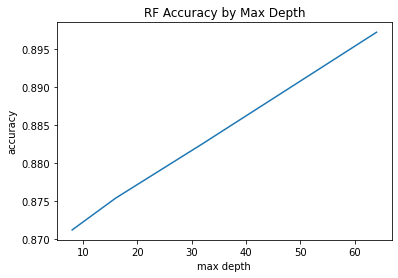

In [282]:
# fig, ax = plt.subplots()
# ax.plot(max_depths, accuracies)
# ax.set_title('RF Accuracy by Max Depth')
# ax.set_xlabel('max depth')
# ax.set_ylabel('accuracy');

In [89]:
# n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# max_features = ['auto']
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]


In [90]:
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth}

# pprint(random_grid)

{'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110],
 'max_features': ['auto'],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [91]:
# tfid = TfidfVectorizer()
# X_train_tfid = tfid.fit_transform(X_train)

# rf = RandomForestClassifier()
# rf_random = RandomizedSearchCV(estimator = rf, 
#                                param_distributions = random_grid, 
#                                n_iter = 3, 
#                                cv = 3, 
#                                verbose = 2, 
#                                n_jobs = -1)
# rf_random.fit(X_train_tfid, y_train)
# rf_random.best_params_

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed: 58.4min remaining: 16.7min
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed: 58.6min finished


{'n_estimators': 1600, 'max_features': 'auto', 'max_depth': 90}

In [93]:
rf_pipeline = Pipeline([('tfidf', TfidfVectorizer(max_features=10000)),
                        ('model', RandomForestClassifier(n_estimators=1600, 
                                                         max_depth=90))])
rf_pipeline.fit(X_train, y_train)
rf_predicted = rf_pipeline.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 1600


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


building tree 2 of 1600
building tree 3 of 1600
building tree 4 of 1600
building tree 5 of 1600
building tree 6 of 1600
building tree 7 of 1600
building tree 8 of 1600
building tree 9 of 1600
building tree 10 of 1600
building tree 11 of 1600
building tree 12 of 1600
building tree 13 of 1600
building tree 14 of 1600
building tree 15 of 1600
building tree 16 of 1600
building tree 17 of 1600
building tree 18 of 1600
building tree 19 of 1600
building tree 20 of 1600
building tree 21 of 1600
building tree 22 of 1600
building tree 23 of 1600
building tree 24 of 1600
building tree 25 of 1600
building tree 26 of 1600
building tree 27 of 1600
building tree 28 of 1600
building tree 29 of 1600
building tree 30 of 1600
building tree 31 of 1600
building tree 32 of 1600
building tree 33 of 1600
building tree 34 of 1600
building tree 35 of 1600
building tree 36 of 1600
building tree 37 of 1600
building tree 38 of 1600
building tree 39 of 1600
building tree 40 of 1600
building tree 41 of 1600
building

building tree 322 of 1600
building tree 323 of 1600
building tree 324 of 1600
building tree 325 of 1600
building tree 326 of 1600
building tree 327 of 1600
building tree 328 of 1600
building tree 329 of 1600
building tree 330 of 1600
building tree 331 of 1600
building tree 332 of 1600
building tree 333 of 1600
building tree 334 of 1600
building tree 335 of 1600
building tree 336 of 1600
building tree 337 of 1600
building tree 338 of 1600
building tree 339 of 1600
building tree 340 of 1600
building tree 341 of 1600
building tree 342 of 1600
building tree 343 of 1600
building tree 344 of 1600
building tree 345 of 1600
building tree 346 of 1600
building tree 347 of 1600
building tree 348 of 1600
building tree 349 of 1600
building tree 350 of 1600
building tree 351 of 1600
building tree 352 of 1600
building tree 353 of 1600
building tree 354 of 1600
building tree 355 of 1600
building tree 356 of 1600
building tree 357 of 1600
building tree 358 of 1600
building tree 359 of 1600
building tre

building tree 638 of 1600
building tree 639 of 1600
building tree 640 of 1600
building tree 641 of 1600
building tree 642 of 1600
building tree 643 of 1600
building tree 644 of 1600
building tree 645 of 1600
building tree 646 of 1600
building tree 647 of 1600
building tree 648 of 1600
building tree 649 of 1600
building tree 650 of 1600
building tree 651 of 1600
building tree 652 of 1600
building tree 653 of 1600
building tree 654 of 1600
building tree 655 of 1600
building tree 656 of 1600
building tree 657 of 1600
building tree 658 of 1600
building tree 659 of 1600
building tree 660 of 1600
building tree 661 of 1600
building tree 662 of 1600
building tree 663 of 1600
building tree 664 of 1600
building tree 665 of 1600
building tree 666 of 1600
building tree 667 of 1600
building tree 668 of 1600
building tree 669 of 1600
building tree 670 of 1600
building tree 671 of 1600
building tree 672 of 1600
building tree 673 of 1600
building tree 674 of 1600
building tree 675 of 1600
building tre

building tree 954 of 1600
building tree 955 of 1600
building tree 956 of 1600
building tree 957 of 1600
building tree 958 of 1600
building tree 959 of 1600
building tree 960 of 1600
building tree 961 of 1600
building tree 962 of 1600
building tree 963 of 1600
building tree 964 of 1600
building tree 965 of 1600
building tree 966 of 1600
building tree 967 of 1600
building tree 968 of 1600
building tree 969 of 1600
building tree 970 of 1600
building tree 971 of 1600
building tree 972 of 1600
building tree 973 of 1600
building tree 974 of 1600
building tree 975 of 1600
building tree 976 of 1600
building tree 977 of 1600
building tree 978 of 1600
building tree 979 of 1600
building tree 980 of 1600
building tree 981 of 1600
building tree 982 of 1600
building tree 983 of 1600
building tree 984 of 1600
building tree 985 of 1600
building tree 986 of 1600
building tree 987 of 1600
building tree 988 of 1600
building tree 989 of 1600
building tree 990 of 1600
building tree 991 of 1600
building tre

building tree 1260 of 1600
building tree 1261 of 1600
building tree 1262 of 1600
building tree 1263 of 1600
building tree 1264 of 1600
building tree 1265 of 1600
building tree 1266 of 1600
building tree 1267 of 1600
building tree 1268 of 1600
building tree 1269 of 1600
building tree 1270 of 1600
building tree 1271 of 1600
building tree 1272 of 1600
building tree 1273 of 1600
building tree 1274 of 1600
building tree 1275 of 1600
building tree 1276 of 1600
building tree 1277 of 1600
building tree 1278 of 1600
building tree 1279 of 1600
building tree 1280 of 1600
building tree 1281 of 1600
building tree 1282 of 1600
building tree 1283 of 1600
building tree 1284 of 1600
building tree 1285 of 1600
building tree 1286 of 1600
building tree 1287 of 1600
building tree 1288 of 1600
building tree 1289 of 1600
building tree 1290 of 1600
building tree 1291 of 1600
building tree 1292 of 1600
building tree 1293 of 1600
building tree 1294 of 1600
building tree 1295 of 1600
building tree 1296 of 1600
b

building tree 1564 of 1600
building tree 1565 of 1600
building tree 1566 of 1600
building tree 1567 of 1600
building tree 1568 of 1600
building tree 1569 of 1600
building tree 1570 of 1600
building tree 1571 of 1600
building tree 1572 of 1600
building tree 1573 of 1600
building tree 1574 of 1600
building tree 1575 of 1600
building tree 1576 of 1600
building tree 1577 of 1600
building tree 1578 of 1600
building tree 1579 of 1600
building tree 1580 of 1600
building tree 1581 of 1600
building tree 1582 of 1600
building tree 1583 of 1600
building tree 1584 of 1600
building tree 1585 of 1600
building tree 1586 of 1600
building tree 1587 of 1600
building tree 1588 of 1600
building tree 1589 of 1600
building tree 1590 of 1600
building tree 1591 of 1600
building tree 1592 of 1600
building tree 1593 of 1600
building tree 1594 of 1600
building tree 1595 of 1600
building tree 1596 of 1600
building tree 1597 of 1600
building tree 1598 of 1600
building tree 1599 of 1600
building tree 1600 of 1600


[Parallel(n_jobs=1)]: Done 1600 out of 1600 | elapsed: 26.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 1600 out of 1600 | elapsed:   31.8s finished


In [95]:
print("\nThe accuracy on the test set is {0:0.3f}.".format(accuracy_score(y_test, rf_predicted)))
print("\nThe precision on the test set is {0:0.3f}.".format(precision_score(y_test, rf_predicted)))
print("\nThe recall on the test set is {0:0.3f}.".format(recall_score(y_test, rf_predicted)))


The accuracy on the test set is 0.904.

The precision on the test set is 0.903.

The recall on the test set is 0.907.


In [96]:
get_multiple_predictions(text_list=text_list, pipeline=rf_pipeline)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 1600 out of 1600 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 1600 out of 1600 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Text: My mom always told me I wouldn’t accomplish anything by lying in bed all day. But look at me now, ma! I’m saving the world!
Prediction: Humorous

Text: If I keep stress-eating at this level, the buttons on my shirt will start socially distancing from each other.
Prediction: Humorous

Text: To help prevent the spread of COVID-19, everyone should wear a mask in public.
Prediction: Serious

Text: Avoid close contact with people who are sick.
Prediction: Serious



[Parallel(n_jobs=1)]: Done 1600 out of 1600 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 1600 out of 1600 | elapsed:    0.2s finished


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 1600 out of 1600 | elapsed:   29.2s finished


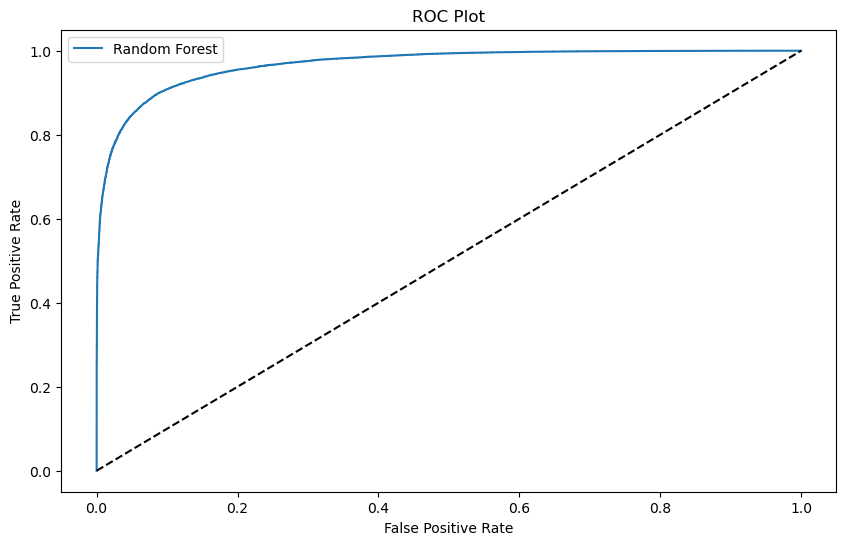

In [94]:
# probs_rf = rf_pipeline.predict_proba(X_test)[:, 1]
# fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test_values, probs_rf)

# x = np.linspace(0, 1)

# fig, ax = plt.subplots(figsize=(10, 6))
# ax.plot(fpr_rf, tpr_rf, label='Random Forest')
# ax.plot(x, x, color='black', linestyle='--')
# ax.set_xlabel('False Positive Rate')
# ax.set_ylabel('True Positive Rate')
# ax.set_title('ROC Plot')
# ax.legend();

## MLP

In [97]:
mlp_pipeline = Pipeline([('tfidf', TfidfVectorizer(max_features=5000)), #10000 = 0.926, #5000 = 0.926, #1000 = 0.91
                        ('model', MLPClassifier(batch_size=32,
                                                hidden_layer_sizes=(32,),
                                                verbose=True,
                                                early_stopping=True))])

In [98]:
mlp_predicted = fit_predict_model_accuracy(mlp_pipeline, X_train, y_train, X_test, y_test)

Iteration 1, loss = 0.24165666
Validation score: 0.917867
Iteration 2, loss = 0.19247781
Validation score: 0.919000
Iteration 3, loss = 0.17856048
Validation score: 0.921800
Iteration 4, loss = 0.16665535
Validation score: 0.922067
Iteration 5, loss = 0.15546653
Validation score: 0.924800
Iteration 6, loss = 0.14474211
Validation score: 0.924600
Iteration 7, loss = 0.13379297
Validation score: 0.923133
Iteration 8, loss = 0.12214250
Validation score: 0.924667
Iteration 9, loss = 0.11074730
Validation score: 0.926067
Iteration 10, loss = 0.09900450
Validation score: 0.925733
Iteration 11, loss = 0.08801739
Validation score: 0.926533
Iteration 12, loss = 0.07686847
Validation score: 0.925867
Iteration 13, loss = 0.06750860
Validation score: 0.926600
Iteration 14, loss = 0.05851646
Validation score: 0.924400
Iteration 15, loss = 0.05114057
Validation score: 0.924467
Iteration 16, loss = 0.04498380
Validation score: 0.924867
Iteration 17, loss = 0.03976209
Validation score: 0.924333
Iterat

In [99]:
print("\nThe accuracy on the test set is {0:0.3f}.".format(accuracy_score(y_test, mlp_predicted)))
print("\nThe precision on the test set is {0:0.3f}.".format(precision_score(y_test, mlp_predicted)))
print("\nThe recall on the test set is {0:0.3f}.".format(recall_score(y_test, mlp_predicted)))


The accuracy on the test set is 0.926.

The precision on the test set is 0.925.

The recall on the test set is 0.926.


In [100]:
get_multiple_predictions(text_list=text_list, pipeline=mlp_pipeline)

Text: My mom always told me I wouldn’t accomplish anything by lying in bed all day. But look at me now, ma! I’m saving the world!
Prediction: Humorous

Text: If I keep stress-eating at this level, the buttons on my shirt will start socially distancing from each other.
Prediction: Humorous

Text: To help prevent the spread of COVID-19, everyone should wear a mask in public.
Prediction: Serious

Text: Avoid close contact with people who are sick.
Prediction: Humorous



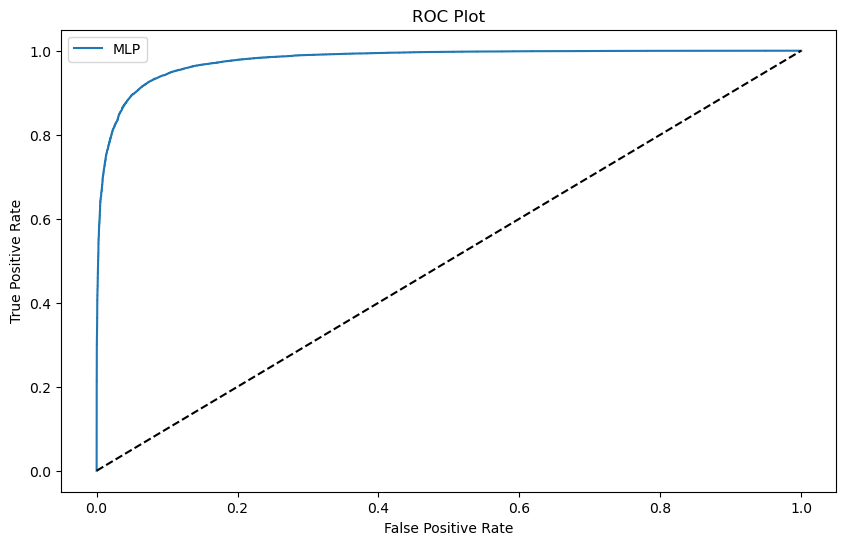

In [101]:
# probs_mlp = mlp_pipeline.predict_proba(X_test)[:, 1]
# fpr_mlp, tpr_mlp, thresholds_mlp = roc_curve(y_test_values, probs_mlp)

# x = np.linspace(0, 1)

# fig, ax = plt.subplots(figsize=(10, 6))
# ax.plot(fpr_mlp, tpr_mlp, label='MLP')
# ax.plot(x, x, color='black', linestyle='--')
# ax.set_xlabel('False Positive Rate')
# ax.set_ylabel('True Positive Rate')
# ax.set_title('ROC Plot')
# ax.legend();

## Combined ROC

In [ ]:
mnb_probs = mnb_pipeline.predict_proba(X_test)[:, 1]

In [ ]:
bnb_probs = bnb_pipeline.predict_proba(X_test)[:, 1]

In [ ]:
probs_rf = rf_pipeline.predict_proba(X_test)[:, 1]

In [ ]:
probs_mlp = mlp_pipeline.predict_proba(X_test)[:, 1]

In [177]:
mnb_fpr, mnb_tpr, mnb_thresholds = roc_curve(y_test_values, mnb_probs)

bnb_fpr, bnb_tpr, bnb_thresholds = roc_curve(y_test_values, bnb_probs)

fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test_values, probs_rf)

fpr_mlp, tpr_mlp, thresholds_mlp = roc_curve(y_test_values, probs_mlp)

x = np.linspace(0, 1)

plt.style.use('default')

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(bnb_fpr, bnb_tpr, color = 'blue', label='Bernoulli Naive Bayes')
ax.plot(mnb_fpr, mnb_tpr, color ='purple', linestyle='--', label='Multinomial Naive Bayes')
ax.plot(fpr_mlp, tpr_mlp, label='MLP')
ax.plot(fpr_rf, tpr_rf, label='Random Forest')
ax.plot(x, x, color='black', linestyle='-.')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Plot')
ax.legend(loc='lower right');

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


KeyboardInterrupt: 

## KMeans Clustering

In [109]:
k = 2
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X_vec = vectorizer.fit_transform(X)
features = vectorizer.get_feature_names()
kmeans = KMeans(n_clusters=k, verbose=2)
kmeans.fit(X_vec) 

Initialization complete
Iteration 0, inertia 389226.5170598529
Iteration 1, inertia 192428.11958325226
Iteration 2, inertia 191827.0403280601
Iteration 3, inertia 191658.9435263185
Iteration 4, inertia 191573.83172934302
Iteration 5, inertia 191544.954123222
Iteration 6, inertia 191543.53697242198
Iteration 7, inertia 191543.31057005527
Iteration 8, inertia 191543.12521163767
Iteration 9, inertia 191542.9540216123
Iteration 10, inertia 191542.67249194713
Iteration 11, inertia 191541.98170405484
Iteration 12, inertia 191539.71525344253
Iteration 13, inertia 191532.07547347504
Iteration 14, inertia 191510.28915726137
Iteration 15, inertia 191495.75184100933
Iteration 16, inertia 191494.12056920445
Iteration 17, inertia 191493.5115006556
Iteration 18, inertia 191492.53504103012
Iteration 19, inertia 191490.07598405136
Iteration 20, inertia 191481.76632811493
Iteration 21, inertia 191466.22983348687
Iteration 22, inertia 191459.9761700895
Iteration 23, inertia 191459.34118137974
Iteration 

KMeans(n_clusters=2, verbose=2)

In [110]:
print(kmeans.cluster_centers_)

[[0.00179165 0.00516274 0.00154327 ... 0.0008842  0.00217876 0.00150176]
 [0.00023612 0.00227371 0.000683   ... 0.000258   0.0004248  0.00082403]]


In [113]:
# Find the top 20 features for each cluster.
n_features = 20
top_centroids = kmeans.cluster_centers_.argsort()[:,-1:-(n_features+1):-1]
print("top features (words) for each cluster:")
for num, centroid in enumerate(top_centroids):
    print(f"{num}, {', '.join(features[i] for i in centroid)}")

top features (words) for each cluster:
0, like, trump, new, just, people, does, don, photos, make, know, day, man, women, video, time, says, donald, best, black, life
1, did, say, hear, cross, road, got, man, chicken, know, guy, just, wanted, didn, hitler, little, couldn, dog, new, fall, mexican


In [121]:
print("Random sample of texts in each cluster \n")
assigned_cluster = kmeans.transform(X_vec).argmin(axis=1)
for i in range(kmeans.n_clusters):
    cluster = np.arange(0, X_vec.shape[0])[assigned_cluster==i]
    sample_texts = np.random.choice(cluster, 10, replace=False)
    
    print(f'\n cluster {i}:')
    for idx in sample_texts:
        print(f'Quote: {X.iloc[idx]}\n Label: {y.iloc[idx]}')

Random sample of texts in each cluster 


 cluster 0:
Quote: Feeling grumpy? a mindfulness practice to help you get out of your grumpy pants
 Label: False
Quote: So a guy walks into a bar... and yells, i have ebola!
 Label: True
Quote: I can wake up at random intervals, crying and hungry too, so fuck you babies.
 Label: True
Quote: The truth about politics: mo' money, mo' problems
 Label: False
Quote: What's the best thing from new york city? the train to boston
 Label: True
Quote: How to win an argument. 1. have a vagina. 2. that's it. 3. you win. 4. congratulations.
 Label: True
Quote: Says the priest to the altar server: there's a good christian in you
 Label: True
Quote: When life gives you melons... you're probably dyslexic.
 Label: True
Quote: 'kinky boots' stars skewer 'bathroom bills' with musical ditty
 Label: False
Quote: Dark matter particles collide frequently with atoms in human bodies, study suggests
 Label: False

 cluster 1:
Quote: Why did the hotel refuse hospitality t

In [127]:
for i in range(kmeans.n_clusters):
    cluster = np.arange(0, X_vec.shape[0])[assigned_cluster==i]
    categories = y.iloc[cluster]
    most_common = Counter(categories).most_common()
    print(f"Cluster {i}:")
    for j in range (len(most_common)):
        print(f"     {most_common[j][0]} ({most_common[j][1]} texts)")

Cluster 0:
     False (99587 texts)
     True (90012 texts)
Cluster 1:
     True (9988 texts)
     False (413 texts)


Initialization complete
Iteration 0, inertia 391663.7186153257
Iteration 1, inertia 192446.68253863548
Iteration 2, inertia 191831.0047963292
Iteration 3, inertia 191662.40935891971
Iteration 4, inertia 191566.34198131852
Iteration 5, inertia 191542.92592954455
Iteration 6, inertia 191538.76089908314
Iteration 7, inertia 191535.09627734005
Iteration 8, inertia 191527.86815429118
Iteration 9, inertia 191522.50793716704
Iteration 10, inertia 191521.92550169546
Iteration 11, inertia 191521.9064424729
Iteration 12, inertia 191521.89210512684
Iteration 13, inertia 191521.873112058
Iteration 14, inertia 191521.8617291789
Iteration 15, inertia 191521.8462012117
Iteration 16, inertia 191521.83218810437
Iteration 17, inertia 191521.82410405492
Converged at iteration 17: center shift 3.4219812169008336e-08 within tolerance 9.62771570643571e-08
Initialization complete
Iteration 0, inertia 386055.2612014247
Iteration 1, inertia 192167.7820566593
Iteration 2, inertia 191545.35495950683
Iteration 3,

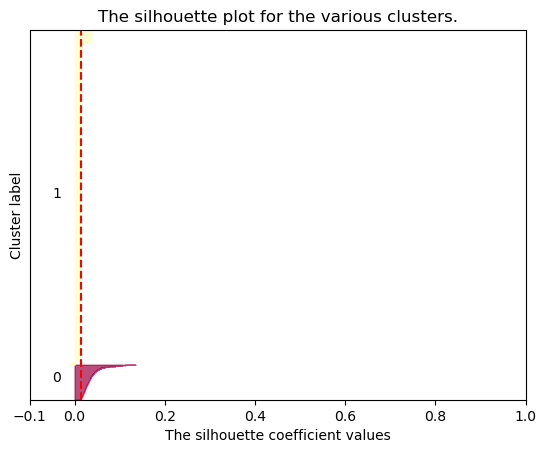

In [152]:
range_n_clusters = range(2,3)

# taken from sklearn
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots()
    #fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, X_vec.shape[0] + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, verbose=2, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_vec, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_vec, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        cmap = cm.get_cmap('Spectral')
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhoutte score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

#     # 2nd Plot showing the actual clusters formed

#     colors = cmap(cluster_labels.astype(float) / n_clusters)
#     ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
#                 c=colors)

#     # Labeling the clusters
#     centers = clusterer.cluster_centers_
#     # Draw white circles at cluster centers
#     ax2.scatter(centers[:, 0], centers[:, 1],
#                 marker='o', c="white", alpha=1, s=200)

#     for i, c in enumerate(centers):
#         ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

#     ax2.set_title("The visualization of the clustered data.")
#     ax2.set_xlabel("Feature space for the 1st feature")
#     ax2.set_ylabel("Feature space for the 2nd feature")

#     plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
#                   "with n_clusters = %d" % n_clusters),
#                  fontsize=14, fontweight='bold')

#     plt.show()

In [149]:
# plt.scatter(kmeans.cluster_centers_[:,0] ,kmeans.cluster_centers_[:,1], color='black')